In [ ]:
print('Hello, datamaster!')

Hello, datamaster!


#IMPORTS

In [ ]:
#============================
#IMPORTS
#============================

# Bibliotecas padrão
import os
import numpy as np
import pandas as pd
import sys
from pathlib import Path
import gc

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from scipy.stats import binom

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# Warnings
import warnings
warnings.filterwarnings('ignore')


#FUNÇÕES

In [ ]:
#============================
# FUNÇÕES
#============================

#Informações customizadas sem informação de memória
def custom_info(df):
    """
    Exibe resumo estruturado com contagem de valores não nulos e tipo das colunas,
    útil para ambientes como o Google Colab onde df.info() pode ocultar essas informações.
    """
    n_linhas = len(df)
    print(f"[Resumo do DataFrame] → Total de linhas: {n_linhas:,}\n")
    print(f"{'Coluna':<25} {'Valores Não Nulos':<20} {'Tipo de Dado'}")
    print("-" * 60)

    for col in df.columns:
        non_null = df[col].notnull().sum()
        dtype = df[col].dtype
        print(f"{col:<25} {non_null:<20,} {dtype}")

#Informações customizadas com informação de memória
def custom_info_mem(df, show_memory=False):
    """
    Exibe resumo estruturado com contagem de valores não nulos e tipo das colunas.
    Opcionalmente, mostra o uso de memória com `deep=True`.
    """
    n_linhas = len(df)
    print(f"[Resumo do DataFrame] → Total de linhas: {n_linhas:,}\n")
    print(f"{'Coluna':<25} {'Valores Não Nulos':<20} {'Tipo de Dado'}")
    print("-" * 60)

    for col in df.columns:
        non_null = df[col].notnull().sum()
        dtype = df[col].dtype
        print(f"{col:<25} {non_null:<20,} {dtype}")

    if show_memory:
        mem = df.memory_usage(deep=True).sum() / 1024**2
        print(f"\n[Uso de Memória] → {mem:.2f} MB (deep=True)")

# Função genérica para leitura e duplicação segura de DataFrames
def load_parquet_with_backup(name):
    df = pd.read_parquet(data_path / f"{name}.parquet")
    df_raw = df.copy(deep=True)
    return df, df_raw

# Validação geral dos valores das colunas
def validar_colunas(df, nome_base="base"):
    for col in df.columns:
        print(f"\nColuna: {col}")

        print(df[col].value_counts(dropna=False).head(10))

        try:
            col_numeric = pd.to_numeric(df[col], errors='coerce')

            if col_numeric.notna().sum() > 0:
                min_val = col_numeric.min()
                max_val = col_numeric.max()
                nunique = col_numeric.nunique()
                is_integer = (col_numeric.dropna() % 1 == 0).all()
                tipo = "todos inteiros" if is_integer else "há decimais"

                print(f"→ Mínimo numérico detectado: {min_val}")
                print(f"→ Máximo numérico detectado: {max_val}")
                print(f"→ Quantidade de valores únicos: {nunique}")
                print(f"→ Tipo numérico identificado: {tipo}")
            else:
                print("→ Coluna não contém valores numéricos válidos.")
        except Exception as e:
            print(f"→ Erro ao tentar converter para número: {e}")

    del col

# Comparar memória antes e depois da otimização
def comparar_memoria(df_antes, df_depois, nome_base="base", liberar_base_antiga=True):
    """
    Compara o uso de memória entre duas versões de um DataFrame (antes e depois do tratamento),
    exibe a economia em MB e percentual, e plota um gráfico de barras.

    Parâmetros:
    - df_antes: DataFrame original
    - df_depois: DataFrame após tratamento
    - nome_base: string para o título do gráfico
    - liberar_base_antiga: se True, deleta o df_antes após a comparação
    """
    mem_before = df_antes.memory_usage(deep=True).sum() / 1024**2
    mem_after = df_depois.memory_usage(deep=True).sum() / 1024**2

    print(f"Memória antes ({nome_base}): {mem_before:.2f} MB")
    print(f"Memória depois ({nome_base}): {mem_after:.2f} MB")
    print(f"Redução: {mem_before - mem_after:.2f} MB ({((mem_before - mem_after) / mem_before) * 100:.2f}%)")

    # Plot
    plt.figure(figsize=(6, 4))
    plt.bar(['Antes', 'Depois'], [mem_before, mem_after], color=['gray', 'green'])
    plt.title(f'Uso de Memória — Base {nome_base.capitalize()}')
    plt.ylabel('MB')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Libera memória da base antiga se quiser
    if liberar_base_antiga:
        del df_antes

    # Limpa temporários internos
    del mem_before, mem_after

# Analisar representatividade de variaveis vs churn
def analisar_faixas_churn(df, coluna, bins, labels, nome_coluna_faixa=None):
    """
    Agrupa a variável contínua em faixas, calcula churn e representatividade.

    Parâmetros:
    - df: DataFrame original com a coluna de churn ('is_churn').
    - coluna: nome da variável numérica a ser analisada (str).
    - bins: lista com os intervalos (list of floats).
    - labels: lista de labels para os bins (list of str).
    - nome_coluna_faixa: nome da nova coluna com os bins. Se None, usa f'{coluna}_faixa'.

    Retorna:
    - DataFrame com totais, % de churn e % de representatividade da faixa.
    """
    import pandas as pd

    if nome_coluna_faixa is None:
        nome_coluna_faixa = f'{coluna}_faixa'

    df_temp = df.copy()

    # Binning
    df_temp[nome_coluna_faixa] = pd.cut(
        df_temp[coluna],
        bins=bins,
        labels=labels,
        right=False
    )

    # Agrupamento
    resumo = (
        df_temp.groupby([nome_coluna_faixa, 'is_churn'])
        .size()
        .unstack(fill_value=0)
        .assign(total=lambda x: x[0] + x[1])
        .assign(
            perc_total=lambda x: (x['total'] / x['total'].sum() * 100).round(2).astype(str) + '%',
            perc_churn=lambda x: (x[1] / (x[0] + x[1]) * 100).round(2).astype(str) + '%'
        )
        .sort_values(by='total', ascending=False)
        .reset_index()
    )

    return resumo




#ESTRUTURA DE PASTAS

In [ ]:
#============================
#ESTRUTURA DE PASTAS NO DRIVE
#============================

import os
from google.colab import drive

# Monta o Google Drive
drive.mount('/content/drive')

# Define a raiz do projeto no Drive
base_dir = '/content/drive/MyDrive/data-masters-case'

# Estrutura de pastas do projeto
folders = [
    '',
    'data',
    'notebooks',
    'scripts',
    'outputs',
    'presentation'
]

# Criação das pastas
for folder in folders:
    path = os.path.join(base_dir, folder)
    os.makedirs(path, exist_ok=True)
    print(f"Pasta criada ou já existente: {path}")


Mounted at /content/drive
Pasta criada ou já existente: /content/drive/MyDrive/data-masters-case/
Pasta criada ou já existente: /content/drive/MyDrive/data-masters-case/data
Pasta criada ou já existente: /content/drive/MyDrive/data-masters-case/notebooks
Pasta criada ou já existente: /content/drive/MyDrive/data-masters-case/scripts
Pasta criada ou já existente: /content/drive/MyDrive/data-masters-case/outputs
Pasta criada ou já existente: /content/drive/MyDrive/data-masters-case/presentation


#LEITURA DOS DADOS

In [ ]:
# ================================
# LEITURA DOS DADOS
# ================================

# Define o caminho de forma robusta
data_path = Path("/content/drive/MyDrive/data-masters-case/data")

# Leitura com cópias de segurança para análise de memória posterior
transactions, transactions_raw = load_parquet_with_backup("transactions")
user_logs, user_logs_raw = load_parquet_with_backup("user_logs")
members, members_raw = load_parquet_with_backup("members")

# Força coleta de lixo para liberar RAM residual
gc.collect()

0

#1. TRATAMENTO INICIAL DAS BASES

In [ ]:
# Visualização das dimensões
print("Transactions:", transactions.shape)
print("User Logs:", user_logs.shape)
print("Members:", members.shape)

Transactions: (20712225, 10)
User Logs: (26758971, 9)
Members: (63867246, 8)


##1.1 TRATAMENTOS BASE TRANSACTIONS

In [ ]:
# Visualização inicial
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,safra
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,38,410,1788,1788,0,20151121,20170104,0,201511
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149,149,1,20150526,20150626,0,201505
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149,149,1,20150926,20151026,0,201509
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41,30,149,149,1,20160615,20160715,0,201606
4,++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=,40,31,149,149,1,20150113,20150216,0,201501


In [ ]:
#Informações customizadas transactions
custom_info_mem(transactions, show_memory=True)

[Resumo do DataFrame] → Total de linhas: 20,712,225

Coluna                    Valores Não Nulos    Tipo de Dado
------------------------------------------------------------
msno                      20,712,225           object
payment_method_id         20,712,225           object
payment_plan_days         20,712,225           object
plan_list_price           20,712,225           object
actual_amount_paid        20,712,225           object
is_auto_renew             20,712,225           object
transaction_date          20,712,225           object
membership_expire_date    20,712,225           object
is_cancel                 20,712,225           object
safra                     20,712,225           int32

[Uso de Memória] → 11619.73 MB (deep=True)


### Primeiras observações da base `transactions`

- `msno`: ID único por usuário (hash). Alta cardinalidade. Manter como `object` ou `category` para otimizar memória.

- `payment_method_id`: método de pagamento (int). Pode virar `int8` ou `category`, dependendo da variedade de valores.

- `payment_plan_days`: duração do plano em dias. Discreta, pode ser `int16`.

- `plan_list_price` / `actual_amount_paid`: valores monetários em NTD. Mesmo que inteiros, melhor usar `float32` por segurança futura.

- `is_auto_renew` / `is_cancel`: flags binárias. Podem ser `bool` ou `int8`, após validar se só existem 0/1.

- `transaction_date` / `membership_expire_date`: datas no formato `YYYYMMDD` (string). Devem virar `datetime`.

- `safra`: identificador de período criado. Se usado para agrupamento/filtragem, tratar como `category` ou `string`.

###VALIDACOES DAS COLUNAS - PRÉ CONVERSAO

In [ ]:
# ================================
# VALIDAÇÃO GERAL DOS VALORES DAS COLUNAS (ANTES DE CONVERTER)
# ================================

validar_colunas(transactions, nome_base="transactions")


Coluna: msno
msno
++8XaEDast796K/DQcP7sSoRQ8JRnA7X5S+oyXEw62E=    26
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=    26
++OvJH5FmfZ5CRrYfmbQEk7tJwCZhsJnkWbxClRaUpw=    26
++MMk1iSQdA3R+Oc167i7hu53ttFvz57mIKEKvdrmLM=    26
++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=    26
++CITmZPtQDWOi01uceGb75QJblInDRhjjGM1MmsiSY=    26
yJQ+W7R9TwrJVScxwh3P1svh/avNZwMUoC71NocvoKo=    26
Qklsrcqf0XVznwzQtYvY1nGo6VAkeGvwKDErzDrI/c8=    26
QkhXOlRTa6QKLCeKnZxoE8iD5pMp5UsU4jTOtFs9nqs=    26
QkhAH1t7qkPNMchirJG0cQLd8c8ni2kQ3XbQ6W8ifq0=    26
Name: count, dtype: int64
→ Coluna não contém valores numéricos válidos.

Coluna: payment_method_id
payment_method_id
41    11026911
40     2160126
38     1618337
39     1437059
37      991185
36      816661
34      728384
35      492261
33      402388
31      248960
Name: count, dtype: int64
→ Mínimo numérico detectado: 1
→ Máximo numérico detectado: 41
→ Quantidade de valores únicos: 40
→ Tipo numérico identificado: todos inteiros

Coluna: payment_plan_days
payment

### msno
- Hash identificador, alta cardinalidade.
- Correto uso de `category`.

### payment_method_id
- Inteiros de 1 a 41.
- Pode ser `category` se não houver lógica numérica.

### payment_plan_days
- Inteiros entre 0 e 450.
- Uso adequado de `int16`.

### plan_list_price / actual_amount_paid
- Monetários, atualmente inteiros.
- Uso de `float32` antecipa futuros centavos.

### is_auto_renew / is_cancel
- Binárias (0/1).
- Correto uso de `int8`.

### transaction_date / membership_expire_date
- Formato `%Y%m%d` antes da conversão.
- Valor mínimo `19700101` (epoch) indica possível valor default.

### safra
- Partição temporal (AAAAMM).
- Baixa cardinalidade. Uso de `category` é apropriado.

In [ ]:
# ================================
# CONVERSÃO DE TIPOS - OTIMIZAÇÃO E PREPARO PARA ANÁLISE
# ================================

# → Conversão de colunas de data para datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d', errors='coerce')
transactions['membership_expire_date'] = pd.to_datetime(transactions['membership_expire_date'], format='%Y%m%d', errors='coerce')

# Substitui epoch 1970-01-01 (erro típico de sistema) por NaT
transactions.loc[transactions['membership_expire_date'] == '1970-01-01', 'membership_expire_date'] = pd.NaT

# → Conversão de variáveis binárias para int8
transactions['is_auto_renew'] = transactions['is_auto_renew'].astype('int8')
transactions['is_cancel'] = transactions['is_cancel'].astype('int8')

# → Conversão de colunas numéricas para tipos otimizados
transactions['payment_plan_days'] = transactions['payment_plan_days'].astype('int16')           # Máximo: 450
transactions['plan_list_price'] = transactions['plan_list_price'].astype('float32')            # Monetário
transactions['actual_amount_paid'] = transactions['actual_amount_paid'].astype('float32')      # Monetário

# → Conversão de colunas categóricas
transactions['payment_method_id'] = transactions['payment_method_id'].astype('category')        # IDs fixos e discretos
transactions['msno'] = transactions['msno'].astype('category')                                  # Alta cardinalidade, sem cálculos
transactions['safra'] = transactions['safra'].astype('category')                                # Partições temporais (AAAAMM)

# ================================
# VERIFICAÇÃO FINAL DE TIPOS E MEMÓRIA
# ================================

custom_info_mem(transactions, show_memory=True)


[Resumo do DataFrame] → Total de linhas: 20,712,225

Coluna                    Valores Não Nulos    Tipo de Dado
------------------------------------------------------------
msno                      20,712,225           category
payment_method_id         20,712,225           category
payment_plan_days         20,712,225           int16
plan_list_price           20,712,225           float32
actual_amount_paid        20,712,225           float32
is_auto_renew             20,712,225           int8
transaction_date          20,712,225           datetime64[ns]
membership_expire_date    20,710,726           datetime64[ns]
is_cancel                 20,712,225           int8
safra                     20,712,225           category

[Uso de Memória] → 963.76 MB (deep=True)


Memória antes (transactions): 11619.73 MB
Memória depois (transactions): 963.76 MB
Redução: 10655.96 MB (91.71%)


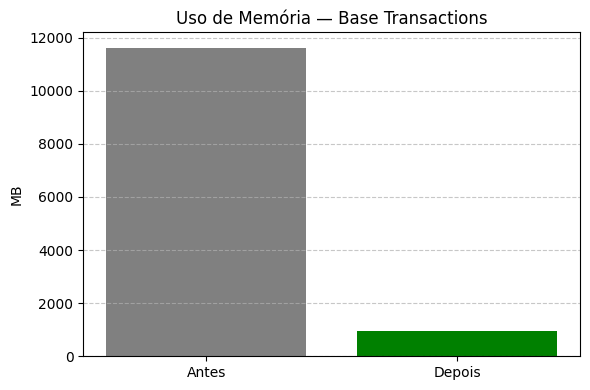

In [ ]:
# ================================
# COMPARATIVO DE MEMÓRIA: ANTES VS DEPOIS
# ================================

comparar_memoria(transactions_raw, transactions, nome_base="transactions")

In [ ]:
# ================================
# VALIDAÇÃO DE UNICIDADE POR CLIENTE E SAFRA - TRANSACTIONS
# ================================

# Gera contagens por safra
df_check = (
    transactions
    .groupby('safra')
    .agg(
        msno_nunique=('msno', 'nunique'),       # Quantidade de clientes distintos
        linhas_totais=('msno', 'count')         # Total de linhas na base
    )
    .assign(
        unico_por_espec=lambda df: (df['msno_nunique'] == df['linhas_totais']).astype(int)  # Valida se há apenas uma linha por cliente
    )
    .sort_index()
)

# Verifica se há duplicidade de msno por safra
duplicadas = df_check[df_check['unico_por_espec'] == 0]

# Output do resultado
if duplicadas.empty:
    print("Cada cliente (`msno`) aparece apenas uma vez por safra na base `transactions`.")
else:
    print("Foram encontradas duplicidades de clientes por safra na base `transactions`:")
    display(duplicadas)

# Libera memória
del df_check, duplicadas

Cada cliente (`msno`) aparece apenas uma vez por safra na base `transactions`.


In [ ]:
# ================================
# ESTATÍSTICAS DESCRITIVAS POR TIPO DE VARIÁVEL
# ================================
# Esta etapa apresenta estatísticas resumidas separadas por tipo de variável,
# facilitando a análise exploratória e a identificação de padrões, outliers e proporções.

# → Variáveis contínuas
cols_cont = ['plan_list_price', 'actual_amount_paid', 'payment_plan_days']
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(transactions[cols_cont].describe())

# → Variáveis binárias
cols_bin = ['is_auto_renew', 'is_cancel']
for col in cols_bin:
    print(f"\n{col}:\n{transactions[col].value_counts(normalize=True).rename('proportion')}")

# → Datas
print("\nJanela temporal da base:")
print(f"transaction_date: {transactions['transaction_date'].min()} → {transactions['transaction_date'].max()}")
print(f"membership_expire_date: {transactions['membership_expire_date'].min()} → {transactions['membership_expire_date'].max()}")

# → Safra como partição (valor anômico)
print("\nSafras disponíveis:")
print(transactions['safra'].value_counts().sort_index())

# → Categorias com poucos valores únicos
print("\npayment_method_id:")
print(transactions['payment_method_id'].value_counts().head(10))

# Limpeza de variáveis temporárias
del cols_cont, cols_bin, col

,plan_list_price,actual_amount_paid,payment_plan_days
count,"20,712,225.00","20,712,225.00","20,712,225.00"
mean,140.24,142.83,31.43
std,130.82,131.95,30.56
min,0.00,0.00,0.00
25%,99.00,99.00,30.00
50%,149.00,149.00,30.00
75%,149.00,149.00,30.00
max,"2,000.00","2,000.00",450.00



is_auto_renew:
is_auto_renew
1    0.854383
0    0.145617
Name: proportion, dtype: float64

is_cancel:
is_cancel
0    0.967123
1    0.032877
Name: proportion, dtype: float64

Janela temporal da base:
transaction_date: 2015-01-01 00:00:00 → 2017-02-28 00:00:00
membership_expire_date: 1999-12-30 00:00:00 → 2017-03-31 00:00:00

Safras disponíveis:
safra
201501     548792
201502     545303
201503     626488
201504     564582
201505     571552
201506     775737
201507     665280
201508     705975
201509     714610
201510     680465
201511     820345
201512     861107
201601     856716
201602     792300
201603     775469
201604     774169
201605     783956
201606     804729
201607     924032
201608     966450
201609     982640
201610    1033898
201611    1094941
201612     968547
201701     988576
201702     885566
Name: count, dtype: int64

payment_method_id:
payment_method_id
41    11026911
40     2160126
38     1618337
39     1437059
37      991185
36      816661
34      728384
35      49

##1.2 TRATAMENTOS BASE MEMBERS

In [ ]:
# Visualização inicial -- base members
members.head()

,msno,safra,registration_init_time,city,bd,gender,registered_via,is_ativo
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201612,20140927,1,0,None,7,1
1,++/AwGzubug3gT6J+0STBGMdWKxaM+UFZTI8Tcmq4To=,201607,20150322,1,0,None,9,0
2,++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=,201601,20121217,15,32,male,3,1
3,++02XbtviomSxcIBUHMOiJkjRxdicTXSfiVqLdsr5lo=,201603,20131112,14,21,male,7,0
4,++0O0Bq04sB/9ZcOS+pajpYL2Hin9jCqnc/8bKzKFuE=,201610,20141021,5,33,male,3,0


In [ ]:
members.describe()

,is_ativo
count,6.386725e+07
mean,1.760349e-01
std,3.808499e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


In [ ]:
# ================================
# INSPEÇÃO INICIAL - TIPOS E PRESENÇA DE NULOS
# ================================

# Objetivo: entender os tipos atuais de dados e identificar colunas com valores ausentes

# - Verificar o tipo de dado de cada coluna
# - Avaliar se o carregamento inicial manteve a estrutura textual ou numérica
# - Confirmar se há dados faltantes (null/NaN)

custom_info_mem(members, show_memory=True)

[Resumo do DataFrame] → Total de linhas: 63,867,246

Coluna                    Valores Não Nulos    Tipo de Dado
------------------------------------------------------------
msno                      63,867,246           object
safra                     63,867,246           object
registration_init_time    63,867,246           object
city                      63,867,246           object
bd                        63,867,246           object
gender                    25,657,069           object
registered_via            63,867,246           object
is_ativo                  63,867,246           int32

[Uso de Memória] → 27215.87 MB (deep=True)


### Observações iniciais da base `members`

- `msno`: hash único. Alta cardinalidade. Pode virar `category`.
- `safra`: AAAAMM. Usar como `category` se for só partição.
- `registration_init_time`: `%Y%m%d`. Converter para `datetime`.
- `city`: código. Avaliar cardinalidade → `int8` ou `category`.
- `bd`: idade com outliers (-7000, 2015). Requer limpeza.
- `gender`: categórica. Converter para `category` após inspeção.
- `registered_via`: canal codificado. Tratar como categoria discreta.
- `is_ativo`: binária. Reduzir para `int8`.

### Próximos passos
- Validar faixa de `bd` e valores nulos.
- Checar cardinalidade de `city`, `gender`, `registered_via`.
- Testar `registration_init_time` como datetime.

In [ ]:
# ================================
# VALIDAÇÃO GERAL DOS VALORES DAS COLUNAS (ANTES DE CONVERTER) — BASE MEMBERS
# ================================

validar_colunas(members, nome_base="members")


Coluna: msno
msno
0eIxKExuK9D79sGAu9sDsMCiQAensMzkyB+QyFfjRFc=    12
++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=    12
++CzVs35NSfU/gjDrGbWLVMweubEiMZsuvd3eTbXs58=    12
++CKNKEddw7li1IfYAcEoFWbF0pz3XiBzXG66i7wPgk=    12
++C2UtdFU0a3QeTCCQSa2NS4VGzipw3sD8XxBha7ylo=    12
++BuQ8gwfk0HSpiwUnZyXStp7B2b0eEe9DyeOXy7T0w=    12
++Bu+KmI/p0sSviZOOBs76V2GJG7neSMRP81xI01++s=    12
++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=    12
++BQ2he7u94petJBVrNHRRtAhm6kFB/Xqlj6qRAmSDE=    12
++AfE1OEtnOzj6QXV5WswlptUIbngwokRqtzqCkMvnE=    12
Name: count, dtype: int64
→ Coluna não contém valores numéricos válidos.

Coluna: safra
safra
201612    6287789
201611    6114345
201610    5949288
201609    5778986
201608    5615921
201607    5439337
201606    5250064
201605    5060705
201604    4876301
201603    4697972
Name: count, dtype: int64
→ Mínimo numérico detectado: 201601
→ Máximo numérico detectado: 201612
→ Quantidade de valores únicos: 12
→ Tipo numérico identificado: todos inteiros

Coluna: registrati

### Validações exploratórias pós-head/info

Com base na análise detalhada de frequências e valores extremos:

- Confirmamos que a coluna `bd` contém muitos valores inválidos (negativos, igual a 0 e até datas como 2016). A limpeza será essencial antes de qualquer uso.
- A variável `gender` tem mais de 50% de valores ausentes (`None`), o que pode comprometer sua utilidade em modelagens.
- A coluna `registered_via` contém códigos negativos, que devem ser verificados como possíveis erros ou categorias específicas.


In [ ]:
# ================================
# CONVERSÃO E LIMPEZA DA BASE MEMBERS
# ================================

# → Conversão de `registration_init_time` para datetime
# A coluna representa a data de registro do usuário no formato YYYYMMDD.
# Apesar de vir como string, sua estrutura é adequada para conversão direta.
members['registration_init_time'] = pd.to_datetime(
    members['registration_init_time'], format='%Y%m%d', errors='coerce'
)

# → Conversão de colunas categóricas (com baixa cardinalidade e sem necessidade de cálculo numérico)
# Essas colunas são usadas para segmentações e agrupamentos, não cálculos.
members['city'] = members['city'].astype('category')
members['registered_via'] = members['registered_via'].astype('category')

# → Conversão de coluna categórica com valores ausentes para categoria explícita "unknown"
# A maioria dos valores de `gender` está ausente, então substituímos por "unknown" antes de converter para categoria.
members['gender'] = members['gender'].fillna('unknown').astype('category')


# → Conversão de `is_ativo` para `int8` (flag binária 0/1)
# Essa coluna representa se o usuário estava ativo no mês da transação.
members['is_ativo'] = members['is_ativo'].astype('int8')

# → Conversão de `msno` para `category`
# Hash único por cliente, usado como chave. Alta cardinalidade, mas sem cálculos.
members['msno'] = members['msno'].astype('category')
members['safra'] = members['safra'].astype('category')

# → Tratamento da coluna `bd` (idade do cliente)
# A coluna contém valores impossíveis (ex: -7168, 2016), por isso filtramos apenas idades realistas.
# Consideramos como "idade válida" os valores entre 10 e 100 anos.
members['bd'] = pd.to_numeric(members['bd'], errors='coerce')
members.loc[(members['bd'] < 10) | (members['bd'] > 100), 'bd'] = pd.NA
members['bd'] = members['bd'].astype('Int16')  # Permite nulos de forma otimizada

# ================================
# VERIFICAÇÃO FINAL DE TIPOS E USO DE MEMÓRIA
# ================================

custom_info_mem(members, show_memory=True)

[Resumo do DataFrame] → Total de linhas: 63,867,246

Coluna                    Valores Não Nulos    Tipo de Dado
------------------------------------------------------------
msno                      63,867,246           category
safra                     63,867,246           category
registration_init_time    63,867,246           datetime64[ns]
city                      63,867,246           category
bd                        24,287,248           Int16
gender                    63,867,246           category
registered_via            63,867,246           category
is_ativo                  63,867,246           int8

[Uso de Memória] → 1952.82 MB (deep=True)


Memória antes (members): 27215.87 MB
Memória depois (members): 1952.82 MB
Redução: 25263.05 MB (92.82%)


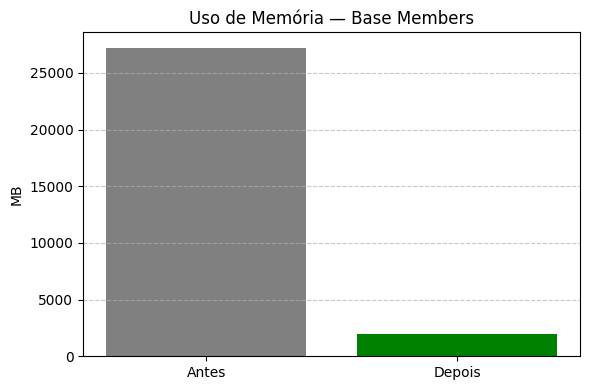

In [ ]:
# ================================
# COMPARATIVO DE MEMÓRIA: MEMBERS (ANTES VS DEPOIS DO TRATAMENTO)
# ================================

comparar_memoria(members_raw, members, nome_base="members")

In [ ]:
# ================================
# ESTATÍSTICAS DESCRITIVAS POR TIPO DE VARIÁVEL
# ================================

# → Variáveis contínuas (idade)
cols_cont = ['bd']
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(members[cols_cont].describe())

# → Variáveis binárias
cols_bin = ['is_ativo']
for col in cols_bin:
    print(f"\n{col}:\n{members[col].value_counts(normalize=True).rename('proportion')}")

# → Datas
print("\nJanela temporal de cadastro:")
print(f"registration_init_time: {members['registration_init_time'].min()} → {members['registration_init_time'].max()}")

# → Safra como partição (valor anômico)
print("\nSafras disponíveis:")
print(members['safra'].value_counts().sort_index())

# → Categorias com poucos valores únicos
print("\nregistered_via:")
print(members['registered_via'].value_counts().head(10))

print("\ncity:")
print(members['city'].value_counts().head(10))

print("\ngender:")
print(members['gender'].value_counts())

# Limpa variáveis temporárias
del col, cols_cont, cols_bin


,bd
count,"24,287,248.00"
mean,29.73
std,10.46
min,10.00
25%,22.00
50%,27.00
75%,35.00
max,100.00



is_ativo:
is_ativo
0    0.823965
1    0.176035
Name: proportion, dtype: float64

Janela temporal de cadastro:
registration_init_time: 2004-03-26 00:00:00 → 2016-12-31 00:00:00

Safras disponíveis:
safra
201601    4294184
201602    4502354
201603    4697972
201604    4876301
201605    5060705
201606    5250064
201607    5439337
201608    5615921
201609    5778986
201610    5949288
201611    6114345
201612    6287789
Name: count, dtype: int64

registered_via:
registered_via
4     19648219
3     18640987
9     16776651
7      8407395
11      269614
8        47588
5        18715
2        16847
16       10564
13        7546
Name: count, dtype: int64

city:
city
1     41955263
5      4271348
13     3650065
4      2730740
22     2328925
15     2123349
6      1492818
14     1004416
12      740584
9       538369
Name: count, dtype: int64

gender:
gender
unknown    38210177
male       13075425
female     12581644
Name: count, dtype: int64


### Observações iniciais da base `members` (com base nas estatísticas descritivas)

- `bd`: os valores de idade aparentam estar concentrados entre 20 e 35 anos, com média de 29.73. Apesar do dicionário indicar a presença de outliers extremos (entre -7000 e 2015), após os tratamentos iniciais, os dados disponíveis ficaram dentro de um intervalo plausível (mínimo: 10, máximo: 100), o que sugere que outliers já foram filtrados ou removidos anteriormente.

- `is_ativo`: a distribuição mostra que aproximadamente 82% dos usuários estão inativos (`0`), contra 18% ativos (`1`). Isso sugere um forte desbalanceamento, que pode estar relacionado a churn ou desengajamento. Ainda não é possível afirmar se essa variável será usada como `target`, mas a proporção merece atenção para análises futuras.

- `registration_init_time`: a base cobre um longo período de cadastro, desde 2004 até o final de 2016, embora a maior parte dos registros pareça mais recente. A variável foi convertida corretamente para `datetime`, o que facilitará segmentações temporais ou análise de cohort.

- `safra`: segue o padrão de partição mensal no formato `AAAAMM`, com 12 períodos únicos. Pode ser útil para análises por janela de tempo ou como feature auxiliar em junções.

- `registered_via` e `city`: possuem baixa cardinalidade e distribuição bastante concentrada, com poucos códigos representando a maioria dos registros. Podem ser tratadas como variáveis categóricas otimizadas (`category`), com potencial para uso em segmentações.

- `gender`: apesar de conter a classe `None`, os valores estão bem divididos entre `male` e `female`, o que permite o uso como variável categórica após tratamento adequado de nulos.

Essas observações ainda não são conclusivas, mas ajudam a direcionar os próximos passos exploratórios e a preparação de features.


In [ ]:
# ================================
# Verificação: registration_init_time é fixo por msno?
# ================================

# Conta quantas datas distintas de registro cada msno tem
clientes_com_varias_datas = (
    members.groupby("msno")["registration_init_time"]
    .nunique()
    .reset_index(name="qtde_datas_distintas")
)

# Filtra os msnos com mais de uma data
clientes_inconsistentes = clientes_com_varias_datas[clientes_com_varias_datas["qtde_datas_distintas"] > 1]

print(f"Total de clientes com datas diferentes de registro: {len(clientes_inconsistentes)}")

# Visualiza exemplos reais (opcional)
exemplos = (
    members[members["msno"].isin(clientes_inconsistentes["msno"])]
    .sort_values(["msno", "safra"])[["msno", "safra", "registration_init_time"]]
)

display(exemplos.head(20))


Total de clientes com datas diferentes de registro: 0


,msno,safra,registration_init_time


###VERIFICAÇÃO DE CONSISTÊNCIA: REPETIÇÕES DE CLIENTES NA BASE 'members' - Código comentado

In [ ]:
# ================================
# VERIFICAÇÃO DE CONSISTÊNCIA: REPETIÇÕES DE CLIENTES NA BASE 'members'
# ================================
# Este bloco foi mantido comentado por questões de performance, pois processa mais de 60 milhões de linhas.
# Ele valida a granularidade da base `members`, confirmando que:
# - Cada linha representa uma combinação única de cliente + mês (sem duplicatas no mesmo mês)
# - A safra não altera essa granularidade
# A análise já foi realizada e os outputs estão registrados no notebook para consulta.

# # → Total de linhas na base
# total_linhas = len(members)

# # → Quantidade de clientes distintos (msno)
# clientes_unicos = members['msno'].nunique()

# # → Quantidade de combinações únicas msno + safra
# combinacoes_msno_safra = members.drop_duplicates(subset=['msno', 'safra']).shape[0]

# # → Quantidade de combinações únicas msno + ano_mes_cadastro
# members['ano_mes_cadastro'] = members['registration_init_time'].dt.to_period('M')
# combinacoes_msno_mes = members.drop_duplicates(subset=['msno', 'ano_mes_cadastro']).shape[0]

# # → Distribuição de linhas por cliente
# distribuicao_linhas = members['msno'].value_counts().value_counts().sort_index()

# # → Impressão dos resultados
# print(f"Total de linhas na base: {total_linhas:,}")
# print(f"Número de clientes únicos (msno): {clientes_unicos:,}")
# print(f"Número de combinações únicas msno + safra: {combinacoes_msno_safra:,}")
# print(f"Número de combinações únicas msno + ano_mês_cadastro: {combinacoes_msno_mes:,}")
# print("\nDistribuição de registros por cliente (quantas linhas por msno):")
# print(distribuicao_linhas.head(10))

# # Limpa variáveis e coluna temporária
# del total_linhas, clientes_unicos, combinacoes_msno_safra, combinacoes_msno_mes, distribuicao_linhas
# members.drop(columns=['ano_mes_cadastro'], inplace=True)

### Análise de granularidade da base `members` (validação da estrutura por cliente e mês)

- A base possui **63.867.246 linhas**, mas apenas **6.287.789 clientes únicos** (`msno`), indicando múltiplos registros por cliente ao longo do tempo.

- A combinação `msno + ano_mês_cadastro` também possui **6.287.789 registros únicos**, o que confirma que **não há duplicidade** de cliente dentro de um mesmo mês de cadastro.

- Por outro lado, a combinação `msno + safra` gera exatamente o total de linhas da base. Isso sugere que cada linha representa um **snapshot mensal** da situação de cada cliente — reforçando que a granularidade da base é **cliente + safra**.

- A distribuição de registros por cliente mostra que muitos usuários aparecem de 1 até 10 vezes ao longo da base, sendo os volumes mais comuns entre 5 e 10 aparições mensais.

Essas validações reforçam o entendimento da estrutura do dataset e ajudam a guiar as decisões sobre agregações, janela temporal e modelagem futura.

##1.3 TRATAMENTOS BASE USER LOGS

In [ ]:
# Visualização User Logs
user_logs.head()

,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,SwlrSivYHoKF9V5wm1YYYAnjHpd9y3OPjI9rDUhGJ3k=,201701,121.0,28.0,14.0,29.0,704.0,827.0,184606.903
1,rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=,201605,26.0,2.0,5.0,6.0,462.0,256.0,119439.485
2,hx+cyaQ/Jcdr/Z5foa/Cn0PXUzC/F7QO/NQvWQS1Qtc=,201611,161.0,71.0,49.0,34.0,668.0,891.0,204791.242
3,53QW6B70J23X2UCvxaaUppjyE0b6X9nzP79W4huZv+Q=,201502,37.0,9.0,3.0,9.0,408.0,447.0,101186.041
4,/0S1N/oRyxGLZlzxnW5rOjfo0ZAls9EH23ahuDNuqz8=,201506,205.0,49.0,23.0,21.0,225.0,489.0,69957.524


In [ ]:
# Visualizar infos customizadas DF
custom_info_mem(user_logs, show_memory=True)

[Resumo do DataFrame] → Total de linhas: 26,758,971

Coluna                    Valores Não Nulos    Tipo de Dado
------------------------------------------------------------
msno                      26,758,971           object
safra                     26,758,971           int32
num_25                    26,758,971           float64
num_50                    26,758,971           float64
num_75                    26,758,971           float64
num_985                   26,758,971           float64
num_100                   26,758,971           float64
num_unq                   26,758,971           float64
total_secs                26,758,971           float64

[Uso de Memória] → 4108.61 MB (deep=True)


### Primeiras observações da base `user_logs` (com base em `head()`, `info()` e dicionário)

- `msno`: hash identificador do usuário. Tipo `object`, alta cardinalidade. Deve ser convertido para `category` para reduzir memória e facilitar joins.

- `safra`: tipo `int32`, representa AAAAMM. Pode ser convertido para `category` se usado apenas para filtragem e agrupamento temporal.

- `num_25` a `num_100`: contagens de faixas de reprodução. São discretas, mas estão como `float64`. Verificar se contêm apenas inteiros não nulos para otimização com `int16` ou `int32`.

- `num_unq`: número de músicas únicas ouvidas. Mesmo tratamento dos campos acima.

- `total_secs`: duração total ouvida. Permanece como `float`, mas pode ser reduzido para `float32` após inspeção de nulos e outliers.

---

### Próximos passos

1. Validar ausência de nulos nas colunas `float64` (`isna().sum()`).
2. Verificar se contagens são todas inteiras (`(col % 1 == 0).all()`).
3. Avaliar outliers com `describe()` e `hist()` em `total_secs`.
4. Aplicar conversões otimizadas: `category`, `int16`, `float32`.

In [ ]:
# ================================
# VALIDAÇÃO GERAL DOS VALORES DAS COLUNAS (ANTES DE CONVERTER) — BASE USER_LOGS
# ================================

validar_colunas(user_logs, nome_base="user_logs")


Coluna: msno
msno
QvXqW2TqBE0Ukupdp6QJediG3uoo94HOj5T136PKLHs=    26
OcabHa586q7FoK/OSjgSF8XuxvDro73CWTMiAUTVoUo=    26
5hWyvr5eeUQ3GCgYVSghEj8xJHjMioMbLg5TRKlkI4w=    26
1GhjhSDnTdXh2IEJtstqjMqGK6yJ/ffD3Qu6JqtHf9k=    26
tk+sJiTsmk4sADXX6JRRX/7l88qTlPDa7e6me26//08=    26
o0plfVVRFXZ8HhyyhaQ53cLKYKYHhLbQgJbS+8fGZIk=    26
oYrxFRzbSjMD44TPWOtr+jXJkHmRXB5fXjA1W8gMquQ=    26
D4mKiGSqsGOAm0x08tvpt97MUG8REC9MdVcpDwb6X10=    26
GEvxiCaorczTLPbnQtMX2YiAT99gMYhibd8UA+HtC8E=    26
GpiVlH5xNJMA0i1lZKkfWzwDd4DZNV93R+QuEzoKaAI=    26
Name: count, dtype: int64
→ Coluna não contém valores numéricos válidos.

Coluna: safra
safra
201611    1183088
201610    1139089
201701    1136003
201612    1135573
201702    1114164
201609    1112601
201608    1103078
201607    1102807
201606    1081181
201601    1076712
Name: count, dtype: int64
→ Mínimo numérico detectado: 201501
→ Máximo numérico detectado: 201702
→ Quantidade de valores únicos: 26
→ Tipo numérico identificado: todos inteiros

Coluna: num_25
num

In [ ]:
# ================================
# TRATAMENTO DE TIPOS - BASE USER_LOGS
# ================================

# Conversão de tipos categóricos
user_logs['msno'] = user_logs['msno'].astype('category')
user_logs['safra'] = user_logs['safra'].astype('category')

# Conversão das colunas de contagem — otimizado por faixa
user_logs['num_25'] = user_logs['num_25'].astype('int32')    # até 111864
user_logs['num_100'] = user_logs['num_100'].astype('int32')  # até 196741

# As demais cabem em int16
for col in ['num_50', 'num_75', 'num_985', 'num_unq']:
    user_logs[col] = user_logs[col].astype('int16')

# total_secs tem decimais e outliers extremos → manter como float32
user_logs['total_secs'] = user_logs['total_secs'].astype('float32')

Memória antes (user_logs): 4108.61 MB
Memória depois (user_logs): 1271.14 MB
Redução: 2837.47 MB (69.06%)


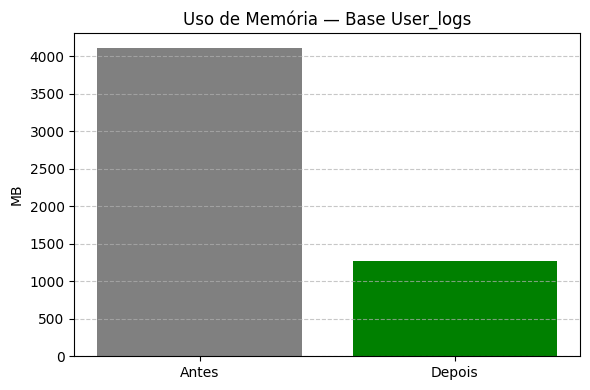

In [ ]:
# ================================
# COMPARATIVO DE MEMÓRIA: USER_LOGS (ANTES VS DEPOIS DO TRATAMENTO)
# ================================

comparar_memoria(user_logs_raw, user_logs, nome_base="user_logs")

In [ ]:
# ================================
# VALIDAÇÃO DE UNICIDADE POR CLIENTE E SAFRA
# ================================

# Gera contagens por safra
df_check = (
    user_logs
    .groupby('safra')
    .agg(
        msno_nunique=('msno', 'nunique'),       # Quantidade de clientes distintos
        linhas_totais=('msno', 'count')         # Total de linhas na base
    )
    .assign(
        unico_por_espec=lambda df: (df['msno_nunique'] == df['linhas_totais']).astype(int)  # Valida se há apenas uma linha por cliente
    )
    .sort_index()
)

# Verifica se há duplicidade de msno por safra
duplicadas = df_check[df_check['unico_por_espec'] == 0]

# Output do resultado
if duplicadas.empty:
    print("Cada cliente (`msno`) aparece apenas uma vez por safra.")
else:
    print("Foram encontradas duplicidades de clientes em algumas safras:")
    display(duplicadas)

# Libera memória
del df_check, duplicadas

Cada cliente (`msno`) aparece apenas uma vez por safra.


In [ ]:
# ================================
# VERIFICAÇÃO DE CONTINUIDADE ENTRE SAFRAS
# ================================

# 1. Verifica quantas safras diferentes cada cliente aparece
clientes_safras = (
    user_logs
    .groupby('msno')['safra']
    .nunique()
    .reset_index(name='qtde_safras')
)

# 2. Filtra clientes que aparecem em mais de uma safra
clientes_multisafra = clientes_safras.query('qtde_safras > 1')

# 3. Calcula percentual de clientes contínuos
perc_multisafra = (len(clientes_multisafra) / user_logs['msno'].nunique()) * 100

# 4. Output resumido
print(f"Clientes únicos na base: {user_logs['msno'].nunique():,}")
print(f"Clientes presentes em mais de uma safra: {len(clientes_multisafra):,} ({perc_multisafra:.2f}%)")

# 5. Exemplo de cliente contínuo
exemplo_msno = clientes_multisafra['msno'].iloc[0]
exemplo_detalhe = user_logs[user_logs['msno'] == exemplo_msno].sort_values('safra')

print(f"\nExemplo de cliente que aparece em múltiplas safras: {exemplo_msno}")
display(exemplo_detalhe.head(4))

# 6. Libera memória
del clientes_safras, clientes_multisafra, exemplo_detalhe


Clientes únicos na base: 5,234,111
Clientes presentes em mais de uma safra: 2,293,336 (43.82%)

Exemplo de cliente que aparece em múltiplas safras: +++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=


,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1173800,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,201501,16,8,14,8,1831,1472,446494.562500
17686478,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,201502,23,11,1,5,775,551,186845.890625
22536261,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,201503,30,24,15,13,3899,3512,960257.625000
17953655,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,201504,13,12,7,8,3561,3184,879930.312500


### Validação de continuidade e estrutura temporal do `user_logs`

Para entender a granularidade e o comportamento dos dados ao longo do tempo, investigamos se os registros de um mesmo cliente (`msno`) são acumulativos ou representam snapshots mensais independentes.

**Etapas executadas:**
- Contamos quantas safras distintas cada cliente aparece.
- Selecionamos clientes com presença em múltiplas safras.
- Inspecionamos um caso real, ordenando os registros por safra.
- Verificamos a variação de métricas como `num_25`, `num_100`, `total_secs`, etc.

**Conclusões empíricas:**
- Os valores dessas métricas **não crescem progressivamente** ao longo dos meses.
- Há **variações de aumento e diminuição**, o que indica que os dados **não são acumulativos**.
- Cada linha da base representa **o comportamento do cliente naquele mês específico**, ou seja, são **recortes mensais independentes**.

**Implicações para o projeto:**
- A modelagem pode tratar cada cliente-safra como uma **instância independente**, sem necessidade de reconstruir histórico acumulado.
- Caso queiramos explorar padrões temporais (tendência, queda de engajamento), será necessário **criar manualmente features de comparação entre safras** (lags, deltas, etc.).

Essa validação garante que a abordagem de modelagem seja compatível com a natureza real dos dados e evita suposições incorretas sobre o comportamento do cliente ao longo do tempo.


#2. CRIAÇÃO DO TARGET

##2.1 — Preparar base `members` com status atual e futuro

In [ ]:
# ================================
# Enriquecimento com is_ativo em t+3 — BASE MEMBERS
# ================================

# 1. Preparar base auxiliar com msno, safra e is_ativo
df_churn = members[['msno', 'safra', 'is_ativo']].copy()

# 2. Converter 'safra' para datetime (1º dia do mês)
df_churn['safra'] = pd.to_datetime(df_churn['safra'].astype(str), format='%Y%m') + pd.offsets.MonthBegin(0)
df_churn['safra_plus3'] = df_churn['safra']

# 3. Retroagir a safra em 3 meses (visão futura de is_ativo)
df_churn['safra'] = df_churn['safra'] + pd.DateOffset(months=-3)


In [ ]:
df_churn.head()

,msno,safra,is_ativo,safra_plus3
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2016-09-01,1,2016-12-01
1,++/AwGzubug3gT6J+0STBGMdWKxaM+UFZTI8Tcmq4To=,2016-04-01,0,2016-07-01
2,++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=,2015-10-01,1,2016-01-01
3,++02XbtviomSxcIBUHMOiJkjRxdicTXSfiVqLdsr5lo=,2015-12-01,0,2016-03-01
4,++0O0Bq04sB/9ZcOS+pajpYL2Hin9jCqnc/8bKzKFuE=,2016-07-01,0,2016-10-01


##2.2 — Preparar base de `transactions` com cancelamentos

In [ ]:
# Filtro em transactions apenas em cancelamentos
trans_cancel = transactions.loc[transactions['is_cancel'] == 1, ['msno', 'safra', 'is_cancel']].copy()

# Converter 'safra' para datetime (1º dia do mês)
trans_cancel['safra'] = pd.to_datetime(trans_cancel['safra'].astype(str), format='%Y%m') + pd.offsets.MonthBegin(0)

# Restringir o intervalo de datas de interesse no df_target
safra_min = df_churn['safra'].min()
safra_max = df_churn['safra_plus3'].max()

trans_cancel = trans_cancel[
    (trans_cancel['safra'] >= safra_min) &
    (trans_cancel['safra'] <= safra_max)
]

##2.3 Preparação do df_churn (target)

In [ ]:
# Merge entre df_churn e trans_cancel apenas por msno
df_merged = df_churn.merge(
    trans_cancel,
    on='msno',
    how='left',
    suffixes=('', '_trans')
)

# Validação do volume antes e depois do merge
print("Linhas no df_churn original:", len(df_churn))
print("Linhas após o merge        :", len(df_merged))

# Limpa memória
del trans_cancel, safra_min, safra_max

Linhas no df_churn original: 63867246
Linhas após o merge        : 64001577


In [ ]:
df_merged[df_merged['safra_trans'].notna()].head()

,msno,safra,is_ativo,safra_plus3,safra_trans,is_cancel
38,++FnMnrvTvIQmK5WWsmBOd1JYCWHmOmSg3JtXa+o1G8=,2016-09-01,0,2016-12-01,2016-08-01,1.0
77,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2016-07-01,1,2016-10-01,2015-11-01,1.0
82,++YZtc+IIAV73+j+RjyCFmFVPnN2jyXTGw3lehYJ5zA=,2016-01-01,0,2016-04-01,2015-11-01,1.0
111,++j2SYmpLBS0CgzyaQgw+Ex2KIBEOGzg6esVjJzFNkY=,2016-08-01,1,2016-11-01,2016-02-01,1.0
112,++k/O0nt+xxDl8pz4k+5tc5wWYiuzT8uE3GVWb+1tRI=,2015-10-01,0,2016-01-01,2015-12-01,1.0


In [ ]:
df_merged[df_merged['msno'] == '++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ='].sort_values('safra')

,msno,safra,is_ativo,safra_plus3,safra_trans,is_cancel
33921727,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2015-10-01,0,2016-01-01,2015-11-01,1.0
9601459,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2015-11-01,1,2016-02-01,2015-11-01,1.0
44158966,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2015-12-01,1,2016-03-01,2015-11-01,1.0
51839002,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2016-01-01,1,2016-04-01,2015-11-01,1.0
16001247,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2016-02-01,1,2016-05-01,2015-11-01,1.0
27522827,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2016-03-01,1,2016-06-01,2015-11-01,1.0
20482471,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2016-04-01,1,2016-07-01,2015-11-01,1.0
14719513,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2016-05-01,1,2016-08-01,2015-11-01,1.0
42238842,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2016-06-01,1,2016-09-01,2015-11-01,1.0
77,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2016-07-01,1,2016-10-01,2015-11-01,1.0


In [ ]:
# Filtro das transações que ocorreram na janela de churn
# Lógica: considerar cancelamentos que aconteceram *após* a safra retroagida
# e *até* o mês que foi usado para definir o is_ativo (inclusivo)

df_merged_filtrado = df_merged[
    (df_merged['safra_trans'] > df_merged['safra']) &         # Exclui o mês retroagido
    (df_merged['safra_trans'] <= df_merged['safra_plus3'])    # Inclui o 3º mês à frente (mesmo usado em is_ativo)
]

# Validação do resultado
print("Linhas após aplicar a janela correta de 3 meses:", len(df_merged_filtrado))

# Limpa memória
del df_merged

Linhas após aplicar a janela correta de 3 meses: 628999


In [ ]:
df_merged_filtrado[df_merged_filtrado['msno'] == '++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ='].sort_values('safra')

,msno,safra,is_ativo,safra_plus3,safra_trans,is_cancel
33921727,++XqYJpQ5yPZYUhDJCS4REf2X9ip0y0cDQmE7neOSkQ=,2015-10-01,0,2016-01-01,2015-11-01,1.0


In [ ]:
# Agrupa as transações filtradas para criar a flag de cancelamento na janela
# Como todas as linhas têm is_cancel = 1, o max() serve apenas para consolidar múltiplas transações
cancel_flag = (
    df_merged_filtrado
    .groupby(['msno', 'safra'], observed=True)['is_cancel']
    .max()
    .reset_index()
    .rename(columns={'is_cancel': 'is_cancel_plus3'})
)

# Junta a flag no df_churn (base principal com safra retroagida)
df_churn = df_churn.merge(cancel_flag, on=['msno', 'safra'], how='left')

# Preenche os NaNs com 0 → indica que o cliente não cancelou na janela de 3 meses
df_churn['is_cancel_plus3'] = df_churn['is_cancel_plus3'].fillna(0).astype(int)

# Limpa memória
del df_merged_filtrado, cancel_flag

In [ ]:
len(df_churn)

63867246

In [ ]:
# Regra:
# - Se cancelou na janela → churn
# - Senão → olha o is_ativo do 3º mês à frente:
#     - is_ativo == 0 → churn
#     - is_ativo == 1 → não churn

df_churn['is_churn'] = np.where(
    df_churn['is_cancel_plus3'] == 1,
    1,
    np.where(df_churn['is_ativo'] == 0, 1, 0)
)

In [ ]:
# Converter safra de transactions para string YYYYMM
transactions['safra'] = transactions['safra'].astype(str)

# Voltar safra do df_churn para o formato YYYYMM pois estava em formato de data prmeiro dia do mes
df_churn['safra'] = df_churn['safra'].dt.strftime('%Y%m')

# Deixar no df_churn apenas as combinações de msno e safra existente em transactions
df_churn = df_churn.merge(
    transactions[['msno', 'safra']].drop_duplicates(),
    on=['msno', 'safra'],
    how='inner'
)


In [ ]:
df_churn.head()

,msno,safra,is_ativo,safra_plus3,is_cancel_plus3,is_churn
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201609,1,2016-12-01,0,0
1,++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=,201604,1,2016-07-01,0,0
2,++CzVs35NSfU/gjDrGbWLVMweubEiMZsuvd3eTbXs58=,201602,1,2016-05-01,0,0
3,++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=,201608,1,2016-11-01,0,0
4,++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=,201609,1,2016-12-01,0,0


In [ ]:
# Total de linhas e proporcao de churn df_churn
print("Linhas em df_churn:", len(df_churn))

# Calcular a proporção de churn e não churn apenas entre esses clientes com transação
proporcao_churn = (
    df_churn['is_churn']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .astype(str) + '%'
)

# Mostrar o resultado
print("Proporção de churn (clientes com transações):")
print(proporcao_churn)

Linhas em df_churn: 8660552
Proporção de churn (clientes com transações):
is_churn
0    85.59%
1    14.41%
Name: proportion, dtype: object


In [ ]:
del proporcao_churn

In [ ]:
# Dropando colunas desnecessárias diretamente no df_churn
df_churn.drop(columns=['is_ativo', 'safra_plus3', 'is_cancel_plus3'], inplace=True)


In [ ]:
len(df_churn)

8660552

In [ ]:
# Merge para trazer todas as colunas do members para df_churn, mantendo apenas os msno+safra existentes nos dois
df_churn = df_churn.merge(
    members[['msno', 'registration_init_time', 'city', 'bd', 'gender', 'registered_via']].drop_duplicates(),
    on=['msno'],
    how='inner'
)

In [ ]:
len(df_churn)

8660552

In [ ]:
# Total de linhas e proporcao de churn df_churn
print("Linhas em df_churn:", len(df_churn))

# Calcular a proporção de churn e não churn apenas entre esses clientes com transação
proporcao_churn = (
    df_churn['is_churn']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .astype(str) + '%'
)

# Mostrar o resultado
print("Proporção de churn (clientes com transações):")
print(proporcao_churn)

Linhas em df_churn: 8660552
Proporção de churn (clientes com transações):
is_churn
0    85.59%
1    14.41%
Name: proportion, dtype: object


In [ ]:
del proporcao_churn

#CHECKPOINT

In [ ]:
# # Caminho de salvamento
save_path = os.path.join(base_dir, 'data')

# # Salvar versões tratadas em formato .parquet com nomes diferentes
df_churn.to_parquet(os.path.join(save_path, 'df_churn.parquet'), index=False)
# members.to_parquet(os.path.join(save_path, 'members_tratado.parquet'), index=False)
# user_logs.to_parquet(os.path.join(save_path, 'user_logs_tratado.parquet'), index=False)
# transactions.to_parquet(os.path.join(save_path, 'transactions_tratado.parquet'), index=False)

# print("Checkpoint em .parquet salvo com sucesso!")


In [ ]:
 # Leitura de dados CheckPoint
 df_churn = pd.read_parquet(os.path.join(base_dir, 'data', 'df_churn.parquet'))
 members = pd.read_parquet(os.path.join(base_dir, 'data', 'members_tratado.parquet'))
 user_logs = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_tratado.parquet'))
 transactions = pd.read_parquet(os.path.join(base_dir, 'data', 'transactions_tratado.parquet'))
 user_logs_intervalados = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_intervalados.parquet'))

 print("Checkpoint restaurado com sucesso!")

Checkpoint restaurado com sucesso!


#3 Análise Exploratória (EDA)

##3.1 df_churn (target)

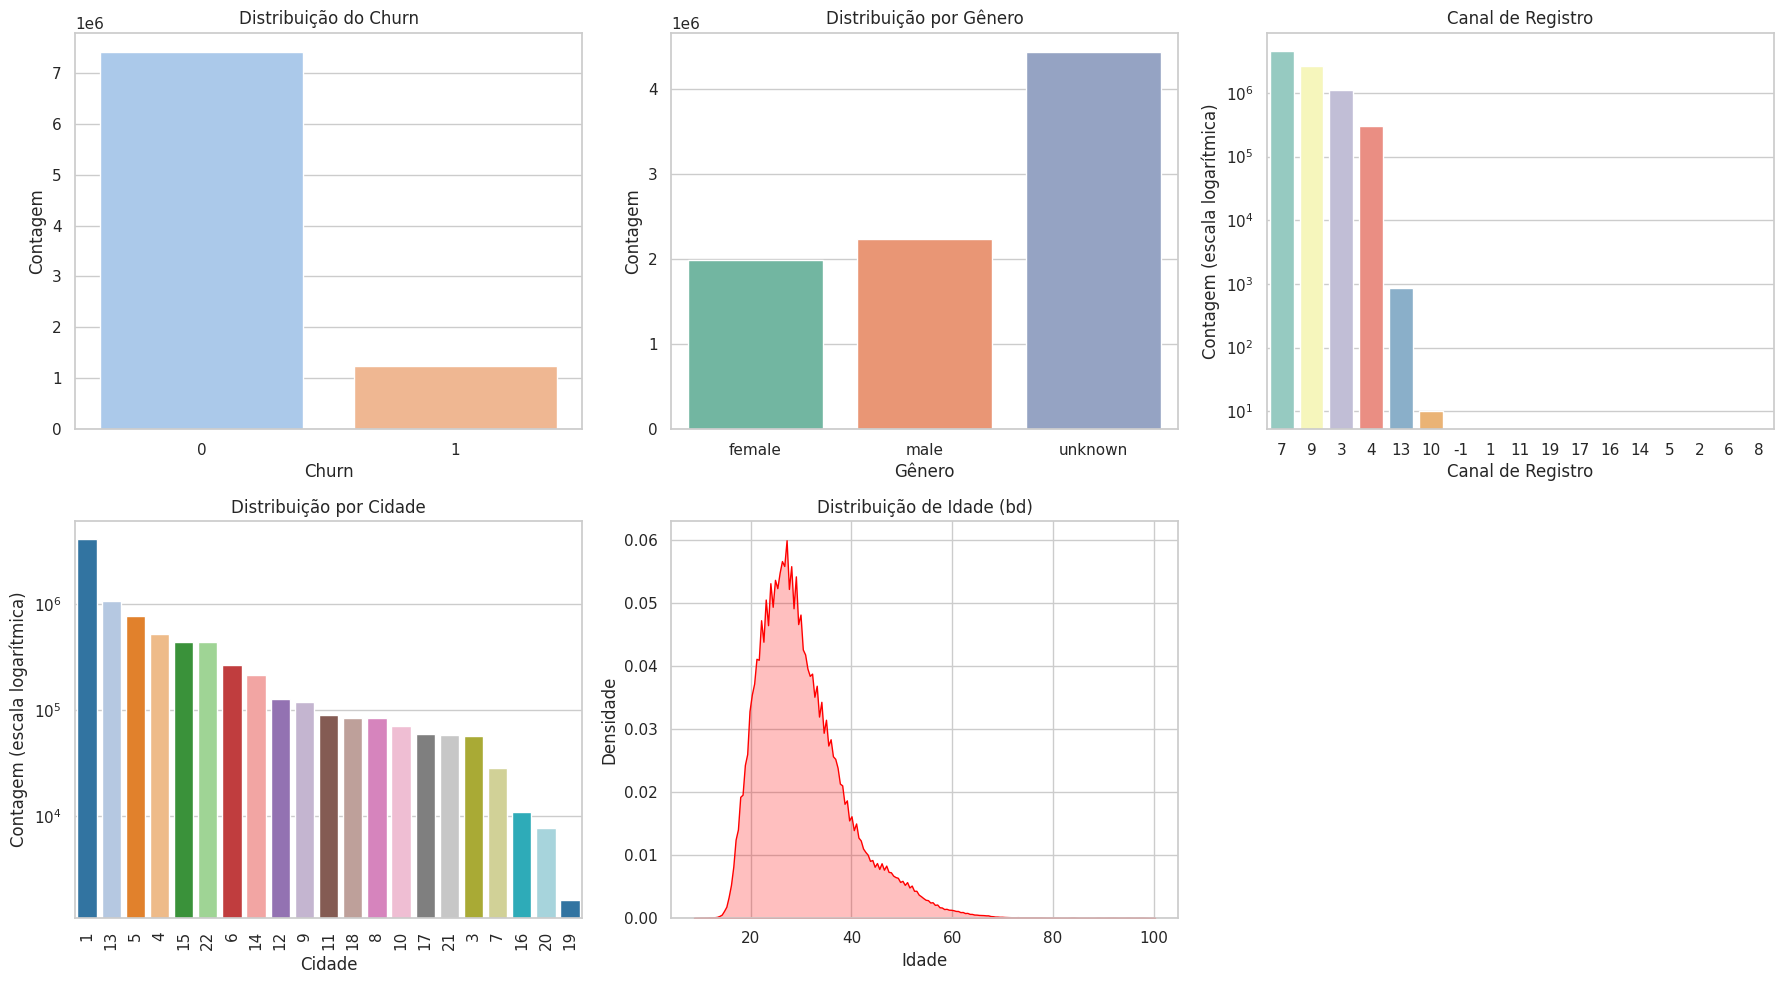

In [ ]:
# Define o estilo dos plots
sns.set(style="whitegrid")
plt.figure(figsize=(18, 10))

# Plot 1 — Distribuição do churn
plt.subplot(2, 3, 1)
sns.countplot(x='is_churn', data=df_churn, palette='pastel')
plt.title("Distribuição do Churn")
plt.xlabel("Churn")
plt.ylabel("Contagem")

# Plot 2 — Distribuição por gênero
plt.subplot(2, 3, 2)
sns.countplot(x='gender', data=df_churn, palette='Set2')
plt.title("Distribuição por Gênero")
plt.xlabel("Gênero")
plt.ylabel("Contagem")

# Plot 3 — Canal de registro (registered_via) ordenado
plt.subplot(2, 3, 3)

order_reg = (
    df_churn['registered_via']
    .value_counts()
    .sort_values(ascending=False)
    .index
)

sns.countplot(x='registered_via', data=df_churn, order=order_reg, palette='Set3')
plt.yscale('log')  # Escala logarítmica
plt.title("Canal de Registro")
plt.xlabel("Canal de Registro")
plt.ylabel("Contagem (escala logarítmica)")

# Plot 4 — Distribuição por cidade (ordenado por frequência desc)
plt.subplot(2, 3, 4)

order_city = (
    df_churn['city']
    .value_counts()            # conta
    .sort_values(ascending=False)  # ordena
    .index                     # pega a ordem dos rótulos
)

sns.countplot(x='city', data=df_churn, order=order_city, palette='tab20')
plt.yscale('log')  # Escala logarítmica
plt.title("Distribuição por Cidade")
plt.xlabel("Cidade")
plt.ylabel("Contagem (escala logarítmica)")
plt.xticks(rotation=90)

# Plot 5 — Densidade da idade (bd)
plt.subplot(2, 3, 5)
sns.kdeplot(
    data=df_churn[(df_churn['bd'] > 0) & (df_churn['bd'] < 100)],
    x='bd',
    fill=True,
    color='red',
    bw_adjust=1
)
plt.title("Distribuição de Idade (bd)")
plt.xlabel("Idade")
plt.ylabel("Densidade")

# Ajuste final do layout
plt.tight_layout()
plt.show()


###Observações Gerais

- 14% dos clientes são Churn;
- Apesar da maioria dos clientes não terem informado gênero, percebemos número relativamente maior de homens;
- Canais de registro mais utilizados:7, 9, 3, 4;
- Cidade com maior número de clientes: 1;
- Maior concentração de idade: 20 a 40 anos.


##3.2 Transactions

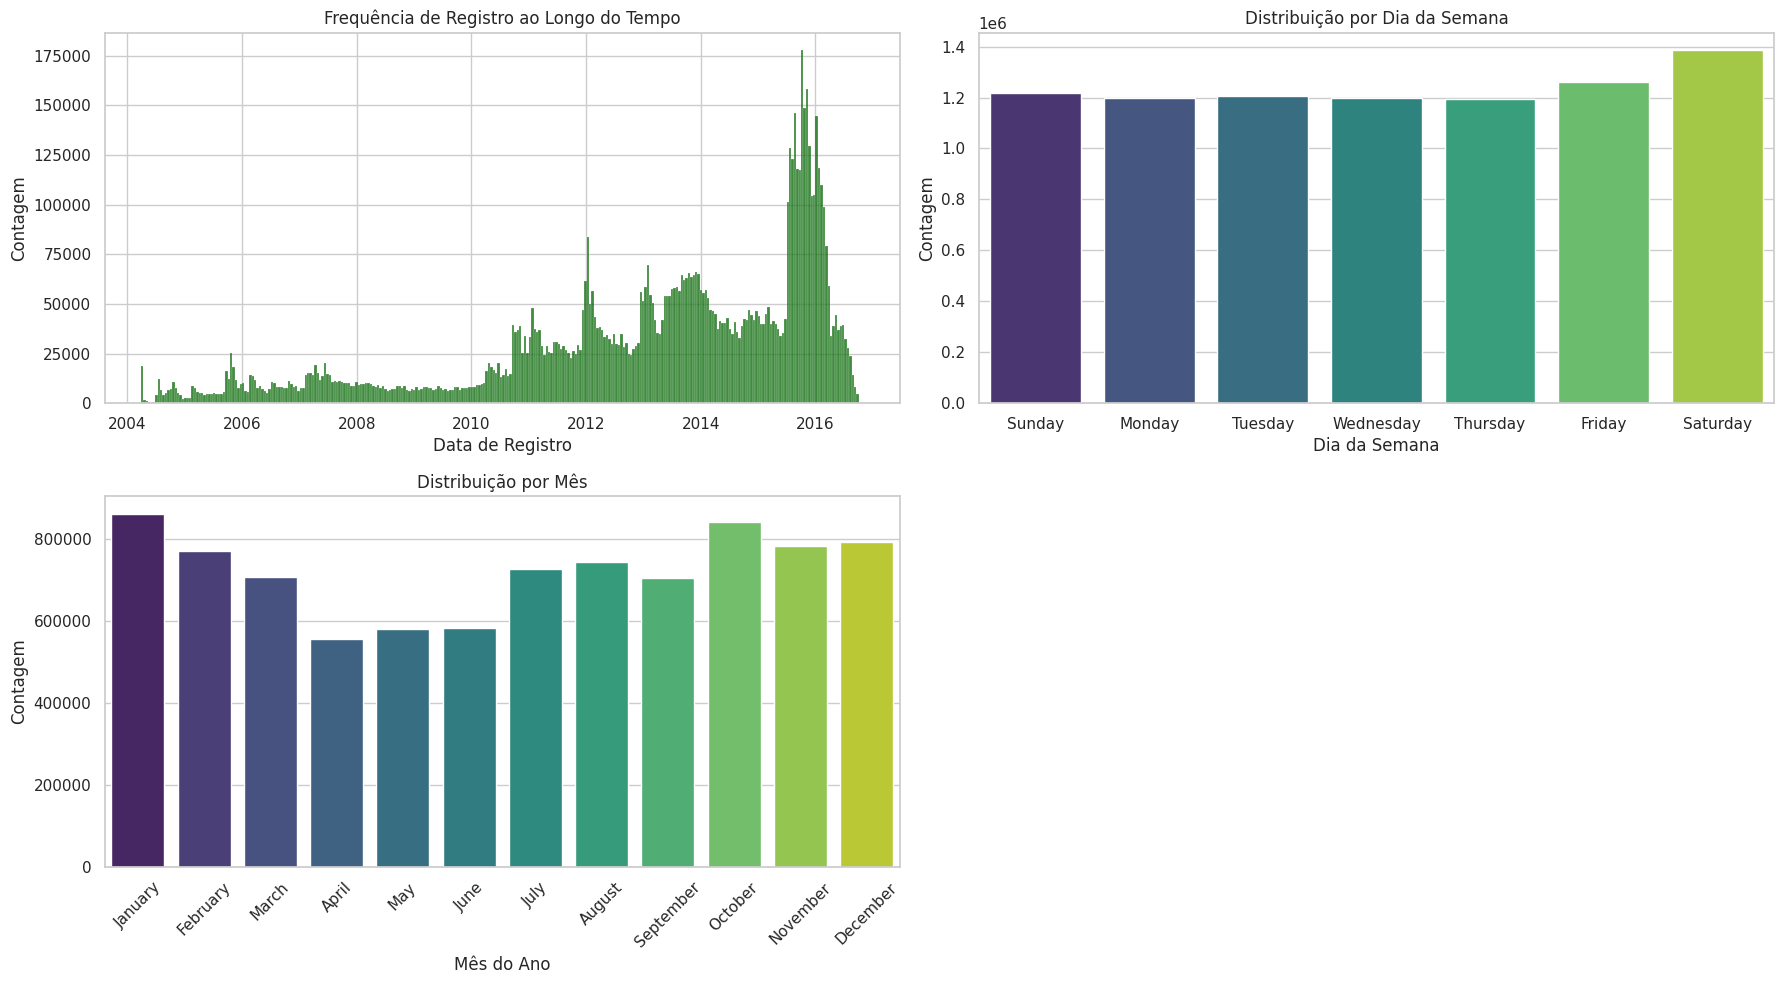

In [ ]:
# Garante o formato datetime
df_churn['registration_init_time'] = pd.to_datetime(df_churn['registration_init_time'])

# Cria novas colunas de dia da semana e mês (útil para os plots)
df_churn['reg_wday'] = df_churn['registration_init_time'].dt.day_name()
df_churn['reg_month'] = df_churn['registration_init_time'].dt.month_name()

# Define estilo
sns.set(style="whitegrid")
plt.figure(figsize=(18, 10))

# Plot 1 — Frequência de registros ao longo do tempo
plt.subplot(2, 2, 1)
sns.histplot(data=df_churn, x='registration_init_time', bins=300, color="darkgreen", stat='count', kde=False)
plt.title("Frequência de Registro ao Longo do Tempo")
plt.xlabel("Data de Registro")
plt.ylabel("Contagem")

# Plot 2 — Dia da semana de registro
plt.subplot(2, 2, 2)
order_wday = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.countplot(data=df_churn, x='reg_wday', order=order_wday, palette='viridis')
plt.title("Distribuição por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Contagem")

# Plot 3 — Mês do ano de registro
plt.subplot(2, 2, 3)
order_month = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
sns.countplot(data=df_churn, x='reg_month', order=order_month, palette='viridis')
plt.title("Distribuição por Mês")
plt.xlabel("Mês do Ano")
plt.ylabel("Contagem")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

###Observações gerais
- Percebemos um aumento significativo na quantidade de usuários a partir de 2010, com um aumento exponencial entre 2015 e 2016 - Esperado também um maior volume de churn;
- Distribuição uniforme de registros por dias da semana, com maior concentração nos finais de semana;
- Quanto aos meses do ano, observamos que a maior quantidade de registros se concentra de outubro a janeiro.

##3.3 User Logs

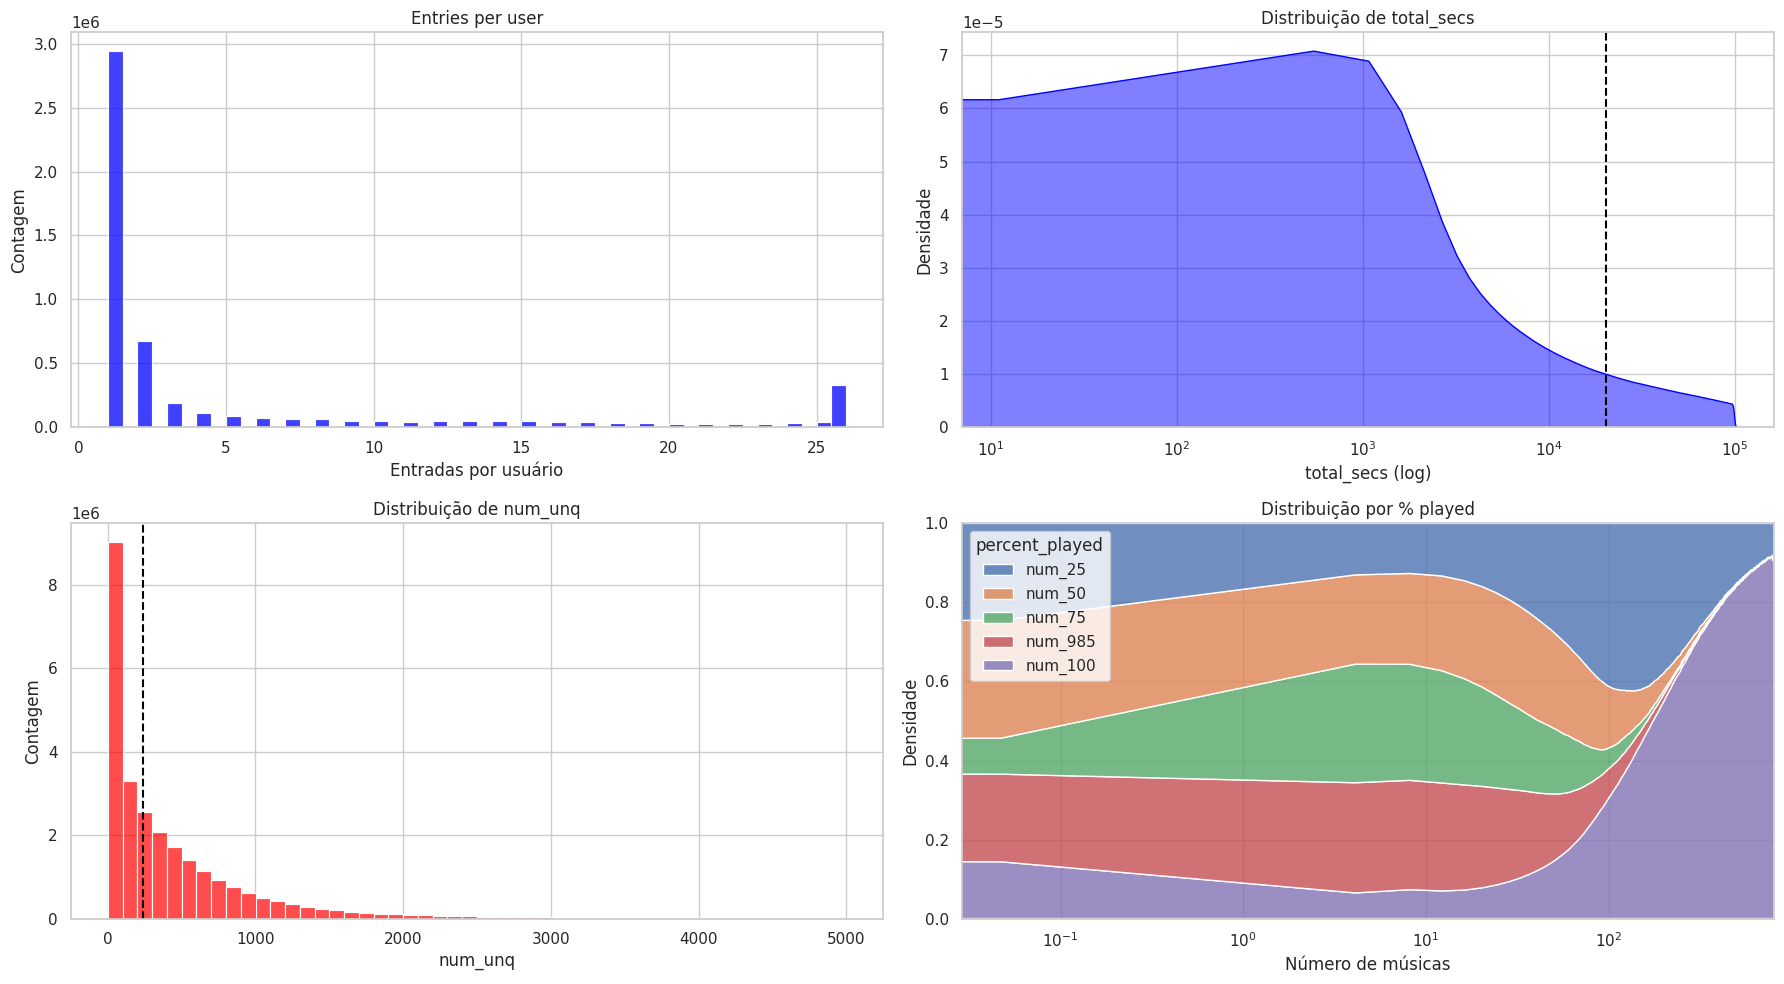

In [ ]:
# Configurações visuais
sns.set(style="whitegrid")
plt.figure(figsize=(18, 10))

# ======================
# Plot 1 — Entradas por usuário
# ======================
plt.subplot(2, 2, 1)
entries_per_user = user_logs['msno'].value_counts()
entries_per_user = entries_per_user[entries_per_user < 50]  # Filtra outliers extremos
sns.histplot(entries_per_user, bins=50, color='blue')
plt.xlabel("Entradas por usuário")
plt.ylabel("Contagem")
plt.title("Entries per user")

# ======================
# Plot 2 — total_secs (log)
# ======================
plt.subplot(2, 2, 2)
filtered_total_secs = user_logs[user_logs['total_secs'].abs() < 1e5]
sns.kdeplot(
    data=filtered_total_secs,
    x='total_secs',
    fill=True,
    color='blue',
    alpha=0.5
)
plt.axvline(filtered_total_secs['total_secs'].median(), linestyle='--', color='black')
plt.xscale('log')
plt.xlabel("total_secs (log)")
plt.title("Distribuição de total_secs")
plt.ylabel("Densidade")

# ======================
# Plot 3 — num_unq (log)
# ======================
plt.subplot(2, 2, 3)
sns.histplot(user_logs[user_logs['num_unq'] < 5000]['num_unq'], bins=50, color='red', alpha=0.7)
plt.axvline(user_logs['num_unq'].median(), linestyle='--', color='black')
# plt.xscale('log')
plt.xlabel("num_unq")
plt.ylabel("Contagem")
plt.title("Distribuição de num_unq")

# ======================
# Plot 4 — % played (log)
# ======================
plt.subplot(2, 2, 4)
df_melted = user_logs.melt(
    id_vars='msno',
    value_vars=['num_25', 'num_50', 'num_75', 'num_985', 'num_100'],
    var_name='percent_played',
    value_name='num_songs'
)

# Reordena as categorias
ordem = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100']
df_melted['percent_played'] = pd.Categorical(df_melted['percent_played'], categories=ordem, ordered=True)

# Remove zeros e limita valores extremos
df_melted = df_melted[(df_melted['num_songs'] > 0) & (df_melted['num_songs'] < 800)]

sns.kdeplot(
    data=df_melted,
    x='num_songs',
    hue='percent_played',
    multiple='fill',  # stack ou 'fill' para proporção relativa
    common_norm=False,
    bw_adjust=0.5,
    alpha=0.8
)
plt.xscale('log')
plt.xlabel("Número de músicas")
plt.ylabel("Densidade")
plt.title("Distribuição por % played")

# Finaliza layout
plt.tight_layout()
plt.show()

# Limpa variáveis temporárias
del entries_per_user, df_melted, filtered_total_secs, ordem

# CHECKPOINT

In [ ]:
# # Caminho de salvamento
save_path = os.path.join(base_dir, 'data')

# # Salvar versões tratadas em formato .parquet com nomes diferentes
df_churn.to_parquet(os.path.join(save_path, 'df_churn.parquet'), index=False)
# members.to_parquet(os.path.join(save_path, 'members_tratado.parquet'), index=False)
# user_logs.to_parquet(os.path.join(save_path, 'user_logs_tratado.parquet'), index=False)
# transactions.to_parquet(os.path.join(save_path, 'transactions_tratado.parquet'), index=False)

# print("Checkpoint em .parquet salvo com sucesso!")


#4 Relações com Churn

##4.1 Members x Churn

In [ ]:
df_churn.head()

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,reg_wday,reg_month
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201609,0,2014-09-27,1,<NA>,unknown,7,Saturday,September
1,++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=,201604,0,2007-06-09,15,29,male,9,Saturday,June
2,++CzVs35NSfU/gjDrGbWLVMweubEiMZsuvd3eTbXs58=,201602,0,2015-09-14,1,<NA>,unknown,7,Monday,September
3,++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=,201608,0,2012-06-05,1,<NA>,unknown,7,Tuesday,June
4,++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=,201609,0,2011-03-22,4,37,male,9,Tuesday,March


In [ ]:
custom_info_mem(df_churn, show_memory =True)

[Resumo do DataFrame] → Total de linhas: 8,660,552

Coluna                    Valores Não Nulos    Tipo de Dado
------------------------------------------------------------
msno                      8,660,552            object
safra                     8,660,552            object
is_churn                  8,660,552            int64
registration_init_time    8,660,552            datetime64[ns]
city                      8,660,552            category
bd                        4,200,476            Int16
gender                    8,660,552            category
registered_via            8,660,552            category
reg_wday                  8,660,552            object
reg_month                 8,660,552            object

[Uso de Memória] → 2589.18 MB (deep=True)


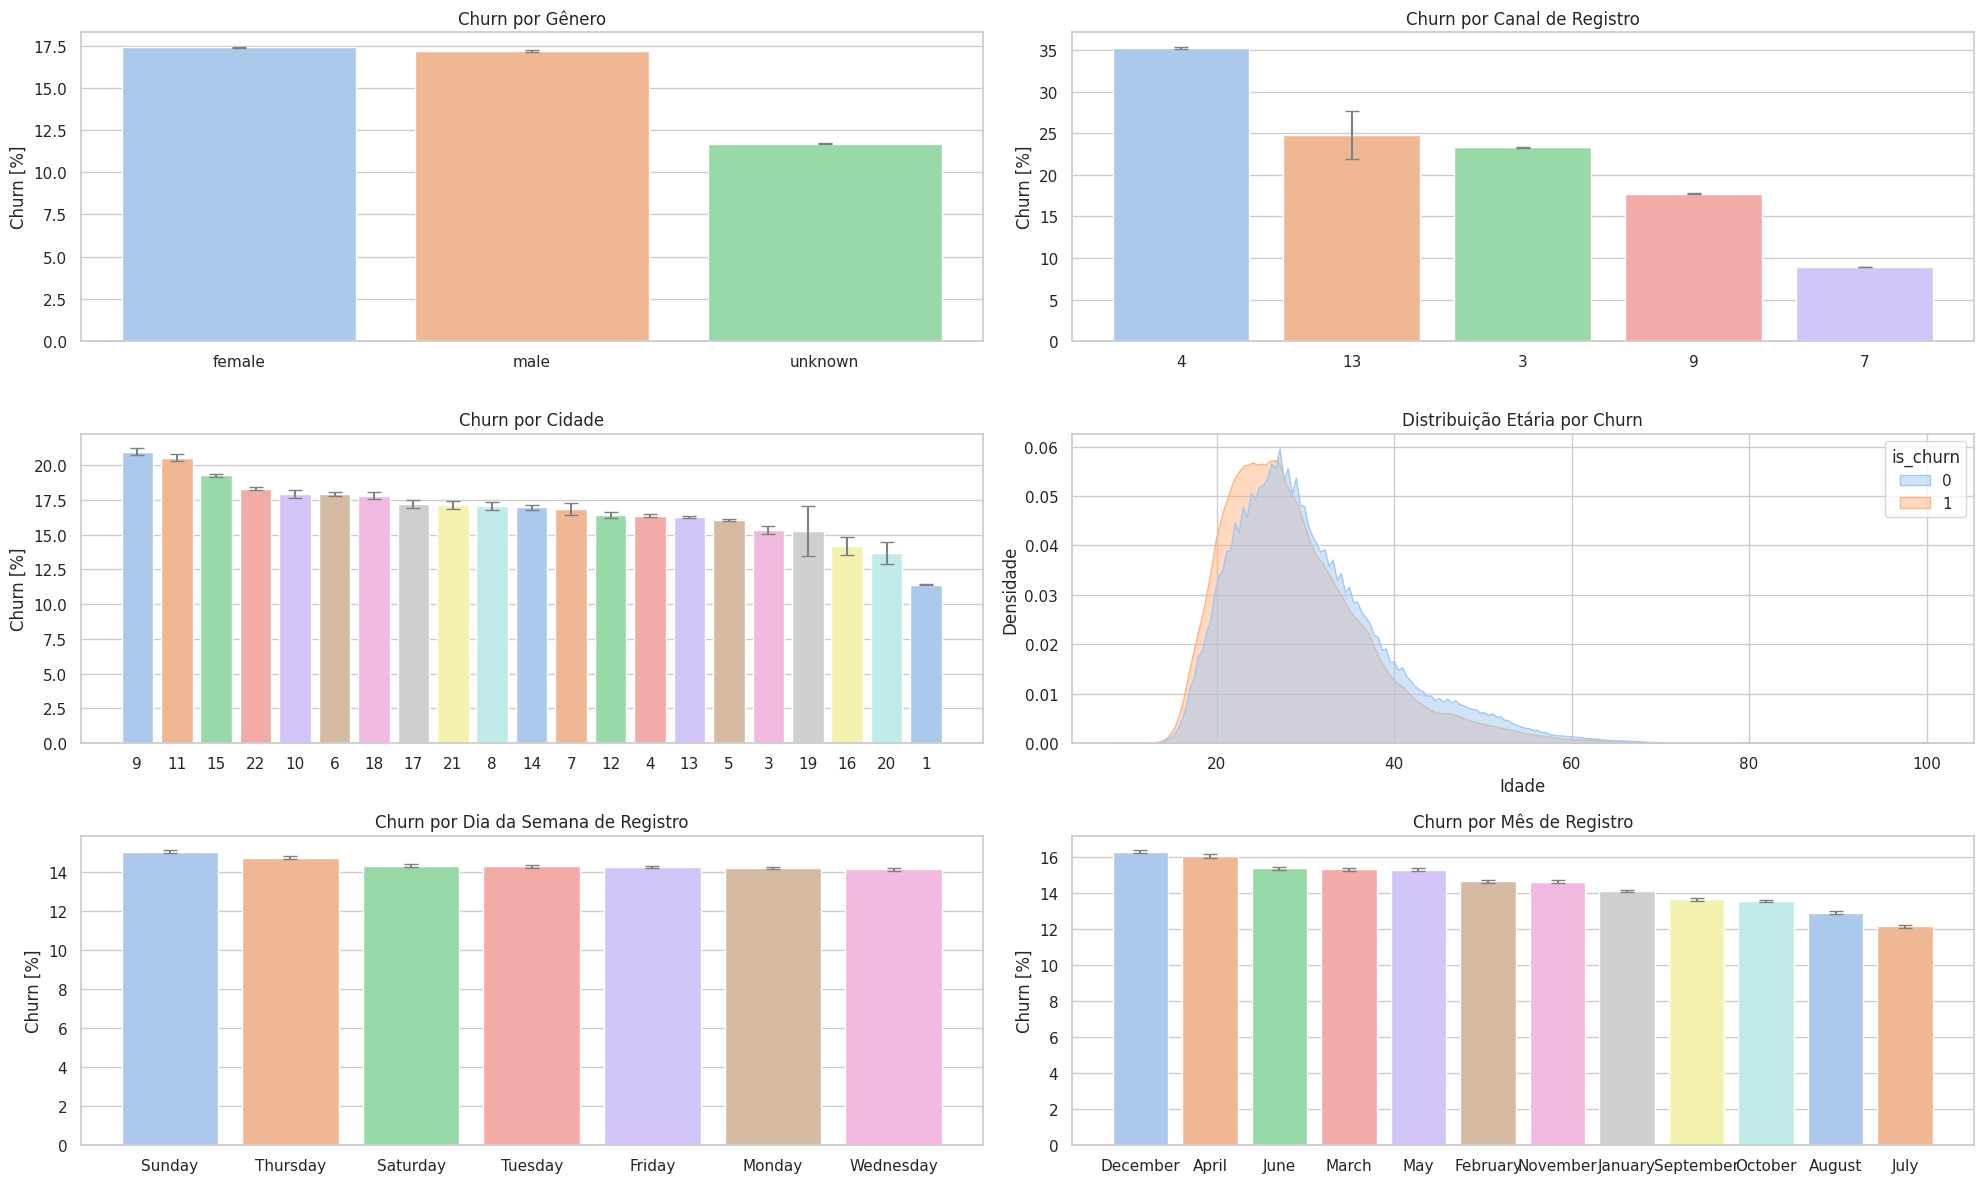

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
import numpy as np
import pandas as pd

# ========= AJUSTES PRÉVIOS =========
cat_cols = ['gender', 'registered_via', 'city', 'reg_wday', 'reg_month']
for col in cat_cols:
    df_churn[col] = df_churn[col].astype('category')

# Inicia figura única
plt.figure(figsize=(20, 12))

# ========= PLOT 1: GÊNERO =========
churn_gender = df_churn.groupby(['gender', 'is_churn']).size().unstack().fillna(0)
churn_gender['total'] = churn_gender.sum(axis=1)
churn_gender['churn_pct'] = churn_gender[1] / churn_gender['total'] * 100
churn_gender[['lwr', 'upr']] = churn_gender.apply(
    lambda row: pd.Series(np.array(binom.interval(0.95, int(row['total']), row[1]/row['total'])) / row['total'] * 100),
    axis=1
)

plt.subplot(3, 2, 1)
sns.barplot(x=churn_gender.index, y=churn_gender['churn_pct'], palette='pastel')
plt.errorbar(
    x=np.arange(len(churn_gender)),
    y=churn_gender['churn_pct'],
    yerr=[churn_gender['churn_pct'] - churn_gender['lwr'], churn_gender['upr'] - churn_gender['churn_pct']],
    fmt='none', c='gray', capsize=5
)
plt.title('Churn por Gênero')
plt.ylabel('Churn [%]')
plt.xlabel('')

# ========= PLOT 2: CANAL DE REGISTRO =========

df_churn['registered_via'] = df_churn['registered_via'].astype('int8')
df_plot = df_churn[df_churn['registered_via'] != 10].copy()

churn_reg = df_plot.groupby(['registered_via', 'is_churn']).size().unstack().fillna(0)
churn_reg['total'] = churn_reg.sum(axis=1)
churn_reg = churn_reg[churn_reg['total'] > 0]
churn_reg['churn_pct'] = churn_reg[1] / churn_reg['total'] * 100

churn_reg[['lwr', 'upr']] = churn_reg.apply(
    lambda row: pd.Series(
        np.array(binom.interval(0.95, int(row['total']), row[1]/row['total'])) / row['total'] * 100
    ),
    axis=1
)

churn_reg_sorted = churn_reg.sort_values('churn_pct', ascending=False).reset_index()

plt.subplot(3, 2, 2)
sns.barplot(
    x='registered_via',
    y='churn_pct',
    data=churn_reg_sorted,
    order=churn_reg_sorted['registered_via'].tolist(),  # força a ordem desejada
    palette='pastel'
)

plt.errorbar(
    x=np.arange(len(churn_reg_sorted)),
    y=churn_reg_sorted['churn_pct'],
    yerr=[
        churn_reg_sorted['churn_pct'] - churn_reg_sorted['lwr'],
        churn_reg_sorted['upr'] - churn_reg_sorted['churn_pct']
    ],
    fmt='none', c='gray', capsize=5
)

plt.title('Churn por Canal de Registro')
plt.ylabel('Churn [%]')
plt.xlabel('')

# ========= PLOT 3: CIDADE =========
churn_city = df_churn.groupby(['city', 'is_churn']).size().unstack().fillna(0)
churn_city['total'] = churn_city.sum(axis=1)
churn_city['churn_pct'] = churn_city[1] / churn_city['total'] * 100

churn_city[['lwr', 'upr']] = churn_city.apply(
    lambda row: pd.Series(
        np.array(binom.interval(0.95, int(row['total']), row[1]/row['total'])) / row['total'] * 100
    ),
    axis=1
)

# Ordena e reseta índice para usar com Seaborn
churn_city_sorted = churn_city.sort_values('churn_pct', ascending=False).reset_index()

plt.subplot(3, 2, 3)
sns.barplot(
    x='city',
    y='churn_pct',
    data=churn_city_sorted,
    order=churn_city_sorted['city'],
    palette='pastel'
)

plt.errorbar(
    x=np.arange(len(churn_city_sorted)),
    y=churn_city_sorted['churn_pct'],
    yerr=[
        churn_city_sorted['churn_pct'] - churn_city_sorted['lwr'],
        churn_city_sorted['upr'] - churn_city_sorted['churn_pct']
    ],
    fmt='none', c='gray', capsize=5
)

plt.title('Churn por Cidade')
plt.ylabel('Churn [%]')
plt.xlabel('')

# ========= PLOT 4: DISTRIBUIÇÃO DE IDADE =========
bd_df = df_churn[(df_churn['bd'] > 0) & (df_churn['bd'] < 100)]
plt.subplot(3, 2, 4)
sns.kdeplot(data=bd_df, x='bd', hue='is_churn', fill=True, common_norm=False, palette='pastel', alpha=0.5)
plt.title('Distribuição Etária por Churn')
plt.xlabel('Idade')
plt.ylabel('Densidade')

# ========= PLOT 5: DIA DA SEMANA =========
churn_wday = df_churn.groupby(['reg_wday', 'is_churn']).size().unstack().fillna(0)
churn_wday['total'] = churn_wday.sum(axis=1)
churn_wday['churn_pct'] = churn_wday[1] / churn_wday['total'] * 100

churn_wday[['lwr', 'upr']] = churn_wday.apply(
    lambda row: pd.Series(
        np.array(binom.interval(0.95, int(row['total']), row[1]/row['total'])) / row['total'] * 100
    ),
    axis=1
)

churn_wday_sorted = churn_wday.sort_values('churn_pct', ascending=False).reset_index()

plt.subplot(3, 2, 5)
sns.barplot(
    x='reg_wday',
    y='churn_pct',
    data=churn_wday_sorted,
    order=churn_wday_sorted['reg_wday'],
    palette='pastel'
)

plt.errorbar(
    x=np.arange(len(churn_wday_sorted)),
    y=churn_wday_sorted['churn_pct'],
    yerr=[
        churn_wday_sorted['churn_pct'] - churn_wday_sorted['lwr'],
        churn_wday_sorted['upr'] - churn_wday_sorted['churn_pct']
    ],
    fmt='none', c='gray', capsize=5
)

plt.title('Churn por Dia da Semana de Registro')
plt.ylabel('Churn [%]')
plt.xlabel('')

# ========= PLOT 6: MÊS DO REGISTRO =========
churn_month = df_churn.groupby(['reg_month', 'is_churn']).size().unstack().fillna(0)
churn_month['total'] = churn_month.sum(axis=1)
churn_month['churn_pct'] = churn_month[1] / churn_month['total'] * 100

churn_month[['lwr', 'upr']] = churn_month.apply(
    lambda row: pd.Series(
        np.array(binom.interval(0.95, int(row['total']), row[1]/row['total'])) / row['total'] * 100
    ),
    axis=1
)

churn_month_sorted = churn_month.sort_values('churn_pct', ascending=False).reset_index()

plt.subplot(3, 2, 6)
sns.barplot(
    x='reg_month',
    y='churn_pct',
    data=churn_month_sorted,
    order=churn_month_sorted['reg_month'],
    palette='pastel'
)

plt.errorbar(
    x=np.arange(len(churn_month_sorted)),
    y=churn_month_sorted['churn_pct'],
    yerr=[
        churn_month_sorted['churn_pct'] - churn_month_sorted['lwr'],
        churn_month_sorted['upr'] - churn_month_sorted['churn_pct']
    ],
    fmt='none', c='gray', capsize=5
)

plt.title('Churn por Mês de Registro')
plt.ylabel('Churn [%]')
plt.xlabel('')

# Finaliza layout
plt.tight_layout()
plt.show()


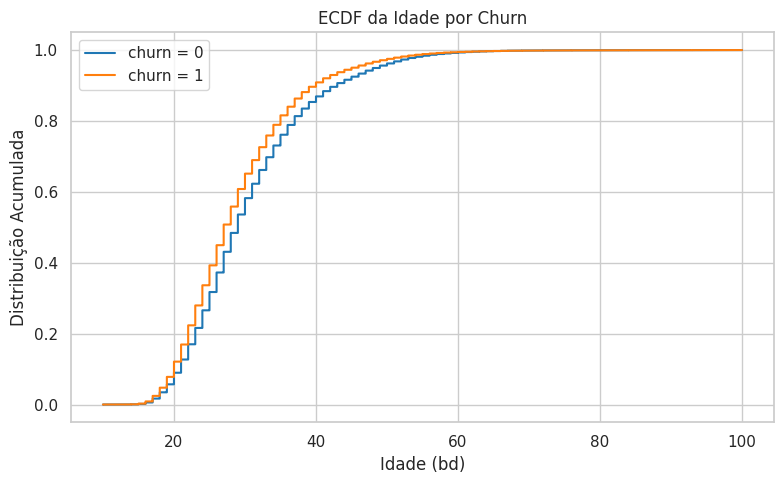

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Configuração do estilo
plt.figure(figsize=(8, 5))

# ECDF para churn = 0 e churn = 1
for churn_class, cor in zip([0, 1], ['tab:blue', 'tab:orange']):
    grupo = df_churn[df_churn['is_churn'] == churn_class]['bd'].dropna()
    x = np.sort(grupo)
    y = np.arange(1, len(x)+1) / len(x)
    plt.step(x, y, where='post', label=f'churn = {churn_class}', color=cor)

# Ajustes do gráfico
plt.title('ECDF da Idade por Churn')
plt.xlabel('Idade (bd)')
plt.ylabel('Distribuição Acumulada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
(df_churn['is_churn'].value_counts(normalize=True) * 100).round(2)


,proportion
is_churn,
0,85.59
1,14.41


In [ ]:
# Contagem de msno por is_churn para cada 'registered_via'
(
    df_churn
    .groupby(['registered_via', 'is_churn'])
    .size()
    .unstack()
    .fillna(0)
    .assign(
        total=lambda x: x[0] +x[1],
        perc_total=lambda x: (x['total']/x['total'].sum() * 100).round(2).astype(str) + '%',
        perc_churn=lambda x: np.where(x[0] != 0, (x[1] / (x[1] + x[0]) * 100).round(2), '100').astype(str) + '%'
    )
    .sort_values(by='total', ascending=False)
    .reset_index()
)

is_churn,registered_via,0,1,total,perc_total,perc_churn
0,7,4172817.0,409097.0,4581914.0,52.91%,8.93%
1,9,2184896.0,471155.0,2656051.0,30.67%,17.74%
2,3,858437.0,261116.0,1119553.0,12.93%,23.32%
3,4,195599.0,106557.0,302156.0,3.49%,35.27%
4,13,653.0,215.0,868.0,0.01%,24.77%
5,10,0.0,10.0,10.0,0.0%,100%


In [ ]:
# Contagem de msno por is_churn para cada 'city'
(
    df_churn
    .groupby(['city', 'is_churn'])
    .size()
    .unstack()
    .fillna(0)
    .assign(
        total=lambda x: x[0] +x[1],
        perc_total=lambda x: (x['total']/x['total'].sum() * 100).round(2).astype(str) + '%',
        perc_churn=lambda x: np.where(x[0] != 0, (x[1] / (x[1] + x[0])  * 100).round(2), '100').astype(str) + '%'
    )
    .sort_values(by='total', ascending=False)
    .reset_index()
).head(5)

is_churn,city,0,1,total,perc_total,perc_churn
0,1,3649894,469004,4118898,47.56%,11.39%
1,13,895001,173680,1068681,12.34%,16.25%
2,5,657058,125924,782982,9.04%,16.08%
3,4,437893,85655,523548,6.05%,16.36%
4,15,359595,85843,445438,5.14%,19.27%


### Avaliação de Variáveis Categóricas

### Variáveis Mantidas:
- **gender**: Apesar de `female` e `male` terem churns próximos (~17%), a categoria `unknown` apresenta um padrão distinto (churn < 13%). Pode ajudar o modelo.
- **registered_via**: Mostra variações claras entre os canais, com canal 4 acima de 30% de churn e canal 7 abaixo de 10%. Deve ser mantida.
- **city**: Há diferença considerável entre cidades, com algumas acima de 20% de churn e outras abaixo de 15%. Deve ser mantida, mas podemos considerar agrupar cidades com comportamento semelhante ou que tenham pouco volume.

### Variáveis Descartadas:
- **registration_init_time**: Já extraímos `dia da semana` e `mês`, que não mostraram variações relevantes de churn. As derivadas serão descartadas.
- **registered_dayofweek / registered_month**: As curvas são estáveis, com pouca variação de churn entre dias e meses. Não agregam poder discriminativo relevante.

### Ações:
- Codificar as variáveis categóricas mantidas com `pd.get_dummies()` ou `target encoding`, dependendo da abordagem escolhida.
- Remover as colunas categóricas descartadas do `df_churn` ao gerar o `df_model`.


### Observações
- A cidade 1 é a que tem o maior número de registros, e também o menor número de Churn;
- O método de registro 7 é o que tem o maior número de usuários e também o menor número de Churn;
- A curva de distribuição de idades mostra uma tendência maior de usuários jovens a Churnar.

##4.2 Transactions x Churn

In [ ]:
custom_info_mem(transactions, show_memory=True)

[Resumo do DataFrame] → Total de linhas: 20,712,225

Coluna                    Valores Não Nulos    Tipo de Dado
------------------------------------------------------------
msno                      20,712,225           category
payment_method_id         20,712,225           category
payment_plan_days         20,712,225           int16
plan_list_price           20,712,225           float32
actual_amount_paid        20,712,225           float32
is_auto_renew             20,712,225           int8
transaction_date          20,712,225           datetime64[ns]
membership_expire_date    20,710,726           datetime64[ns]
is_cancel                 20,712,225           int8
safra                     20,712,225           object

[Uso de Memória] → 2188.43 MB (deep=True)


In [ ]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,safra
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,38,410,1788.0,1788.0,0,2015-11-21,2017-01-04,0,201511
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149.0,149.0,1,2015-05-26,2015-06-26,0,201505
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149.0,149.0,1,2015-09-26,2015-10-26,0,201509
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41,30,149.0,149.0,1,2016-06-15,2016-07-15,0,201606
4,++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=,40,31,149.0,149.0,1,2015-01-13,2015-02-16,0,201501


In [ ]:
# Verificar NaTs nas colunas transaction_date e membership_expire_date
print("NaTs em transaction_date:", transactions['transaction_date'].isna().sum())
print("NaTs em membership_expire_date:", transactions['membership_expire_date'].isna().sum())

NaTs em transaction_date: 0
NaTs em membership_expire_date: 1499


###4.2.1 Deltas de Data de Expiração

transaction_date,membership_expire_date,diff_transacao,diff_expira
2015-01-27,2016-04-02,NaT,NaT
2015-02-27,2016-05-28,31 days,56 days
2015-03-31,2015-04-30,32 days,-394 days
2015-04-27,2016-09-27,27 days,516 days
2015-05-27,2016-11-25,30 days,59 days
2015-06-30,2015-07-31,34 days,-483 days
2015-07-26,2017-03-13,26 days,591 days
2016-03-18,2016-04-18,236 days,-329 days
2016-04-18,2016-05-18,31 days,30 days
2016-05-18,2016-06-18,30 days,31 days


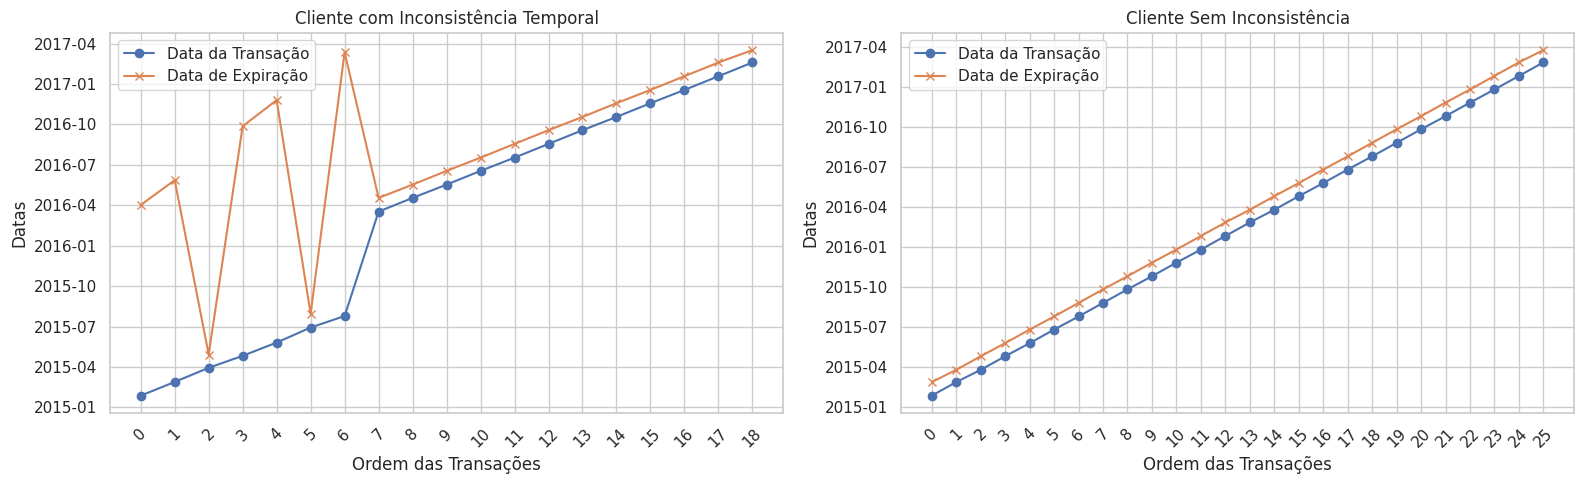

In [ ]:
# ================================
# Comparativo: Cliente com e sem inconsistência temporal
# ================================

# 0. Validação da regressão nas datas de expiração com os dados tratados
expire_diff = (
    transactions.sort_values(['msno', 'transaction_date'])
    .groupby('msno')['membership_expire_date']
    .diff()
)

# 1. Identifica clientes com pelo menos duas regressões na validade (casos mais críticos)
clientes_com_inconsistencia = (
    transactions.loc[expire_diff < pd.Timedelta(0), 'msno']
    .value_counts()
    .loc[lambda x: x > 1]
    .index
)

# 2. Seleciona clientes com múltiplas transações válidas e sem inconsistência
clientes_sem_inconsistencia = (
    transactions[~transactions['msno'].isin(clientes_com_inconsistencia)]
    .groupby('msno')
    .filter(lambda x: len(x) > 5)  # Exige volume mínimo de histórico
    .groupby('msno')
    .head(1)['msno']
    .unique()
)

# 3. Seleciona um exemplo de cada grupo
cliente_com_inconsistencia = clientes_com_inconsistencia[0]
cliente_sem_inconsistencia = clientes_sem_inconsistencia[0]

# 4. Função auxiliar para preparar a linha temporal de um cliente
def prepara_detalhe(msno, base):
    df = (
        base[base['msno'] == msno]
        .sort_values('transaction_date')[['transaction_date', 'membership_expire_date']]
        .reset_index(drop=True)
    )
    df['diff_transacao'] = df['transaction_date'].diff()
    df['diff_expira'] = df['membership_expire_date'].diff()
    return df

# 5. Prepara os dois dataframes individuais
df_inconsistente = prepara_detalhe(cliente_com_inconsistencia, transactions)
df_linear = prepara_detalhe(cliente_sem_inconsistencia, transactions)

# 6. Exibe as tabelas lado a lado para facilitar o diagnóstico visual
html = f"""
<table style="width:100%; table-layout: fixed">
<tr>
<td style="vertical-align:top; width:50%">
<strong>Cliente com Inconsistência Temporal (msno = {cliente_com_inconsistencia}):</strong>
{df_inconsistente.to_html(index=False)}
</td>
<td style="vertical-align:top; width:50%">
<strong>Cliente Sem Inconsistência (msno = {cliente_sem_inconsistencia}):</strong>
{df_linear.to_html(index=False)}
</td>
</tr>
</table>
"""
display(HTML(html))

# 7. Plota as séries temporais de ambos os clientes para análise comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

for ax, df, titulo in zip(
    axes,
    [df_inconsistente, df_linear],
    ['Cliente com Inconsistência Temporal', 'Cliente Sem Inconsistência']
):
    ax.plot(df['transaction_date'], marker='o', label='Data da Transação')
    ax.plot(df['membership_expire_date'], marker='x', label='Data de Expiração')
    ax.set_title(titulo)
    ax.set_xlabel('Ordem das Transações')
    ax.set_ylabel('Datas')
    ax.set_xticks(range(len(df)))
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 8. Libera memória temporária
del clientes_com_inconsistencia, clientes_sem_inconsistencia
del df_inconsistente, df_linear

In [ ]:
import pandas as pd

# Parte 1: Garante que a safra do churn está em datetime
df_churn['safra'] = pd.to_datetime(df_churn['safra'], format='%Y%m')
df_churn['safra_mais3'] = df_churn['safra'] + pd.DateOffset(months=3)

# Parte 2: DataFrame reduzido com combinações únicas de cliente e safra
clientes_safras = df_churn[['msno', 'safra', 'safra_mais3']].drop_duplicates()

# Parte 3: Merge com transactions
transactions_expandida = clientes_safras.merge(
    transactions,
    on='msno',
    how='left',
    suffixes=('', '_trans')
)

# Garante que a safra na transactions esteja em datetime também
transactions_expandida['safra_trans'] = pd.to_datetime(transactions_expandida['safra_trans'], format='%Y%m')

# Parte 4: Filtra transações no intervalo (safra < trans <= safra+3)
transactions_intervaladas = transactions_expandida[
    (transactions_expandida['safra'] < transactions_expandida['safra_trans']) &
    (transactions_expandida['safra_trans'] <= transactions_expandida['safra_mais3'])
].copy()

# Parte 5: Ordena e calcula o delta entre membership_expire_date consecutivas
transactions_intervaladas = transactions_intervaladas.sort_values(['msno', 'safra', 'transaction_date'])
transactions_intervaladas['diff_expira'] = (
    transactions_intervaladas
    .groupby(['msno', 'safra'], observed=True)['membership_expire_date']
    .diff()
    .dt.days
)

# Parte 6: Média do delta por cliente e safra
media_delta_por_safra = (
    transactions_intervaladas
    .groupby(['msno', 'safra'], observed=True)['diff_expira']
    .mean()
    .reset_index()
    .rename(columns={'diff_expira': 'media_diff_expira'})
)

In [ ]:
transactions_intervaladas.head()

,msno,safra,safra_mais3,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,safra_trans,diff_expira
91141869,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,2016-02-01,39,30,149.0,149.0,1,2015-12-02,2016-01-19,0,2015-12-01,NaN
91141856,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,2016-02-01,39,30,149.0,149.0,1,2016-01-31,2016-03-19,0,2016-01-01,60.0
81714395,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-12-01,2016-03-01,39,30,149.0,149.0,1,2016-01-31,2016-03-19,0,2016-01-01,NaN
42429286,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,2016-10-01,39,30,149.0,149.0,1,2016-08-31,2016-10-19,0,2016-08-01,NaN
42429280,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,2016-10-01,39,30,149.0,149.0,1,2016-09-30,2016-11-19,0,2016-09-01,31.0


In [ ]:
transactions_intervaladas[(transactions_intervaladas['msno']=='+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=')
& (transactions_intervaladas['safra']=='2015-11-01')]

,msno,safra,safra_mais3,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,safra_trans,diff_expira
91141869,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,2016-02-01,39,30,149.0,149.0,1,2015-12-02,2016-01-19,0,2015-12-01,NaN
91141856,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,2016-02-01,39,30,149.0,149.0,1,2016-01-31,2016-03-19,0,2016-01-01,60.0


In [ ]:
media_delta_por_safra[media_delta_por_safra['msno']=='+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=']

,msno,safra,media_diff_expira
0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,60.0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-12-01,NaN
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,30.5
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-08-01,30.5
4,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-09-01,31.0


In [ ]:
# Conta a frequência de cada plano dentro da janela, por cliente e safra
plano_mais_comum = (
    transactions_intervaladas
    .groupby(['msno', 'safra', 'payment_plan_days'], observed=True)
    .size()
    .reset_index(name='frequencia')
)

# Encontra o plano com maior frequência por cliente e safra
plano_mais_comum_idxmax = (
    plano_mais_comum
    .sort_values('frequencia', ascending=False)
    .drop_duplicates(subset=['msno', 'safra'])
    .rename(columns={'payment_plan_days': 'plano_mais_comum'})
    [['msno', 'safra', 'plano_mais_comum']]
)


In [ ]:
plano_mais_comum_idxmax[(plano_mais_comum_idxmax['msno']=='9q54o8052Lm137De3d3g+zbmG/edv03k8KhsL2Bnzag=') & (plano_mais_comum_idxmax['safra']=='2016-02-01')]

,msno,safra,plano_mais_comum
1497164,9q54o8052Lm137De3d3g+zbmG/edv03k8KhsL2Bnzag=,2016-02-01,30


In [ ]:
transactions_intervaladas[(transactions_intervaladas['msno']=='9q54o8052Lm137De3d3g+zbmG/edv03k8KhsL2Bnzag=') & (transactions_intervaladas['safra']=='2016-02-01')]

,msno,safra,safra_mais3,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,safra_trans,diff_expira
155898848,9q54o8052Lm137De3d3g+zbmG/edv03k8KhsL2Bnzag=,2016-02-01,2016-05-01,41,30,100.0,100.0,1,2016-03-04,1999-12-30,0,2016-03-01,NaN
155898870,9q54o8052Lm137De3d3g+zbmG/edv03k8KhsL2Bnzag=,2016-02-01,2016-05-01,41,30,100.0,100.0,1,2016-04-20,2016-04-20,1,2016-04-01,5956.0
155898849,9q54o8052Lm137De3d3g+zbmG/edv03k8KhsL2Bnzag=,2016-02-01,2016-05-01,41,30,100.0,100.0,1,2016-05-03,2016-06-03,0,2016-05-01,44.0


In [ ]:
df_churn.head()

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,reg_wday,reg_month,safra_mais3
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2016-09-01,0,2014-09-27,1,<NA>,unknown,7,Saturday,September,2016-12-01
1,++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=,2016-04-01,0,2007-06-09,15,29,male,9,Saturday,June,2016-07-01
2,++CzVs35NSfU/gjDrGbWLVMweubEiMZsuvd3eTbXs58=,2016-02-01,0,2015-09-14,1,<NA>,unknown,7,Monday,September,2016-05-01
3,++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=,2016-08-01,0,2012-06-05,1,<NA>,unknown,7,Tuesday,June,2016-11-01
4,++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=,2016-09-01,0,2011-03-22,4,37,male,9,Tuesday,March,2016-12-01


In [ ]:
media_delta_por_safra.head()

,msno,safra,media_diff_expira
0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,60.0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-12-01,NaN
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,30.5
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-08-01,30.5
4,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-09-01,31.0


In [ ]:
len(df_churn)

8660552

In [ ]:
# dropar as colunas reg_wday	reg_month	safra_mais3 e converter safra para o formato anomes
df_churn = df_churn.drop(columns=['reg_wday', 'reg_month'])
df_churn['safra'] = df_churn['safra'].dt.strftime('%Y%m')

# Converter safra do media_deçta_por_safra para anomes
media_delta_por_safra['safra'] = media_delta_por_safra['safra'].dt.strftime('%Y%m')

# Trazer media_diff_expira para df churn com inner
df_churn = df_churn.merge(media_delta_por_safra, on=['msno', 'safra'], how='inner')

In [ ]:
len(df_churn)

8003864

In [ ]:
# Converte safra de plano_mais_comum_idxmax para anomes
plano_mais_comum_idxmax['safra'] = plano_mais_comum_idxmax['safra'].dt.strftime('%Y%m')

# Trazer para df_churn com inner
df_churn = df_churn.merge(plano_mais_comum_idxmax, on=['msno', 'safra'], how='inner')

In [ ]:
len(df_churn)

8003864

In [ ]:
df_churn.head()

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,safra_mais3,media_diff_expira,plano_mais_comum
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201609,0,2014-09-27,1,<NA>,unknown,7,2016-12-01,30.5,30
1,++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=,201604,0,2007-06-09,15,29,male,9,2016-07-01,31.0,30
2,++CzVs35NSfU/gjDrGbWLVMweubEiMZsuvd3eTbXs58=,201602,0,2015-09-14,1,<NA>,unknown,7,2016-05-01,30.5,30
3,++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=,201608,0,2012-06-05,1,<NA>,unknown,7,2016-11-01,30.5,30
4,++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=,201609,0,2011-03-22,4,37,male,9,2016-12-01,30.5,30


In [ ]:
#contagem de NaN para media diff
print('Total NaN media_diff_expira: ', df_churn['media_diff_expira'].isna().sum())

Total NaN media_diff_expira:  494360


In [ ]:
# Ajustando: quando media_diff_expira for NaN, usar a moda do Plan Days
df_churn['media_diff_expira'] = df_churn['media_diff_expira'].fillna(df_churn['plano_mais_comum'])

In [ ]:
#contagem de NaN para media diff
print('Total NaN media_diff_expira: ', df_churn['media_diff_expira'].isna().sum())

Total NaN media_diff_expira:  0


In [ ]:
# coluna delta_media_vs_plano --> abs(media_diff_expira - plano_mais_comum)
df_churn['delta_media_vs_plano'] = abs(df_churn['media_diff_expira'] - df_churn['plano_mais_comum'])

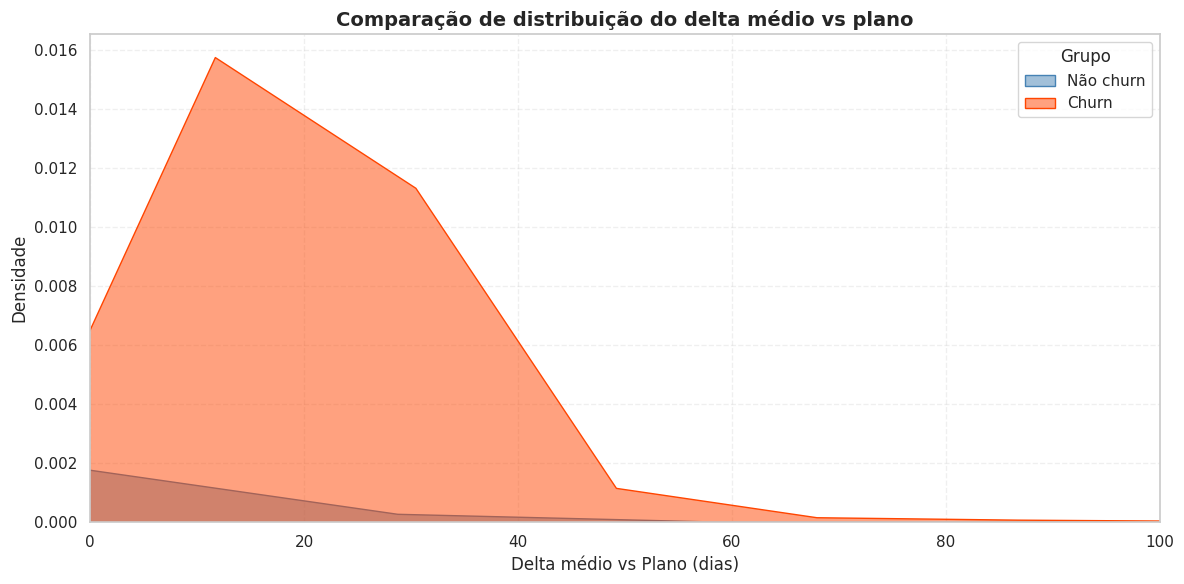

In [ ]:
plt.figure(figsize=(12, 6))

# Dados separados
df_churn_0 = df_churn[df_churn['is_churn'] == 0]
df_churn_1 = df_churn[df_churn['is_churn'] == 1]

# Plot de cada um com mesma escala de bins
sns.kdeplot(df_churn_0['delta_media_vs_plano'], label='Não churn', fill=True, color='steelblue', alpha=0.5)
sns.kdeplot(df_churn_1['delta_media_vs_plano'], label='Churn', fill=True, color='orangered', alpha=0.5)

plt.xlim(0, 100)
plt.title("Comparação de distribuição do delta médio vs plano", fontsize=14, weight='bold')
plt.xlabel("Delta médio vs Plano (dias)", fontsize=12)
plt.ylabel("Densidade", fontsize=12)
plt.legend(title='Grupo')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

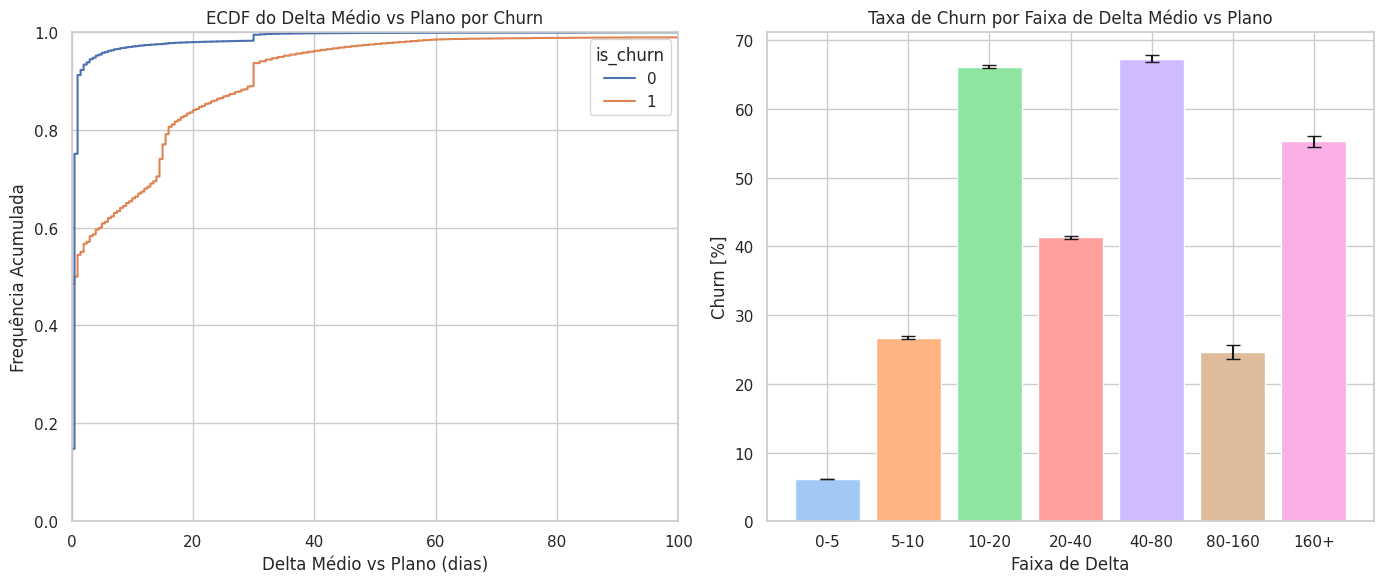

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import binom

# Corrigindo os bins e labels
bins = [0, 5, 10, 20, 40, 80, 160, float('inf')]
labels = ['0-5', '5-10', '10-20', '20-40', '40-80', '80-160', '160+']

df_churn['delta_faixa'] = pd.cut(
    df_churn['delta_media_vs_plano'],
    bins=bins,
    labels=labels,
    right=False
)

# Contagem por faixa e is_churn
contagem = (
    df_churn
    .groupby(['delta_faixa', 'is_churn'])
    .size()
    .unstack(fill_value=0)
)

# Total e churn_pct
contagem['total'] = contagem[0] + contagem[1]
contagem['churn_pct'] = (contagem[1] / contagem['total']) * 100

# Intervalo de confiança para cada faixa
conf_int = contagem.apply(
    lambda row: binom.interval(0.95, int(row['total']), row[1]/row['total']) if row['total'] > 0 else (0, 0),
    axis=1
)
conf_int = np.array(conf_int.tolist()) / contagem['total'].values[:, None] * 100
contagem['err_lower'] = contagem['churn_pct'] - conf_int[:, 0]
contagem['err_upper'] = conf_int[:, 1] - contagem['churn_pct']

# Gráfico
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ECDF (esquerda)
sns.ecdfplot(data=df_churn, x='delta_media_vs_plano', hue='is_churn', ax=axes[0])
axes[0].set_xlim(0, 100)
axes[0].set_title('ECDF do Delta Médio vs Plano por Churn')
axes[0].set_xlabel('Delta Médio vs Plano (dias)')
axes[0].set_ylabel('Frequência Acumulada')

# Barras com erro e largura proporcional (direita)
axes[1].bar(
    contagem.index,
    contagem['churn_pct'],
    yerr=[contagem['err_lower'], contagem['err_upper']],
    capsize=5,
    color=sns.color_palette('pastel'),
)
axes[1].set_title('Taxa de Churn por Faixa de Delta Médio vs Plano')
axes[1].set_xlabel('Faixa de Delta')
axes[1].set_ylabel('Churn [%]')

plt.tight_layout()
plt.show()


#### Análise da Feature `delta_media_vs_plano`

#### ECDF (à esquerda):
- **Clientes que não deram churn (`is_churn = 0`)** acumulam rapidamente com **deltas pequenos (próximos de zero)**, ou seja, a média do intervalo entre planos deles é próxima do que foi contratado — **comportamento consistente**.
- **Clientes que deram churn (`is_churn = 1`)** têm uma **distribuição mais espalhada**, com muitos apresentando **deltas maiores** → comportamento inconsistente ou anormal em relação ao plano.

#### Barras por faixa (à direita):
- A **taxa de churn aumenta claramente** conforme o `delta_media_vs_plano` cresce — especialmente nas faixas de **20 a 160 dias**.
- Isso sugere que **grandes desvios entre a média de expiração e o plano contratado** podem indicar **clientes com problemas na recorrência**, **falta de aderência ao plano** ou **instabilidade** — bons indícios de churn.


In [ ]:
# Representatividade das variáveis
(
    df_churn.groupby(['delta_faixa','is_churn'])
            .size()
            .unstack()
            .assign(total=lambda x: x[0] + x[1])
            .assign(perc_total=lambda x: (x['total']/x['total'].sum() * 100).round(2).astype(str) + '%')
            .assign(perc_churn=lambda x: (x[1]/(x[0]+x[1]) * 100).round(2).astype(str) + '%')
            .sort_values(by='total', ascending=False)
            .reset_index()
)

is_churn,delta_faixa,0,1,total,perc_total,perc_churn
0,0-5,6914013,451426,7365439,92.02%,6.13%
1,20-40,132247,93213,225460,2.82%,41.34%
2,10-20,69998,136847,206845,2.58%,66.16%
3,5-10,112505,41038,153543,1.92%,26.73%
4,40-80,10337,21287,31624,0.4%,67.31%
5,160+,6103,7542,13645,0.17%,55.27%
6,80-160,5506,1802,7308,0.09%,24.66%


###4.2.2 Desconto médio

In [ ]:
transactions_intervaladas.head()

,msno,safra,safra_mais3,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,safra_trans,diff_expira
91141869,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,2016-02-01,39,30,149.0,149.0,1,2015-12-02,2016-01-19,0,2015-12-01,NaN
91141856,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,2016-02-01,39,30,149.0,149.0,1,2016-01-31,2016-03-19,0,2016-01-01,60.0
81714395,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-12-01,2016-03-01,39,30,149.0,149.0,1,2016-01-31,2016-03-19,0,2016-01-01,NaN
42429286,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,2016-10-01,39,30,149.0,149.0,1,2016-08-31,2016-10-19,0,2016-08-01,NaN
42429280,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,2016-10-01,39,30,149.0,149.0,1,2016-09-30,2016-11-19,0,2016-09-01,31.0


In [ ]:
# Desconto %
transactions_intervaladas['desconto'] = (transactions_intervaladas['plan_list_price'] - transactions_intervaladas['actual_amount_paid']) / transactions_intervaladas['plan_list_price']

# Desconto médio
desconto_medio = (
    transactions_intervaladas
    .groupby(['msno', 'safra'], observed=True)['desconto']
    .mean()
    .reset_index()
    .rename(columns={'desconto': 'desconto_medio'})
)

In [ ]:
desconto_medio[desconto_medio['desconto_medio'] <= 0.75].sort_values(by='desconto_medio', ascending=False).head()

,msno,safra,desconto_medio
1581668,AcByB4v9sJo0cnNDIqrkBE2LekNTBoSrxaOSdyWEIXc=,2015-12-01,0.666667
1332719,8dWbKT3ahUlZRCRCaamiaAZhL0EElGWQIvZKoWQdqQM=,2015-10-01,0.666667
5412978,fFzzj6zbsGDa/uAobig9smsnYPuvP8s2qeuoEUoiwzc=,2015-12-01,0.666667
3127008,MyehdE52u7J7xInc438dO9m0AeEY+oBy30S42QltsyM=,2015-10-01,0.666667
968598,5jqAqAtu8VdMiGNU2wlwAwzPngipAwI5yLXCdU63MQU=,2016-07-01,0.666667


In [ ]:
transactions_intervaladas[(transactions_intervaladas['msno']=='AcByB4v9sJo0cnNDIqrkBE2LekNTBoSrxaOSdyWEIXc=') & (transactions_intervaladas['safra']=='2015-12-01')]

,msno,safra,safra_mais3,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,safra_trans,diff_expira,desconto
89883429,AcByB4v9sJo0cnNDIqrkBE2LekNTBoSrxaOSdyWEIXc=,2015-12-01,2016-03-01,41,30,149.0,0.0,1,2016-01-06,2016-01-06,1,2016-01-01,NaN,1.0
89883424,AcByB4v9sJo0cnNDIqrkBE2LekNTBoSrxaOSdyWEIXc=,2015-12-01,2016-03-01,41,30,149.0,0.0,1,2016-02-23,2016-03-22,0,2016-02-01,76.0,1.0
89883425,AcByB4v9sJo0cnNDIqrkBE2LekNTBoSrxaOSdyWEIXc=,2015-12-01,2016-03-01,41,30,149.0,149.0,1,2016-03-22,2016-04-22,0,2016-03-01,31.0,0.0


In [ ]:
transactions_intervaladas['desconto'].unique()

array([ 0.        ,         nan,  0.13422818,  1.        ,  0.20134228,
        0.33557048, -0.00793651, -0.00615213,  0.00666667], dtype=float32)

In [ ]:
# Contar quantidade de linhas por tipo de desconto
desconto_counts = desconto_medio['desconto_medio'].value_counts().reset_index()
desconto_counts.columns = ['desconto', 'quantidade']
desconto_counts.head(15)
# del desconto_counts

,desconto,quantidade
0,0.000000,7912777
1,1.000000,32514
2,0.333333,24609
3,0.500000,3991
4,0.134228,612
5,0.044743,573
6,0.089485,420
7,0.666667,345
8,0.067114,160
9,0.201342,100


In [ ]:
len(df_churn)

8003864

In [ ]:
desconto_medio.head()

,msno,safra,desconto_medio
0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,0.0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-12-01,0.0
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,0.0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-08-01,0.0
4,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-09-01,0.0


In [ ]:
# Converter safra do desconto medio para anomes
desconto_medio['safra'] = desconto_medio['safra'].dt.strftime('%Y%m')

In [ ]:
df_churn.head()

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,safra_mais3,media_diff_expira,plano_mais_comum,delta_media_vs_plano,delta_faixa
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201609,0,2014-09-27,1,<NA>,unknown,7,2016-12-01,30.5,30,0.5,0-5
1,++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=,201604,0,2007-06-09,15,29,male,9,2016-07-01,31.0,30,1.0,0-5
2,++CzVs35NSfU/gjDrGbWLVMweubEiMZsuvd3eTbXs58=,201602,0,2015-09-14,1,<NA>,unknown,7,2016-05-01,30.5,30,0.5,0-5
3,++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=,201608,0,2012-06-05,1,<NA>,unknown,7,2016-11-01,30.5,30,0.5,0-5
4,++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=,201609,0,2011-03-22,4,37,male,9,2016-12-01,30.5,30,0.5,0-5


In [ ]:
#  Merge com df_churn para desconto -- inner
df_churn = df_churn.merge(desconto_medio, on=['msno', 'safra'], how='inner')

In [ ]:
len(df_churn)

8003864

In [ ]:
df_churn[df_churn['msno']=='+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc='].head()

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,safra_mais3,media_diff_expira,plano_mais_comum,delta_media_vs_plano,delta_faixa,desconto_medio
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201609,0,2014-09-27,1,<NA>,unknown,7,2016-12-01,30.5,30,0.5,0-5,0.0
399387,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201608,0,2014-09-27,1,<NA>,unknown,7,2016-11-01,30.5,30,0.5,0-5,0.0
719300,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201605,0,2014-09-27,1,<NA>,unknown,7,2016-08-01,31.0,30,1.0,0-5,0.0
1600356,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201606,0,2014-09-27,1,<NA>,unknown,7,2016-09-01,30.5,30,0.5,0-5,0.0
2720564,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201510,0,2014-09-27,1,<NA>,unknown,7,2016-01-01,31.0,30,1.0,0-5,0.0


### Checkpoint Intermediário

In [ ]:
# # Caminho de salvamento
save_path = os.path.join(base_dir, 'data')

# # Salvar versões tratadas em formato .parquet com nomes diferentes
df_churn.to_parquet(os.path.join(save_path, 'df_churn.parquet'), index=False)
# members.to_parquet(os.path.join(save_path, 'members_tratado.parquet'), index=False)
# user_logs.to_parquet(os.path.join(save_path, 'user_logs_tratado.parquet'), index=False)
# transactions.to_parquet(os.path.join(save_path, 'transactions_tratado.parquet'), index=False)

# print("Checkpoint em .parquet salvo com sucesso!")


In [ ]:
 # Leitura de dados CheckPoint
 df_churn = pd.read_parquet(os.path.join(base_dir, 'data', 'df_churn.parquet'))
 members = pd.read_parquet(os.path.join(base_dir, 'data', 'members_tratado.parquet'))
 user_logs = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_tratado.parquet'))
 transactions = pd.read_parquet(os.path.join(base_dir, 'data', 'transactions_tratado.parquet'))
 user_logs_intervalados = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_intervalados.parquet'))

 print("Checkpoint restaurado com sucesso!")

##4.3 User Logs

In [ ]:
len(df_churn)

8003864

In [ ]:
df_churn.head()

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,safra_mais3,media_diff_expira,plano_mais_comum,delta_media_vs_plano,delta_faixa,desconto_medio
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201609,0,2014-09-27,1,<NA>,unknown,7,2016-12-01,30.5,30,0.5,0-5,0.0
1,++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=,201604,0,2007-06-09,15,29,male,9,2016-07-01,31.0,30,1.0,0-5,0.0
2,++CzVs35NSfU/gjDrGbWLVMweubEiMZsuvd3eTbXs58=,201602,0,2015-09-14,1,<NA>,unknown,7,2016-05-01,30.5,30,0.5,0-5,0.0
3,++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=,201608,0,2012-06-05,1,<NA>,unknown,7,2016-11-01,30.5,30,0.5,0-5,0.0
4,++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=,201609,0,2011-03-22,4,37,male,9,2016-12-01,30.5,30,0.5,0-5,0.0


In [ ]:
user_logs.head()

,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,SwlrSivYHoKF9V5wm1YYYAnjHpd9y3OPjI9rDUhGJ3k=,201701,121,28,14,29,704,827,184606.906250
1,rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=,201605,26,2,5,6,462,256,119439.484375
2,hx+cyaQ/Jcdr/Z5foa/Cn0PXUzC/F7QO/NQvWQS1Qtc=,201611,161,71,49,34,668,891,204791.234375
3,53QW6B70J23X2UCvxaaUppjyE0b6X9nzP79W4huZv+Q=,201502,37,9,3,9,408,447,101186.039062
4,/0S1N/oRyxGLZlzxnW5rOjfo0ZAls9EH23ahuDNuqz8=,201506,205,49,23,21,225,489,69957.523438


In [ ]:
len(user_logs)

26758971

In [ ]:
# DataFrame reduzido com combinações únicas de cliente e safra
clientes_safras = df_churn[['msno', 'safra']].drop_duplicates()

# Conversao safra para date
clientes_safras['safra'] = pd.to_datetime(clientes_safras['safra'], format='%Y%m')

# Criação safra mais 3
clientes_safras['safra_mais3'] = clientes_safras['safra'] + pd.DateOffset(months=3)

In [ ]:
# 1. Converte a data do user_logs
user_logs['safra'] = pd.to_datetime(user_logs['safra'], format='%Y%m')

# 2. Calcula a menor e a maior data da janela de interesse (para cortar o user_logs bruto)
data_min = clientes_safras['safra'].min()
data_max = (clientes_safras['safra_mais3']).max()

# 3. Pré-filtra o user_logs para manter só o necessário
user_logs_filtrado = user_logs[
    (user_logs['safra'] > data_min) &
    (user_logs['safra'] <= data_max)
].copy()


In [ ]:
len(user_logs_filtrado)

15204461

In [ ]:
# # 4. Agora faz o merge com bem menos carga
# user_logs_expandido = clientes_safras.merge(
#     user_logs_filtrado,
#     on='msno',
#     how='left',
#     suffixes=('_janela', '_log')
# )

# # 5. Filtra a janela específica (safra_log dentro de (safra_janela, safra_mais3])
# user_logs_intervalados = user_logs_expandido[
#     (user_logs_expandido['safra_log'] > user_logs_expandido['safra_janela']) &
#     (user_logs_expandido['safra_log'] <= user_logs_expandido['safra_mais3'])
# ].copy()


In [ ]:
# 4' + 5' — Merge + filtro em LOTES de msno (evita explosão de linhas)
import numpy as np

# ajuste quantos lotes quer (mais lotes = menos RAM usada por vez)
n_chunks = 50

parts = []
msnos = clientes_safras['msno'].unique()

for chunk in np.array_split(msnos, n_chunks):
    # recorte pequeno de cada lado
    cs = clientes_safras[clientes_safras['msno'].isin(chunk)]
    ul = user_logs_filtrado[user_logs_filtrado['msno'].isin(chunk)]

    # merge igual ao seu (gera colunas: safra_janela, safra_log, safra_mais3)
    m = cs.merge(ul, on='msno', how='left', suffixes=('_janela', '_log'))

    # mesmo filtro da janela: safra_log dentro de (safra_janela, safra_mais3]
    f = m[(m['safra_log'] > m['safra_janela']) & (m['safra_log'] <= m['safra_mais3'])]

    parts.append(f)

# resultado final idêntico ao que você tinha, só que montado em partes
user_logs_intervalados = pd.concat(parts, ignore_index=True)


In [ ]:
user_logs_intervalados.head()

,msno,safra_janela,safra_mais3,safra_log,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2016-09-01,2016-12-01,2016-12-01,166.0,73.0,49.0,43.0,579.0,645.0,169086.593750
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2016-09-01,2016-12-01,2016-10-01,189.0,84.0,52.0,32.0,516.0,742.0,152259.281250
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2016-09-01,2016-12-01,2016-11-01,110.0,42.0,34.0,26.0,1144.0,989.0,289423.156250
3,++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=,2016-04-01,2016-07-01,2016-05-01,195.0,37.0,29.0,39.0,653.0,518.0,170064.750000
4,++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=,2016-04-01,2016-07-01,2016-06-01,370.0,95.0,78.0,67.0,766.0,715.0,223580.015625


In [ ]:
len(user_logs_intervalados)

20841350

In [ ]:
user_logs_intervalados.describe()

,safra_janela,safra_mais3,safra_log,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,20841350,20841350,20841350,2.084135e+07,2.084135e+07,2.084135e+07,2.084135e+07,2.084135e+07,2.084135e+07,2.084135e+07
mean,2016-03-26 19:15:36.752945152,2016-06-26 07:28:17.749178368,2016-05-26 10:16:46.748371200,1.133791e+02,2.766998e+01,1.733140e+01,1.918923e+01,5.238936e+02,5.165038e+02,-9.324600e+11
min,2015-10-01 00:00:00,2016-01-01 00:00:00,2015-11-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-9.223372e+16
25%,2016-01-01 00:00:00,2016-04-01 00:00:00,2016-03-01 00:00:00,1.900000e+01,5.000000e+00,3.000000e+00,3.000000e+00,1.040000e+02,1.230000e+02,2.951806e+04
50%,2016-04-01 00:00:00,2016-07-01 00:00:00,2016-06-01 00:00:00,5.600000e+01,1.500000e+01,1.000000e+01,1.000000e+01,2.970000e+02,3.310000e+02,8.182849e+04
75%,2016-07-01 00:00:00,2016-10-01 00:00:00,2016-09-01 00:00:00,1.380000e+02,3.500000e+01,2.300000e+01,2.400000e+01,6.520000e+02,6.900000e+02,1.758407e+05
max,2016-09-01 00:00:00,2016-12-01 00:00:00,2016-12-01 00:00:00,1.118640e+05,5.929000e+03,3.216000e+03,8.140000e+03,5.518700e+04,2.226200e+04,1.456744e+09
std,NaN,NaN,NaN,2.023555e+02,4.071874e+01,2.355966e+01,3.665214e+01,7.315941e+02,5.987522e+02,1.265350e+14


In [ ]:
# Seleciona apenas as colunas numéricas relevantes
colunas_uso = [
    'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs'
]

# Filtra o DataFrame apenas com essas colunas
df_uso = user_logs_intervalados[colunas_uso]

# Calcula os quantis extremos
quantis_extremos = df_uso.quantile([0.995, 0.999]).T
quantis_extremos.columns = ['q_995', 'q_999']

quantis_extremos


,q_995,q_999
num_25,1047.000,1.755000e+03
num_50,234.000,3.890000e+02
num_75,133.000,2.160000e+02
num_985,167.000,3.270000e+02
num_100,4428.000,6.350651e+03
num_unq,3455.000,4.710000e+03
total_secs,1081550.625,1.492660e+06


In [ ]:
# ============================
# TRATAMENTO DE OUTLIERS EM USO DE MÚSICA
# ============================

# Justificativa:
# Os valores muito altos encontrados em métricas como 'total_secs', 'num_100' e 'num_unq' são
# provavelmente erros ou ruídos, pois representam usos muito acima do plausível para um único mês.
# Vamos substituir esses valores por NaN para evitar distorções no modelo.

# Cópia de segurança (opcional, se quiser preservar original)
# user_logs_intervalados_raw = user_logs_intervalados.copy()

# Limites superiores definidos com base nos quantis 0.995 e 0.999 analisados:
limites_superiores = {
    'total_secs': 1_000_000,       # ~11,5 dias ouvindo música direto no mês
    'num_100': 4_000,              # ~130 músicas 100% por dia
    'num_unq': 4_000              # ~130 músicas únicas por dia
}

# Aplica o tratamento: mantém valores entre 0 e o limite, e substitui o resto por NaN
for coluna, limite in limites_superiores.items():
    if coluna in user_logs_intervalados.columns:
        user_logs_intervalados[coluna] = user_logs_intervalados[coluna].where(
            (user_logs_intervalados[coluna] >= 0) & (user_logs_intervalados[coluna] <= limite)
        )
        print(f"→ Tratamento aplicado na coluna {coluna} (intervalo válido: 0 até {limite})")

# Comentário final:
# Essa abordagem ajuda a reduzir a influência de outliers extremos nas médias e somas,
# deixando o modelo mais robusto e interpretável.


→ Tratamento aplicado na coluna total_secs (intervalo válido: 0 até 1000000)
→ Tratamento aplicado na coluna num_100 (intervalo válido: 0 até 4000)
→ Tratamento aplicado na coluna num_unq (intervalo válido: 0 até 4000)


In [ ]:
user_logs_intervalados.describe()

,safra_janela,safra_mais3,safra_log,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,20841350,20841350,20841350,2.084135e+07,2.084135e+07,2.084135e+07,2.084135e+07,2.068963e+07,2.078928e+07,2.069588e+07
mean,2016-03-26 19:15:36.752945152,2016-06-26 07:28:17.749178368,2016-05-26 10:16:46.748371200,1.133791e+02,2.766998e+01,1.733140e+01,1.918923e+01,4.890100e+02,5.056422e+02,1.305342e+05
min,2015-10-01 00:00:00,2016-01-01 00:00:00,2015-11-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e-03
25%,2016-01-01 00:00:00,2016-04-01 00:00:00,2016-03-01 00:00:00,1.900000e+01,5.000000e+00,3.000000e+00,3.000000e+00,1.020000e+02,1.230000e+02,2.923506e+04
50%,2016-04-01 00:00:00,2016-07-01 00:00:00,2016-06-01 00:00:00,5.600000e+01,1.500000e+01,1.000000e+01,1.000000e+01,2.940000e+02,3.300000e+02,8.093977e+04
75%,2016-07-01 00:00:00,2016-10-01 00:00:00,2016-09-01 00:00:00,1.380000e+02,3.500000e+01,2.300000e+01,2.400000e+01,6.410000e+02,6.860000e+02,1.729227e+05
max,2016-09-01 00:00:00,2016-12-01 00:00:00,2016-12-01 00:00:00,1.118640e+05,5.929000e+03,3.216000e+03,8.140000e+03,4.000000e+03,4.000000e+03,9.999994e+05
std,NaN,NaN,NaN,2.023555e+02,4.071874e+01,2.355966e+01,3.665214e+01,5.892573e+02,5.564368e+02,1.442589e+05


### Checkpoint Intermediário

In [ ]:
# # Caminho de salvamento
save_path = os.path.join(base_dir, 'data')

# # Salvar versões tratadas em formato .parquet com nomes diferentes
df_churn.to_parquet(os.path.join(save_path, 'df_churn.parquet'), index=False)
# members.to_parquet(os.path.join(save_path, 'members_tratado.parquet'), index=False)
user_logs_intervalados.to_parquet(os.path.join(save_path, 'user_logs_intervalados.parquet'), index=False)
transactions_intervaladas.to_parquet(os.path.join(save_path, 'transactions_intervaladas.parquet'), index=False)

print("Checkpoint em .parquet salvo com sucesso!")


Checkpoint em .parquet salvo com sucesso!


In [ ]:
 # Leitura de dados CheckPoint
 df_churn = pd.read_parquet(os.path.join(base_dir, 'data', 'df_churn.parquet'))
 members = pd.read_parquet(os.path.join(base_dir, 'data', 'members_tratado.parquet'))
 user_logs = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_tratado.parquet'))
 transactions = pd.read_parquet(os.path.join(base_dir, 'data', 'transactions_tratado.parquet'))
 user_logs_intervalados = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_intervalados.parquet'))

 print("Checkpoint restaurado com sucesso!")

Checkpoint restaurado com sucesso!


In [ ]:
# ==========================================
# PASSO 1: ENGAJAMENTO GERAL DO CLIENTE NA JANELA
# ==========================================

# Objetivo:
# Criar features que representem o uso total do serviço
# por cliente e safra de análise, com base nos logs mensais.

atividade_geral = (
    user_logs_intervalados
    .groupby(['msno', 'safra_janela'], observed=True)
    .agg(
        # Tempo total logado (soma dos segundos em todos os meses da janela)
        total_secs_sum=('total_secs', 'sum'),

        # Total de músicas diferentes ouvidas (soma da diversidade mensal)
        num_unq_sum=('num_unq', 'sum')
    )
    .reset_index()
)


In [ ]:
atividade_geral.head()

,msno,safra_janela,total_secs_sum,num_unq_sum
0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,758053.2500,2914.0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-12-01,656188.6875,2635.0
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,549315.3125,2245.0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-08-01,497475.0000,2043.0
4,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-09-01,479042.5625,2012.0


In [ ]:
# ==========================================
# PASSO 2: DIVERSIDADE DE USO (ENGAJAMENTO POR TEMPO)
# ==========================================

# Objetivo:
# Criar uma nova feature que representa a diversidade de músicas
# ouvidas em relação ao tempo total de uso. Isso ajuda a capturar
# se o cliente tem um uso mais ativo/diversificado ou mais passivo.

# Evita divisão por zero com uma pequena constante (1e-6)
atividade_geral['diversidade_uso'] = np.where(
    atividade_geral['total_secs_sum'] > 0,
    atividade_geral['num_unq_sum'] / atividade_geral['total_secs_sum'],
    0  # ou np.nan se preferir
)



In [ ]:
atividade_geral.head()

,msno,safra_janela,total_secs_sum,num_unq_sum,diversidade_uso
0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,758053.2500,2914.0,0.003844
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-12-01,656188.6875,2635.0,0.004016
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,549315.3125,2245.0,0.004087
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-08-01,497475.0000,2043.0,0.004107
4,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-09-01,479042.5625,2012.0,0.004200


In [ ]:
len(atividade_geral)

7370072

In [ ]:
# ==========================================
# PASSO 3: MÉDIAS MENSAIS DE USO
# ==========================================

# Objetivo:
# Entender a intensidade média de uso por mês durante a janela.
# Útil para normalizar o comportamento de clientes com menos meses de uso.

# 1. Conta quantos meses distintos o cliente teve atividade na janela
meses_com_uso = (
    user_logs_intervalados
    .groupby(['msno', 'safra_janela'], observed=True)['safra_log']
    .nunique()
    .reset_index(name='meses_com_uso')
)

# 2. Junta com a base 'atividade_geral' (que já tem os totais)
atividade_geral = atividade_geral.merge(meses_com_uso, on=['msno', 'safra_janela'], how='left')

# 3. Calcula as médias mensais (com proteção contra divisão por zero)
atividade_geral['media_secs_por_mes'] = np.where(
    atividade_geral['meses_com_uso'] > 0,
    atividade_geral['total_secs_sum'] / atividade_geral['meses_com_uso'],
    0
)

atividade_geral['media_num_unq_por_mes'] = np.where(
    atividade_geral['meses_com_uso'] > 0,
    atividade_geral['num_unq_sum'] / atividade_geral['meses_com_uso'],
    0
)

In [ ]:
len(atividade_geral)

7370072

In [ ]:
atividade_geral.head()

,msno,safra_janela,total_secs_sum,num_unq_sum,diversidade_uso,meses_com_uso,media_secs_por_mes,media_num_unq_por_mes
0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,758053.2500,2914.0,0.003844,3,252684.421875,971.333333
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-12-01,656188.6875,2635.0,0.004016,3,218729.562500,878.333333
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,549315.3125,2245.0,0.004087,3,183105.109375,748.333333
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-08-01,497475.0000,2043.0,0.004107,3,165825.000000,681.000000
4,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-09-01,479042.5625,2012.0,0.004200,3,159680.859375,670.666667


In [ ]:
# ==========================================
# PASSO 4: TENDÊNCIA DE USO DURANTE A JANELA
# ==========================================

# Objetivo:
# Ver se o cliente aumentou ou reduziu o uso entre o 1º e o último mês da janela de 3 meses.
# Isso pode indicar desengajamento (queda) ou fidelização (crescimento).

# 1. Ordena o DataFrame original (sem criar novo objeto)
user_logs_intervalados.sort_values(['msno', 'safra_janela', 'safra_log'], inplace=True)

# 2. Pega o primeiro mês por cliente/safra
uso_primeiro = (
    user_logs_intervalados
    .groupby(['msno', 'safra_janela'], observed=True)
    .first()
    .reset_index()
    [['msno', 'safra_janela', 'total_secs', 'num_unq']]
    .rename(columns={
        'total_secs': 'total_secs_primeiro',
        'num_unq': 'num_unq_primeiro'
    })
)

# 3. Pega o último mês por cliente/safra
uso_ultimo = (
    user_logs_intervalados
    .groupby(['msno', 'safra_janela'], observed=True)
    .last()
    .reset_index()
    [['msno', 'safra_janela', 'total_secs', 'num_unq']]
    .rename(columns={
        'total_secs': 'total_secs_ultimo',
        'num_unq': 'num_unq_ultimo'
    })
)

# 4. Calcula a tendência
tendencia_uso = uso_primeiro.merge(uso_ultimo, on=['msno', 'safra_janela'], how='inner')
tendencia_uso['tendencia_secs'] = tendencia_uso['total_secs_ultimo'] - tendencia_uso['total_secs_primeiro']
tendencia_uso['tendencia_num_unq'] = tendencia_uso['num_unq_ultimo'] - tendencia_uso['num_unq_primeiro']

del uso_ultimo, uso_primeiro


In [ ]:
len(atividade_geral)

7370072

In [ ]:
# ==========================================
# PASSO 5: Junta a tendência de uso com a base principal de atividade
# ==========================================

atividade_geral = atividade_geral.merge(
    tendencia_uso[['msno', 'safra_janela', 'tendencia_secs', 'tendencia_num_unq']],
    on=['msno', 'safra_janela'],
    how='left'
)

In [ ]:
del tendencia_uso

In [ ]:
len(atividade_geral)

7370072

In [ ]:
atividade_geral.head()

,msno,safra_janela,total_secs_sum,num_unq_sum,diversidade_uso,meses_com_uso,media_secs_por_mes,media_num_unq_por_mes,tendencia_secs,tendencia_num_unq
0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-11-01,758053.2500,2914.0,0.003844,3,252684.421875,971.333333,27572.25000,329.0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-12-01,656188.6875,2635.0,0.004016,3,218729.562500,878.333333,-144217.40625,-470.0
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-07-01,549315.3125,2245.0,0.004087,3,183105.109375,748.333333,5548.15625,44.0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-08-01,497475.0000,2043.0,0.004107,3,165825.000000,681.000000,-40072.96875,-162.0
4,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2016-09-01,479042.5625,2012.0,0.004200,3,159680.859375,670.666667,-35747.93750,-115.0


In [ ]:
df_churn.columns

Index(['msno', 'safra', 'is_churn', 'registration_init_time', 'city', 'bd',
       'gender', 'registered_via', 'safra_mais3', 'media_diff_expira',
       'plano_mais_comum', 'delta_media_vs_plano', 'delta_faixa',
       'desconto_medio'],
      dtype='object')

In [ ]:
len(df_churn)

8003864

In [ ]:
# ==========================================
# PASSO 6: Junta as features de uso no df_churn
# ==========================================

# Converte a coluna 'safra' em df_churn para datetime para corresponder ao tipo de 'safra_janela'
df_churn['safra'] = pd.to_datetime(df_churn['safra'], format='%Y%m')

# Faz o merge entre df_churn e atividade_geral
df_churn = df_churn.merge(
    atividade_geral,
    left_on=['msno', 'safra'],
    right_on=['msno', 'safra_janela'],
    how='left'
)

# Remove a coluna de referência (safra_janela), já que safra original do churn está preservada
df_churn.drop(columns=['safra_janela'], inplace=True)

In [ ]:
len(df_churn)

8003864

In [ ]:
del atividade_geral

In [ ]:
custom_info_mem(df_churn, show_memory=True)

[Resumo do DataFrame] → Total de linhas: 8,003,864

Coluna                    Valores Não Nulos    Tipo de Dado
------------------------------------------------------------
msno                      8,003,864            object
safra                     8,003,864            datetime64[ns]
is_churn                  8,003,864            int64
registration_init_time    8,003,864            datetime64[ns]
city                      8,003,864            category
bd                        3,779,895            Int16
gender                    8,003,864            category
registered_via            8,003,864            int8
safra_mais3               8,003,864            datetime64[ns]
media_diff_expira         8,003,864            float64
plano_mais_comum          8,003,864            int16
delta_media_vs_plano      8,003,864            float64
delta_faixa               8,003,864            category
desconto_medio            7,976,322            float32
total_secs_sum            7,370,072        

# CHECKPOINT

In [ ]:
# # Caminho de salvamento
save_path = os.path.join(base_dir, 'data')

# # Salvar versões tratadas em formato .parquet com nomes diferentes
df_churn.to_parquet(os.path.join(save_path, 'df_churn.parquet'), index=False)
# members.to_parquet(os.path.join(save_path, 'members_tratado.parquet'), index=False)
# user_logs_intervalados.to_parquet(os.path.join(save_path, 'user_logs_intervalados.parquet'), index=False)
# transactions_intervaladas.to_parquet(os.path.join(save_path, 'transactions_intervaladas.parquet'), index=False)

# print("Checkpoint em .parquet salvo com sucesso!")

#  # Leitura de dados CheckPoint
#  df_churn = pd.read_parquet(os.path.join(base_dir, 'data', 'df_churn.parquet'))
#  members = pd.read_parquet(os.path.join(base_dir, 'data', 'members_tratado.parquet'))
#  user_logs = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_tratado.parquet'))
#  transactions = pd.read_parquet(os.path.join(base_dir, 'data', 'transactions_tratado.parquet'))
#  user_logs_intervalados = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_intervalados.parquet'))

#  print("Checkpoint restaurado com sucesso!")


#5 Correlações Entre Features

In [ ]:
# colunas do df_churn
df_churn.columns

Index(['msno', 'safra', 'is_churn', 'registration_init_time', 'city', 'bd',
       'gender', 'registered_via', 'safra_mais3', 'media_diff_expira',
       'plano_mais_comum', 'delta_media_vs_plano', 'delta_faixa',
       'desconto_medio', 'total_secs_sum', 'num_unq_sum', 'diversidade_uso',
       'meses_com_uso', 'media_secs_por_mes', 'media_num_unq_por_mes',
       'tendencia_secs', 'tendencia_num_unq'],
      dtype='object')

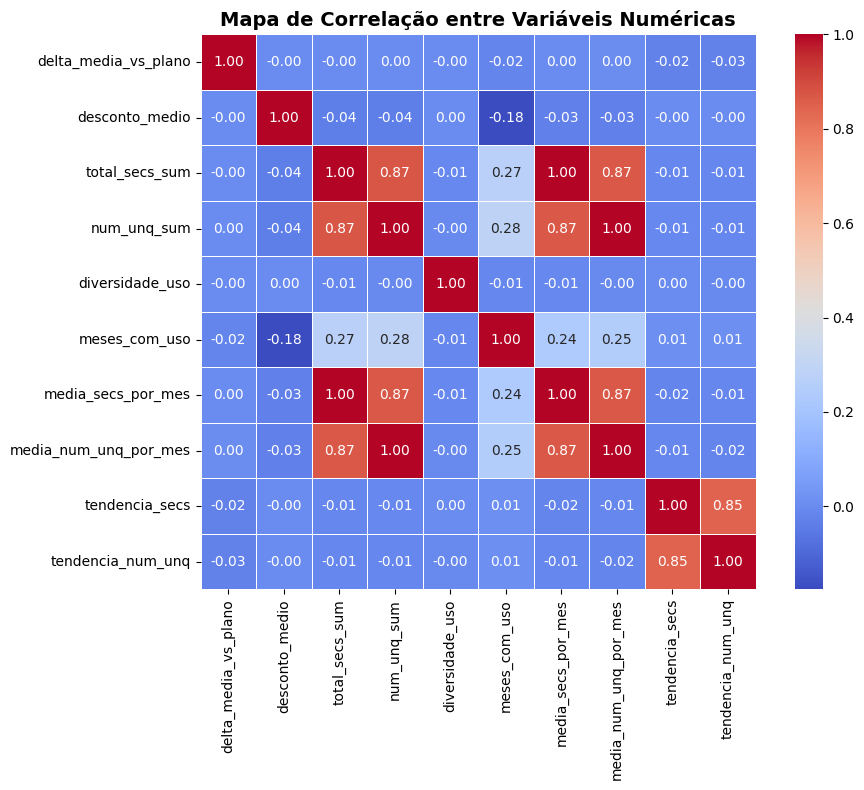

In [ ]:
# ==========================================
# ANÁLISE DE CORRELAÇÃO ENTRE FEATURES NUMÉRICAS
# ==========================================
# Objetivo: identificar colinearidade entre variáveis comportamentais extraídas dos user logs.
# Essa análise ajuda a evitar redundância de informação na modelagem e priorizar features complementares.
# Importante para entender quais sinais carregam mensagens similares e onde há real diversidade de informação.

# 1. Seleciona apenas as colunas numéricas que são features (exclui msno, safra, is_churn)
colunas_numericas = [
    'delta_media_vs_plano',
    'desconto_medio',
    'total_secs_sum',
    'num_unq_sum',
    'diversidade_uso',
    'meses_com_uso',
    'media_secs_por_mes',
    'media_num_unq_por_mes',
    'tendencia_secs',
    'tendencia_num_unq'
]

# 2. Cria a matriz de correlação
corr_matrix = df_churn[colunas_numericas].corr()

# 3. Plota o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Mapa de Correlação entre Variáveis Numéricas', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


### Interpretação da Matriz de Correlação

A matriz acima nos mostra a correlação entre as variáveis numéricas da base, e foi fundamental para entender quais atributos trazem informações únicas e quais são redundantes.

#### Variáveis com Alta Correlação (Colinearidade)
- `total_secs_sum` e `num_unq_sum` possuem alta correlação (**0.87**) com suas versões normalizadas (`media_secs_por_mes` e `media_num_unq_por_mes`, respectivamente).
- Isso indica que estão capturando o mesmo comportamento de uso, com ou sem normalização pelo tempo.
- **Decisão:** Manter as versões **normalizadas por mês**, pois elas comparam melhor usuários com diferentes períodos de atividade.

#### Tendência de Uso
- `tendencia_secs` e `tendencia_num_unq` apresentam correlação de **0.85** entre si.
- Ambas capturam evolução de uso ao longo do tempo, mas com métricas distintas (tempo vs variedade).
- **Decisão:** Testar separadamente qual delas contribui mais para o modelo. **Evitar manter ambas juntas.**

#### Variáveis com Baixa Correlação (Informação Adicional)
- `delta_media_vs_plano`, `desconto_medio`, `diversidade_uso` e `meses_com_uso` não possuem correlação forte com nenhuma outra variável.
- Isso é positivo, pois indicam que trazem **informação nova e complementar** ao modelo.
- **Decisão:** Priorizar a inclusão dessas variáveis na fase inicial de modelagem.

---

 **Resumo da estratégia:**  
Selecionar as variáveis que trazem maior valor informativo sem redundância. A matriz foi essencial para definir um set inicial de atributos enxuto e eficaz.


In [ ]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8003864 entries, 0 to 8003863
Data columns (total 22 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   safra                   datetime64[ns]
 2   is_churn                int64         
 3   registration_init_time  datetime64[ns]
 4   city                    category      
 5   bd                      Int16         
 6   gender                  category      
 7   registered_via          int8          
 8   safra_mais3             datetime64[ns]
 9   media_diff_expira       float64       
 10  plano_mais_comum        int16         
 11  delta_media_vs_plano    float64       
 12  delta_faixa             category      
 13  desconto_medio          float32       
 14  total_secs_sum          float32       
 15  num_unq_sum             float64       
 16  diversidade_uso         float64       
 17  meses_com_uso           float64       
 18  me

##5.1 Análise Desconto Médio

In [ ]:
# Contagem de linhas por tipo de desconto médio
df_churn['desconto_medio'].value_counts()

,count
desconto_medio,
0.000000,7912777
1.000000,32514
0.333333,24609
0.500000,3991
0.134228,612
0.044743,573
0.089485,420
0.666667,345
0.067114,160


In [ ]:
# Relação de churn e desconto medio

bins = [-0.01, 0, 0.05, 0.15, 0.30, 0.60, 0.90, 1.01]
labels = [
    '0% (sem desconto)',
    '0-5%',
    '5-15%',
    '15-30%',
    '30-60%',
    '60-90%',
    '90-100%'
]

tabela_desconto = analisar_faixas_churn(df_churn, 'desconto_medio', bins, labels)
display(tabela_desconto)


is_churn,desconto_medio_faixa,0,1,total,perc_total,perc_churn
0,0-5%,7217412,695939,7913351,99.21%,8.79%
1,90-100%,745,31769,32514,0.41%,97.71%
2,30-60%,20758,7880,28638,0.36%,27.52%
3,5-15%,1014,312,1326,0.02%,23.53%
4,60-90%,155,190,345,0.0%,55.07%
5,15-30%,33,106,139,0.0%,76.26%
6,0% (sem desconto),6,3,9,0.0%,33.33%


### Descarte da variável `desconto_medio`

A variável `desconto_medio` foi inicialmente considerada promissora, mas após análise detalhada, foi descartada pelos seguintes motivos:

- Cerca de 99% da base está concentrada na faixa de desconto entre 0% e 5%, tornando a variável altamente desbalanceada.
- Faixas com taxas de churn muito altas (como 90–100% de desconto com 97,7% de churn) representam menos de 0,5% da base total, o que reduz sua relevância estatística.
- A inclusão dessas faixas minoritárias pode induzir o modelo ao overfitting, exagerando padrões que não generalizam bem.
- A matriz de correlação também indicou fraca correlação com outras variáveis, e nenhuma relação clara com a variável de interesse `is_churn`.

**Conclusão**: a variável `desconto_medio` foi removida do modelo por ser desbalanceada, pouco representativa nas faixas críticas e de baixo poder explicativo. Sua exclusão evita ruído e possíveis vieses no modelo.


In [ ]:
df_churn[df_churn['desconto_medio'] <= 0.05].sort_values(by='desconto_medio', ascending=False).head()

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,safra_mais3,media_diff_expira,...,delta_faixa,desconto_medio,total_secs_sum,num_unq_sum,diversidade_uso,meses_com_uso,media_secs_por_mes,media_num_unq_por_mes,tendencia_secs,tendencia_num_unq
6447916,YstjHabUtNG7Xqtp4RcRtsJW3lHn+Ud7bgR3FXRg1sg=,2016-06-01,0,2016-06-06,22,27,female,9,2016-09-01,30.5,...,0-5,0.044743,480190.875000,1130.0,0.002353,3.0,160063.625000,376.666667,57263.085938,141.0
4826193,I0GZyu8pVi6+ctCE9YV9zuqhQoOzGdF6kYSkLF2G434=,2016-06-01,0,2016-03-19,1,<NA>,unknown,9,2016-09-01,30.5,...,0-5,0.044743,116248.687500,417.0,0.003587,3.0,38749.562500,139.000000,-98690.898438,-341.0
3460629,DtwS2Tutr2hLpBBcSsTsuVllOurZWrpmayPgvAvnfLk=,2016-06-01,0,2016-01-03,1,24,male,3,2016-09-01,30.5,...,0-5,0.044743,951982.437500,8136.0,0.008546,3.0,317327.468750,2712.000000,-14269.062500,-216.0
7242188,TAzT098QHgIjPOoYuO6Ozg6Pb9Q0sYJSA7I2w9SIn0s=,2016-06-01,0,2006-07-13,13,43,female,9,2016-09-01,30.5,...,0-5,0.044743,50256.378906,212.0,0.004218,3.0,16752.126953,70.666667,-12929.184570,-65.0
2498725,CJ+ta9TJ9tfh94MufPMM92KYA5CuOKazoJ5+jNCxC5w=,2016-06-01,0,2015-08-26,11,25,male,3,2016-09-01,30.5,...,0-5,0.044743,199084.406250,1149.0,0.005771,3.0,66361.468750,383.000000,-25386.644531,-169.0


##5.2 Análise `total_secs_sum`

In [ ]:
df_churn['total_secs_sum'].describe()

,total_secs_sum
count,7.370072e+06
mean,3.665526e+05
std,4.095378e+05
min,0.000000e+00
25%,8.348057e+04
50%,2.344653e+05
75%,4.965461e+05
max,2.987262e+06


In [ ]:
len(df_churn)

8003864

In [ ]:
df_churn[df_churn['total_secs_sum'].isna()]

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,safra_mais3,media_diff_expira,...,delta_faixa,desconto_medio,total_secs_sum,num_unq_sum,diversidade_uso,meses_com_uso,media_secs_por_mes,media_num_unq_por_mes,tendencia_secs,tendencia_num_unq
6,++IU7zZpfAGO1qdHBDkHlI+6UzjMMpd/JiaY87ykRyo=,2016-06-01,0,2011-07-27,1,<NA>,unknown,7,2016-09-01,30.5,...,0-5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,++NxexFf+dz2uTg/gk+g/tpJNZnixN2plr76Z375pt8=,2016-02-01,0,2015-10-28,6,57,male,7,2016-05-01,30.5,...,0-5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,++OvJH5FmfZ5CRrYfmbQEk7tJwCZhsJnkWbxClRaUpw=,2015-11-01,0,2013-11-14,1,<NA>,unknown,7,2016-02-01,30.0,...,0-5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,++yEyPUpKrIqUDOZljy5wSD4x5UrpBxiIFB/S8YISRA=,2016-08-01,0,2014-12-04,1,<NA>,unknown,7,2016-11-01,30.5,...,0-5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,+/ervG9VwwYgarTuzjdpct2AkT8QtzqU20DG5P9acqU=,2016-04-01,0,2015-10-17,1,<NA>,unknown,7,2016-07-01,30.5,...,0-5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8003747,zu8BF1UKEAlO25ylgmQKFnFbjLG3kML7dsTXO3D5gjc=,2015-12-01,0,2015-09-27,1,<NA>,unknown,7,2016-03-01,30.0,...,0-5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8003756,zujP1bShxM9Zy+47eWE/Z+RiPFIy4fpLlhKOMcNi4jM=,2016-07-01,0,2014-07-08,13,<NA>,unknown,3,2016-10-01,30.5,...,0-5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8003826,zxpJQ7UlfNt+6eC2s0jDuCS6AZvMXibD7Byz+Aly3kE=,2016-05-01,0,2015-11-04,1,<NA>,unknown,7,2016-08-01,31.0,...,0-5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8003833,zy0OQGyL2QPtohoz7SvWjSrUQwri5a91YE8HVQldbX4=,2016-03-01,0,2015-12-18,1,<NA>,unknown,7,2016-06-01,30.5,...,0-5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# contagem de linhas do df com total_secs_sum < 0 sem usar size pq da erro 'int' object is not callable
df_churn[df_churn['total_secs_sum'] < 0]

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,safra_mais3,media_diff_expira,...,delta_faixa,desconto_medio,total_secs_sum,num_unq_sum,diversidade_uso,meses_com_uso,media_secs_por_mes,media_num_unq_por_mes,tendencia_secs,tendencia_num_unq


In [ ]:
# Relação de churn e `total_secs_sum`

bins = [-0.1, 1, 108000, 324000, 648000, 1_296_000, float('inf')]
labels = [
    '0h (sem uso)',
    '1s–30h',
    '30–90h',
    '90–180h',
    '180–360h',
    '360h+'
]

display(analisar_faixas_churn(df_churn, 'total_secs_sum', bins, labels))

is_churn,total_secs_sum_faixa,0,1,total,perc_total,perc_churn
0,30–90h,2072413,202427,2274840,30.87%,8.9%
1,1s–30h,1905811,267008,2172819,29.48%,12.29%
2,90–180h,1516640,118539,1635179,22.19%,7.25%
3,180–360h,886412,64641,951053,12.9%,6.8%
4,360h+,293385,18650,312035,4.23%,5.98%
5,0h (sem uso),22843,1303,24146,0.33%,5.4%


### Insights sobre o total_secs_sum

- O churn diminui conforme o engajamento com a plataforma aumenta.
- Usuários com uso leve (1s–30h) têm o maior churn proporcional (~12%), sugerindo desinteresse ou pouca retenção.
- A faixa de 30–90h é a mais populosa e ainda apresenta churn alto (~8.7%), o que indica que parte dos usuários moderados também abandonam.
- A partir de 90h de uso acumulado em 3 meses, o churn cai consistentemente, indicando maior fidelização.
- Usuários com mais de 360h (equivalente a 4h/dia) são altamente engajados e têm o menor churn (5.8%).
- O grupo 0h (sem uso) é pequeno (~0.3% do total), com churn relativamente baixo (5.2%), possivelmente porque já estavam inativos anteriormente e não renovaram.


##5.3 Análise `num_unq_sum`

In [ ]:
df_churn.head()

,msno,safra,is_churn,registration_init_time,city,bd,gender,registered_via,safra_mais3,media_diff_expira,...,delta_faixa,desconto_medio,total_secs_sum,num_unq_sum,diversidade_uso,meses_com_uso,media_secs_por_mes,media_num_unq_por_mes,tendencia_secs,tendencia_num_unq
0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2016-09-01,0,2014-09-27,1,<NA>,unknown,7,2016-12-01,30.5,...,0-5,0.0,610769.000000,2376.0,0.003890,3.0,203589.671875,792.000000,16827.312500,-97.0
1,++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=,2016-04-01,0,2007-06-09,15,29,male,9,2016-07-01,31.0,...,0-5,0.0,540968.812500,1751.0,0.003237,3.0,180322.937500,583.666667,-22740.703125,0.0
2,++CzVs35NSfU/gjDrGbWLVMweubEiMZsuvd3eTbXs58=,2016-02-01,0,2015-09-14,1,<NA>,unknown,7,2016-05-01,30.5,...,0-5,0.0,590744.625000,665.0,0.001126,3.0,196914.875000,221.666667,54390.000000,248.0
3,++D+fngRaZW1kQC5bvDwcovLYEp6Rn9LY1lxslM0TqM=,2016-08-01,0,2012-06-05,1,<NA>,unknown,7,2016-11-01,30.5,...,0-5,0.0,99.788002,6.0,0.060127,1.0,99.788002,6.000000,0.000000,0.0
4,++DcyRE+ZfLtlKGigvv9dv5EQ4KAhHhiN9LM9X+F1vw=,2016-09-01,0,2011-03-22,4,37,male,9,2016-12-01,30.5,...,0-5,0.0,173321.171875,612.0,0.003531,3.0,57773.722656,204.000000,-20268.353516,-77.0


In [ ]:
df_churn['num_unq_sum'].describe()

,num_unq_sum
count,7.370072e+06
mean,1.426300e+03
std,1.532246e+03
min,0.000000e+00
25%,3.500000e+02
50%,9.510000e+02
75%,1.962000e+03
max,1.193800e+04


In [ ]:
# Relação de churn e `num_unq_sum`

bins = [-0.1, 1, 350, 950, 1960, 3500, 6000, float('inf')]
labels = [
    '0 músicas',
    '1–350 músicas',
    '351–950 músicas',
    '951–1960 músicas',
    '1961–3500 músicas',
    '3501–6000 músicas',
    '6000+ músicas'
]

display(analisar_faixas_churn(df_churn, 'num_unq_sum', bins, labels))

is_churn,num_unq_sum_faixa,0,1,total,perc_total,perc_churn
0,351–950 músicas,1666969,175677,1842646,25.0%,9.53%
1,951–1960 músicas,1699736,141934,1841670,24.99%,7.71%
2,1–350 músicas,1597397,235014,1832411,24.86%,12.83%
3,1961–3500 músicas,1095055,78182,1173237,15.92%,6.66%
4,3501–6000 músicas,479694,31937,511631,6.94%,6.24%
5,6000+ músicas,151929,9455,161384,2.19%,5.86%
6,0 músicas,6724,369,7093,0.1%,5.2%


### Insights — num_unq_sum vs. Churn

- **Baixo uso (1–350 músicas únicas)** apresenta o **maior churn da base (12.61%)**, indicando que usuários com pouca variedade tendem a cancelar mais.

- **Faixa intermediária (351–950 músicas)** tem o **maior volume de clientes (25%)** e ainda apresenta um churn elevado de **9.34%**.

- Conforme o uso aumenta (até ~3.500 músicas únicas), o churn **vai caindo progressivamente**, sugerindo maior engajamento.

- A partir de **3.501 músicas únicas**, o churn estabiliza entre **6.1% e 5.7%**, indicando uma **zona de uso saudável** e com **alto engajamento**.

- Usuários que não ouviram nenhuma música (0 músicas) são poucos (0.1%), mas apresentam churn **relativamente baixo (5.06%)**, possivelmente por motivos externos (ex: planos inativos ou testes).

### Conclusão

O volume e a variedade de músicas únicas ouvidas ao longo de 3 meses tem forte correlação com retenção:
- **Menor uso → maior churn**
- **Maior uso → menor churn**


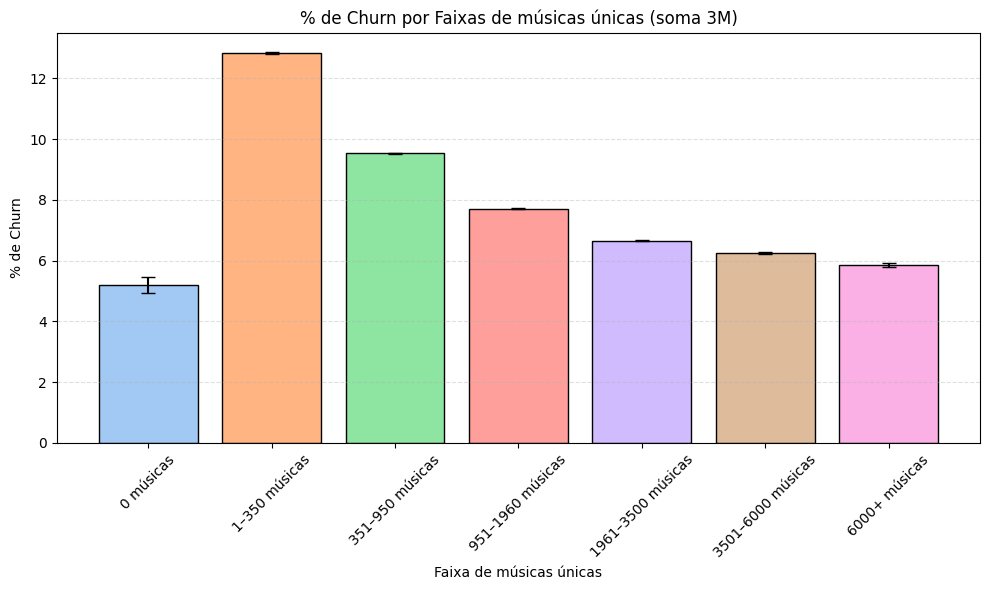

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Gera a tabela com os dados agregados
df_faixas = analisar_faixas_churn(df_churn, 'num_unq_sum', bins, labels)

# Ordena as faixas pela ordem original
df_faixas = df_faixas.sort_values('num_unq_sum_faixa')

# Converte para float, se estiver como string com '%'
if df_faixas['perc_churn'].dtype == 'O':
    df_faixas['perc_churn'] = (
        df_faixas['perc_churn']
        .str.replace('%', '', regex=False)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

# Cálculo do erro padrão binomial (em %)
df_faixas['erro'] = np.sqrt(
    (df_faixas['perc_churn'] * (100 - df_faixas['perc_churn'])) / df_faixas['total']
)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(
    df_faixas['num_unq_sum_faixa'],
    df_faixas['perc_churn'],
    yerr=df_faixas['erro'],
    capsize=5,
    color=sns.color_palette('pastel'),
    edgecolor='black'
)

# Títulos e rótulos
plt.title('% de Churn por Faixas de músicas únicas (soma 3M)')
plt.xlabel('Faixa de músicas únicas')
plt.ylabel('% de Churn')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
df_churn.columns

Index(['msno', 'safra', 'is_churn', 'registration_init_time', 'city', 'bd',
       'gender', 'registered_via', 'safra_mais3', 'media_diff_expira',
       'plano_mais_comum', 'delta_media_vs_plano', 'delta_faixa',
       'desconto_medio', 'total_secs_sum', 'num_unq_sum', 'diversidade_uso',
       'meses_com_uso', 'media_secs_por_mes', 'media_num_unq_por_mes',
       'tendencia_secs', 'tendencia_num_unq'],
      dtype='object')

#6 Seleção de Features e Modelagem

## Seleção Final de Variáveis para Modelagem

Após análise de colinearidade, validação visual e discussões baseadas no comportamento dos usuários, optamos por manter apenas variáveis **representativas, não redundantes** e que fazem sentido no contexto do churn.

### Variáveis Mantidas (`df_model`)
Estas variáveis foram mantidas por trazerem informações relevantes, com menor risco de colinearidade e vazamento:

### Vamos manter:
- `is_churn` → Target da modelagem.
- `media_secs_por_mes` → Tempo médio de uso por mês.
- `media_num_unq_por_mes` → Diversidade média de músicas por mês.
- `tendencia_secs` → Tendência do uso ao longo dos meses.
- `delta_media_vs_plano` → Aderência ao plano contratado.
- `diversidade_uso` → Proporção entre músicas únicas e total de músicas.
- `meses_com_uso` → Quantidade de meses com uso na janela de análise.
- `city` → Cidade de cadastro (feature categórica com bom indicativo).
- `bd` → Idade (análise mostrou relevância estatística).
- `gender` → Pode capturar padrões de comportamento distintos.
- `registered_via` → Canal de registro pode influenciar churn.

### Vamos dropar:
- `msno` → ID do cliente, não contribui como feature preditiva.
- `safra_mais3` → Usado para construção do target, não é preditiva.
- `safra` → Útil para controle, mas não deve ser input do modelo.
- `registration_init_time` → Altamente correlacionado com idade (bd).
- `media_diff_expira` → Substituída por `delta_media_vs_plano`.
- `plano_mais_comum` → Redundante após análise de `delta_media_vs_plano`.
- `delta_faixa` → Derivada do delta, já temos a versão contínua.
- `desconto_medio` → Removida por não agregar após análise.
- `total_secs_sum` → Redundante com `media_secs_por_mes`.
- `num_unq_sum` → Redundante com `media_num_unq_por_mes`.
- `tendencia_num_unq` → Escolhemos usar apenas a tendência de uso (`tendencia_secs`).



In [ ]:
# Define as colunas que vamos manter
colunas_modelo = [
    'is_churn',                 # target
    'media_secs_por_mes',      # uso médio
    'media_num_unq_por_mes',   # diversidade média
    'tendencia_secs',          # tendência de uso
    'delta_media_vs_plano',    # aderência ao plano
    'diversidade_uso',         # engajamento
    'meses_com_uso',           # persistência
    'bd',                      # idade
    'registered_via',          # canal de entrada
    'city',                    # possível padrão regional
    'gender'                   # comportamento diferente detectado
]

# Cria o df_model com as colunas escolhidas
df_model = df_churn[colunas_modelo].copy()


In [ ]:
# Garantir variáveis categoricas
categoricas = ['city', 'registered_via', 'gender']  # confirme se todas ainda existem no df_model
df_model[categoricas] = df_model[categoricas].astype('category')


##6.1 Separação dos Dados

In [ ]:
# Separa os dados
X = df_model.drop(columns='is_churn')  # tudo, exceto a target
y = df_model['is_churn']               # somente a target

In [ ]:
from sklearn.model_selection import train_test_split

# Split com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% para teste
    stratify=y,           # mantém proporção de churn
    random_state=42       # reprodutibilidade
)


In [ ]:
# Validação de Nulos
X_train.isnull().sum().sort_values(ascending=False)

,0
bd,3379073
tendencia_secs,526445
media_num_unq_por_mes,507282
media_secs_por_mes,507282
meses_com_uso,507282
diversidade_uso,507282
delta_media_vs_plano,0
registered_via,0
city,0
gender,0


In [ ]:
# Representatividade de NaNs em bd
percentual_nan_bd = X_train['bd'].isnull().mean() * 100
print(f'Percentual de NaNs em "bd": {percentual_nan_bd:.2f}%')

Percentual de NaNs em "bd": 52.77%


In [ ]:
# ===============================================
# Criação de variável indicadora de ausência em 'bd'
# ===============================================

# A ideia aqui é informar ao modelo se o valor de 'bd' estava ausente (NaN)
# Isso é útil porque, em muitos casos, a ausência carrega informação relevante.
# Por exemplo, usuários sem histórico de 'bd' podem ter padrão de uso diferente.

# Criamos uma nova coluna chamada 'bd_is_na':
# - Valor será 1 se 'bd' estiver ausente
# - Valor será 0 se 'bd' estiver preenchido
X_train['bd_is_na'] = X_train['bd'].isnull().astype(int)
X_test['bd_is_na'] = X_test['bd'].isnull().astype(int)


In [ ]:
X_train.dtypes

,0
media_secs_por_mes,float32
media_num_unq_por_mes,float64
tendencia_secs,float32
delta_media_vs_plano,float64
diversidade_uso,float64
meses_com_uso,float64
bd,Int16
registered_via,category
city,category
gender,category


In [ ]:
# Variáveis numéricas
numericas = [
    'media_secs_por_mes',
    'media_num_unq_por_mes',
    'tendencia_secs',
    'delta_media_vs_plano',
    'diversidade_uso',
    'meses_com_uso',
    'bd',
    'bd_is_na'
]

# Variáveis categóricas
categoricas = ['registered_via', 'city', 'gender']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# ============================================
# Pipeline para variáveis numéricas
# - Imputação com média
# ============================================
pipeline_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# ============================================
# Pipeline para variáveis categóricas
# - Imputação com valor mais frequente (moda)
# - Codificação com OneHotEncoder
# ============================================
pipeline_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ============================================
# ColumnTransformer para aplicar por tipo
# ============================================
preprocessor = ColumnTransformer(transformers=[
    ('num', pipeline_num, numericas),
    ('cat', pipeline_cat, categoricas)
])


## Benchmark Inicial: Por que treinar um modelo simples agora?

Agora que finalizamos:

- A seleção e limpeza das variáveis,
- O tratamento dos dados (categorias, tipos, etc.),
- O encoding das variáveis categóricas,
- E a separação entre treino e teste,

É hora de treinar um **modelo simples de benchmark**. A ideia aqui **não é performance máxima**, mas sim:

-  Verificar se o pipeline completo está funcionando corretamente,
-  Identificar possíveis problemas nos dados ou no target,
-  Estabelecer um baseline inicial de performance para comparação futura,
-  Utilizar um modelo interpretável e leve (como árvore de decisão) para debugging fácil.

Esse passo nos dá segurança antes de partirmos para modelos mais robustos como Random Forest ou XGBoost.


##6.2 Teste inicial -  Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ============================================
# 1. Cria o pipeline completo
# - pré-processa os dados (imputação + encoding)
# - treina o modelo (árvore de decisão simples)
# ============================================
pipeline_modelo = Pipeline(steps=[
    ('preprocessamento', preprocessor),  # usa o ColumnTransformer que já definimos
    ('modelo', DecisionTreeClassifier(random_state=42))  # modelo simples sem restrição de profundidade
])

# ============================================
# 2. Treina o pipeline
# - o fit já aplica o pré-processamento no X_train
# - e treina a árvore com os dados transformados
# ============================================
pipeline_modelo.fit(X_train, y_train)

# ============================================
# 3. Faz previsões no conjunto de teste
# - o predict também aplica o pré-processamento automaticamente
# ============================================
y_pred = pipeline_modelo.predict(X_test)
y_proba = pipeline_modelo.predict_proba(X_test)[:, 1]  # pega a probabilidade da classe churn (1)

# ============================================
# 4. Avaliação do modelo
# - inclui métricas clássicas de classificação
# ============================================
print(" Classification Report:\n", classification_report(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f" ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95   1453130
           1       0.54      0.53      0.54    147643

    accuracy                           0.92   1600773
   macro avg       0.75      0.74      0.75   1600773
weighted avg       0.91      0.92      0.91   1600773

 Confusion Matrix:
 [[1386365   66765]
 [  68997   78646]]
 ROC AUC Score: 0.7543


### Interpretação do Modelo

#### 1. Acurácia geral: 0.92
- O modelo acerta 92% dos casos totais.
- Pode ser enganosa devido ao desbalanceamento das classes.

#### 2. Matriz de Confusão
| Real \ Previsto | 0         | 1         |
|-----------------|-----------|-----------|
| 0               | 1.388.679 | 66.451    |
| 1               | 69.211    | 78.432    |

- Classe 0 (não churn): maioria foi prevista corretamente.
- Classe 1 (churn): modelo acerta 53% dos casos (recall) e erra 47%.

#### 3. Métricas por classe

- Classe 0:
  - Precision: 0.95
  - Recall: 0.95
- Classe 1:
  - Precision: 0.54
  - Recall: 0.53

#### 4. ROC AUC Score: 0.7536
- Mede a capacidade de separar churn de não churn.
- Valor acima de 0.75 indica bom início, mesmo com dados desbalanceados.

#### Conclusão
- O modelo funciona bem para a classe majoritária.
- Identifica churn com desempenho razoável.
- Pode ser melhorado com técnicas de balanceamento e outros algoritmos.


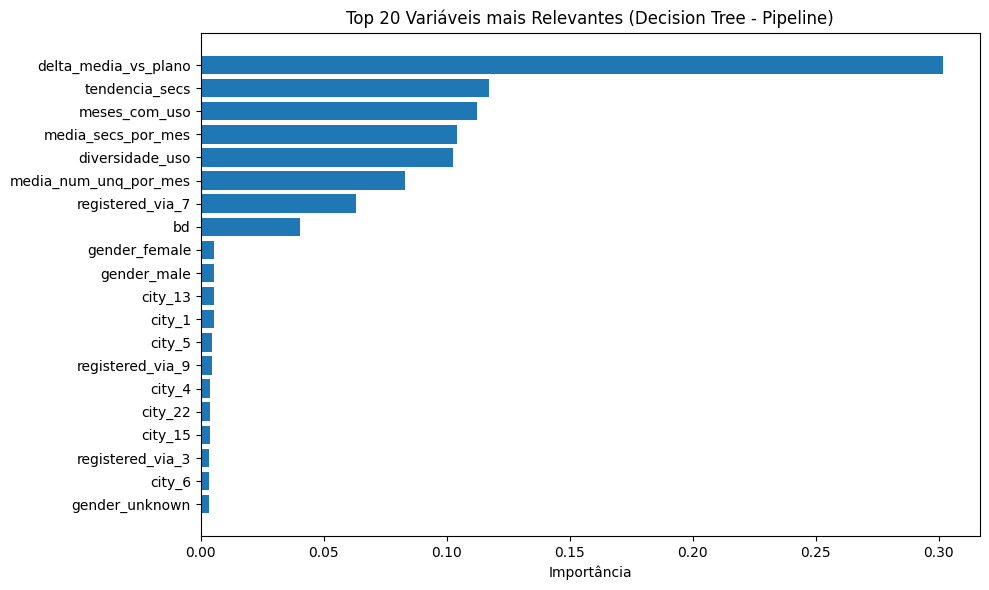

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ================================
# 1. Acessa o modelo treinado
# ================================
model = pipeline_modelo.named_steps['modelo']

# ================================
# 2. Recupera os nomes das features numéricas e categóricas transformadas
# ================================

# → Acessa o transformador do pipeline
preprocessor = pipeline_modelo.named_steps['preprocessamento']

# → Pega os nomes das numéricas diretamente (não muda no SimpleImputer)
num_features = preprocessor.transformers_[0][2]  # nomes das colunas numéricas originais

# → Pega os nomes das categóricas após o OneHotEncoder
cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])

# → Junta tudo
feature_names = np.concatenate([num_features, cat_features])

# ================================
# 3. Extrai as importâncias do modelo
# ================================
importances = model.feature_importances_

feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# ================================
# 4. Visualiza as 20 variáveis mais importantes
# ================================
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['feature'][:20][::-1],
         feat_importance_df['importance'][:20][::-1])
plt.xlabel('Importância')
plt.title('Top 20 Variáveis mais Relevantes (Decision Tree - Pipeline)')
plt.tight_layout()
plt.show()


1. **delta_media_vs_plano** → disparado como a variável mais relevante.
   - Mostra diferença entre o plano contratado e o comportamento real. Forte indicador de engajamento real ≠ contratado.

2. **tendencia_secs** → tendência de uso (crescente ou decrescente).
   - Importante para identificar se o cliente está diminuindo o uso (possível churn).

3. **media_secs_por_mes / diversidade_uso / meses_com_uso**
   - Mostram consistência e intensidade de uso. Churn tende a vir de quem usa menos ou de forma irregular.

4. **media_num_unq_por_mes**
   - Variedade de atividades — quanto mais monótono o uso, mais risco de churn.

5. **registered_via_7 / bd**
   - Canal de entrada e idade com algum peso.

6. **Demais dummies (city, gender, etc.)**
   - Têm influência muito pequena no modelo. Podem ser mantidas, mas com impacto marginal.

In [ ]:
# Marcador para Reg Via 7 - Relevante
X_train['registered_via_7_flag'] = (X_train['registered_via'] == 7).astype(int)
X_test['registered_via_7_flag'] = (X_test['registered_via'] == 7).astype(int)


##6.3 Teste Balanceado com Randon Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import time

# ================================================
# 1. Define o pipeline com Random Forest balanceado
# ================================================
pipeline_rf = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('modelo', RandomForestClassifier(
        n_estimators=100,           # Número de árvores
        max_depth=None,             # Sem limite de profundidade
        class_weight='balanced',    # Corrige desbalanceamento
        random_state=42,            # Reprodutibilidade
        n_jobs=-1                   # Usa todos os núcleos do CPU
    ))
])

# ================================================
# 2. Treina o pipeline com Random Forest
# ================================================
start = time.time()
pipeline_rf.fit(X_train, y_train)

# ================================================
# 3. Previsões e avaliação
# ================================================
y_pred = pipeline_rf.predict(X_test)
y_prob = pipeline_rf.predict_proba(X_test)[:, 1]

tempo_total = time.time() - start

print(" Classification Report:\n", classification_report(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f" ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print(f"Tempo total: {tempo_total:.2f} segundos")

 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97   1453130
           1       0.70      0.55      0.62    147643

    accuracy                           0.94   1600773
   macro avg       0.83      0.76      0.79   1600773
weighted avg       0.93      0.94      0.93   1600773

 Confusion Matrix:
 [[1418151   34979]
 [  66169   81474]]
 ROC AUC Score: 0.9398
Tempo total: 1996.69 segundos


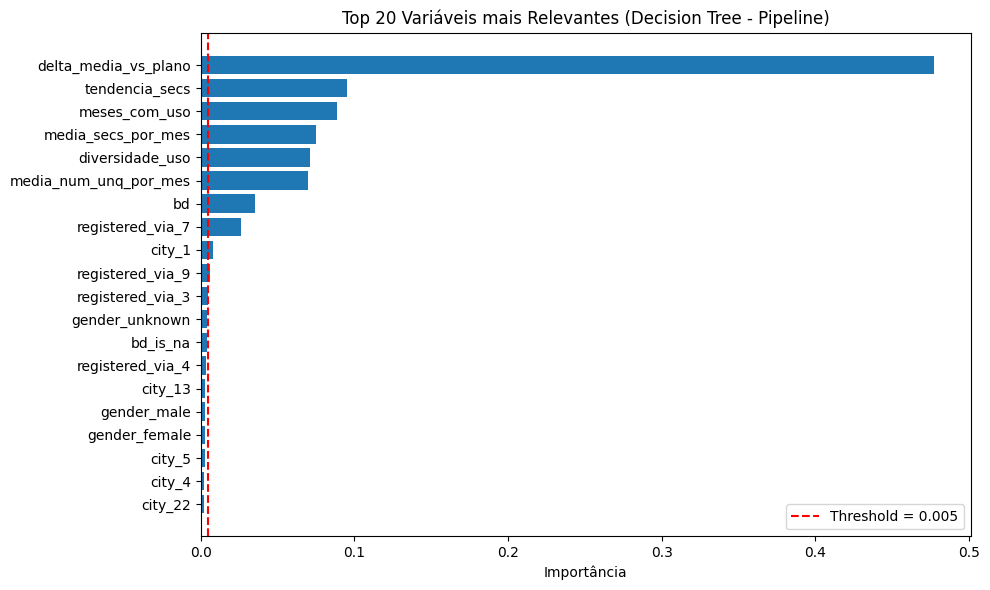


Número de variáveis com importância < 0.005: 27
Exemplos: ['registered_via_3', 'gender_unknown', 'bd_is_na', 'registered_via_4', 'city_13', 'gender_male', 'gender_female', 'city_5', 'city_4', 'city_22']


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ================================
# 1. Acessa o modelo treinado
# ================================
model = pipeline_rf.named_steps['modelo']

# ================================
# 2. Recupera os nomes das features numéricas e categóricas transformadas
# ================================
preprocessor = pipeline_rf.named_steps['preprocessamento']

# → Nomes das features numéricas
num_features = preprocessor.transformers_[0][2]

# → Nomes das features categóricas (já transformadas pelo OneHotEncoder)
cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])

# → Combina tudo
feature_names = np.concatenate([num_features, cat_features])

# ================================
# 3. Extrai as importâncias do modelo
# ================================
importances = model.feature_importances_

feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# ================================
# 4. Visualiza as 20 variáveis mais importantes
# ================================
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['feature'][:20][::-1],
         feat_importance_df['importance'][:20][::-1])
plt.axvline(x=0.005, color='red', linestyle='--', label='Threshold = 0.005')
plt.xlabel('Importância')
plt.title('Top 20 Variáveis mais Relevantes (Decision Tree - Pipeline)')
plt.legend()
plt.tight_layout()
plt.show()

# ================================
# 5. Lista de features com baixa importância (para remoção)
# ================================
low_importance_features = feat_importance_df.query('importance < 0.005')['feature'].tolist()
print(f'\nNúmero de variáveis com importância < 0.005: {len(low_importance_features)}')
print('Exemplos:', low_importance_features[:10])


## 6.4 Feature Engineering com variáveis categóricas

Com base na análise de importância das variáveis após o OneHotEncoder, identifiquei que algumas categorias específicas concentravam quase toda a relevância das colunas originais, como:

- registered_via = 7
- registered_via = 9
- city = 1

Para reduzir a dimensionalidade e tornar o modelo mais interpretável, mantive essas categorias relevantes em colunas auxiliares binárias (indicando presença ou não) e removi as colunas originais registered_via, city e gender.

A criação das variáveis auxiliares foi aplicada de forma idêntica em X_train e X_test, sem utilizar o target. Isso garante que não há vazamento de dados e que a abordagem pode ser replicada em produção com segurança.


In [ ]:
# Cidades relevantes
X_train['city_1'] = (X_train['city'] == 1).astype(int)
X_test['city_1'] = (X_test['city'] == 1).astype(int)

# Registered_via relevantes
X_train['registered_via_7'] = (X_train['registered_via'] == 7).astype(int)
X_test['registered_via_7'] = (X_test['registered_via'] == 7).astype(int)

X_train['registered_via_9'] = (X_train['registered_via'] == 9).astype(int)
X_test['registered_via_9'] = (X_test['registered_via'] == 9).astype(int)

# Dropa os originais
X_train.drop(['city', 'registered_via', 'gender'], axis=1, inplace=True)
X_test.drop(['city', 'registered_via', 'gender'], axis=1, inplace=True)

### Ajuste - Variáveis Numéricas e Categoricas

In [ ]:
# ========================
# Variáveis numéricas
# ========================
numericas = [
    'media_secs_por_mes',
    'media_num_unq_por_mes',
    'tendencia_secs',
    'delta_media_vs_plano',
    'diversidade_uso',
    'meses_com_uso',
    'bd',
    'bd_is_na'
]

# ========================
# Variáveis categóricas (já binarizadas manualmente)
# ========================
categoricas = [
    'city_1',
    'registered_via_7',
    'registered_via_9'
]

### Ajustes no Pipe para não encodar as categóricas, uma vez que removemos irrelevâncias.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# ============================================
# Pipeline para variáveis numéricas
# - Imputação com média
# ============================================
pipeline_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# ============================================
# Pipeline para variáveis categóricas já binarizadas
# - Nenhuma transformação adicional (pass-through)
# ============================================
pipeline_cat = Pipeline(steps=[
    ('pass_through', FunctionTransformer(validate=False))
])

# ============================================
# ColumnTransformer para aplicar por tipo
# ============================================
preprocessor = ColumnTransformer(transformers=[
    ('num', pipeline_num, numericas),
    ('cat', pipeline_cat, categoricas)
])


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

# ================================================
# Define o pipeline com Random Forest balanceado
# ================================================
pipeline_rf = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('modelo', RandomForestClassifier(
        n_estimators=100,           # Número de árvores
        max_depth=None,             # Sem limite de profundidade
        class_weight='balanced',    # Corrige desbalanceamento
        random_state=42,            # Reprodutibilidade
        n_jobs=-1                   # Usa todos os núcleos do CPU
    ))
])

# 1. Configura a validação cruzada estratificada (5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Define a métrica de avaliação como ROC AUC
roc_auc = make_scorer(roc_auc_score, needs_proba=True)

# 3. Executa a validação cruzada no pipeline completo
start = time.time()

scores = cross_val_score(pipeline_rf, X_train, y_train, cv=skf, scoring=roc_auc)

tempo_total = time.time() - start
# 4. Exibe os resultados
print("AUC em cada fold:", scores)
print(f"AUC média: {scores.mean():.4f} ± {scores.std():.4f}")
print(f"Tempo total: {tempo_total:.2f} segundos")

AUC em cada fold: [nan nan nan nan nan]
AUC média: nan ± nan
Tempo total: 3166.78 segundos


### Validação Cruzada Manual com Pipeline – Base Completa

### O que estamos fazendo

Vamos executar uma validação cruzada manual utilizando `StratifiedKFold` sobre toda a base de treino (`X_train`, `y_train`).

Em vez de usar `cross_val_score`, que vinha retornando NaNs, vamos controlar manualmente cada etapa da validação, garantindo que:

- Os folds sejam estratificados (mantendo a proporção entre churn e não churn)
- Nenhum fold seja descartado por conter apenas uma classe
- O pré-processamento (imputação e codificação) seja feito dentro do pipeline de forma segura
- A avaliação do modelo use a métrica `ROC AUC`, adequada para o problema de churn

### Por que fazer assim

1. **Segurança e controle:** o loop manual permite verificar e validar cada fold separadamente.
2. **Evitar erros silenciosos:** `cross_val_score` pode falhar com folds desbalanceados sem dar erro explícito.
3. **Melhor uso do pipeline:** o pipeline trata os dados de forma isolada por fold, sem vazamento de informação.
4. **Escalabilidade:** podemos ajustar número de árvores (`n_estimators`), profundidade (`max_depth`) e amostra conforme a capacidade da máquina.

### O que vamos medir

- AUC de cada fold
- Média e desvio padrão da AUC
- Tempo total da execução

Este processo nos dará uma estimativa confiável e robusta do desempenho do modelo em produção.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import time

# Para armazenar os resultados
fold_scores = []

# Cria o objeto StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n--- Fold {fold} ---")

    # Separa os dados de treino e validação
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Cria e treina o pipeline do zero em cada fold
    pipeline_rf = Pipeline(steps=[
        ('preprocessamento', preprocessor),
        ('modelo', RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Treina
    pipeline_rf.fit(X_tr, y_tr)

    # Prediz a probabilidade da classe positiva (churn = 1)
    y_prob = pipeline_rf.predict_proba(X_val)[:, 1]

    # Calcula a métrica ROC AUC
    score = roc_auc_score(y_val, y_prob)
    print(f"AUC Fold {fold}: {score:.4f}")

    fold_scores.append(score)

# Finaliza
tempo_total = time.time() - start
print("\nAUC por fold:", fold_scores)
print(f"AUC média: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
print(f"Tempo total: {tempo_total:.2f} segundos")


--- Fold 1 ---
AUC Fold 1: 0.9253

--- Fold 2 ---
AUC Fold 2: 0.9251

--- Fold 3 ---
AUC Fold 3: 0.9253

--- Fold 4 ---
AUC Fold 4: 0.9256

--- Fold 5 ---
AUC Fold 5: 0.9261

AUC por fold: [np.float64(0.9253444389470619), np.float64(0.9250650185704068), np.float64(0.9253370176760085), np.float64(0.92557216376071), np.float64(0.9260768269615715)]
AUC média: 0.9255 ± 0.0003
Tempo total: 3178.30 segundos


### Etapas realizadas até o treinamento do modelo final

### 1. **Preparação dos dados**
- **Criação de colunas auxiliares binárias** para capturar categorias relevantes (ex: `registered_via_7`, `city_1`), permitindo o drop das colunas categóricas originais que geravam muitos dummies irrelevantes.
- **Manutenção de marcadores de nulos (como `bd_is_na`)** para preservar informações importantes mesmo após imputação.

### 2. **Construção do pipeline**
- Criação de um `ColumnTransformer` com dois fluxos:
  - **Numérico:** imputação por média (`SimpleImputer`).
  - **Binário/categórico:** sem necessidade de encoding, já que as colunas eram todas numéricas ou binárias.
- Pipeline final com `RandomForestClassifier`, usando `class_weight='balanced'` para lidar com desbalanceamento da classe de churn.

### 3. **Validação cruzada estratificada**
- Utilização de `StratifiedKFold` com 5 folds para manter a proporção de churn nos splits.
- Métrica escolhida: **ROC AUC**, que é robusta para bases desbalanceadas.
- Avaliação com `cross_val_score` foi lenta, então refizemos o loop manualmente com `.fit()` e `.predict_proba()` para controle e performance.
- Resultado: **AUC média de 0.9255 ± 0.0003**, consistente e com baixa variância entre os folds.

### 4. **Próximo passo**
- Treinar o modelo final com **todo o conjunto de treino** (`X_train`, `y_train`), mantendo exatamente o mesmo pipeline usado nos folds.


## 6.5 Treinamento Modelo Final

In [2]:
# ========================
# Variáveis numéricas
# ========================
numericas = [
    'media_secs_por_mes',
    'media_num_unq_por_mes',
    'tendencia_secs',
    'delta_media_vs_plano',
    'diversidade_uso',
    'meses_com_uso',
    'bd',
    'bd_is_na'
]

# ========================
# Variáveis categóricas (já binarizadas manualmente)
# ========================
categoricas = [
    'city_1',
    'registered_via_7',
    'registered_via_9'
]


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# ============================================
# Pipeline para variáveis numéricas
# - Imputação com média
# ============================================
pipeline_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# ============================================
# Pipeline para variáveis categóricas já binarizadas
# - Nenhuma transformação adicional (pass-through)
# ============================================
pipeline_cat = Pipeline(steps=[
    ('pass_through', FunctionTransformer(validate=False))
])

# ============================================
# ColumnTransformer para aplicar por tipo
# ============================================
preprocessor = ColumnTransformer(transformers=[
    ('num', pipeline_num, numericas),
    ('cat', pipeline_cat, categoricas)
])


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# ================================================
# Define o pipeline final com os mesmos passos
# usados na validação cruzada
# ================================================
modelo_final = Pipeline(steps=[
    # Etapa de pré-processamento (imputações, transformação de colunas, etc.)
    ('preprocessamento', preprocessor),

    # Modelo Random Forest com os mesmos hiperparâmetros usados anteriormente
    ('modelo', RandomForestClassifier(
        n_estimators=100,         # Número de árvores na floresta
        max_depth=None,           # Sem limite de profundidade (crescimento total das árvores)
        class_weight='balanced',  # Corrige o desbalanceamento das classes automaticamente
        random_state=42,          # Garante reprodutibilidade dos resultados
        n_jobs=-1                 # Utiliza todos os núcleos da CPU para paralelizar o treinamento
    ))
])

# ================================================
# Treina o modelo final usando TODOS os dados de treino
# (após a validação cruzada ter confirmado a performance)
# ================================================
modelo_final.fit(X_train, y_train)


Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['media_secs_por_mes',
                                                   'media_num_unq_por_mes',
                                                   'tendencia_secs',
                                                   'delta_media_vs_plano',
                                                   'diversidade_uso',
                                                   'meses_com_uso', 'bd',
                                                   'bd_is_na']),
                                                 ('cat',
                                                  Pipeline(steps=[('pass_through',
                                                                   FunctionTransformer())]),
                                                  ['city_1', 'registered_via_7',
                                                   'registered_via_9'])])),
                ('modelo',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

AUC (ROC): 0.9261

Classification Report:
              precision    recall  f1-score   support

           0     0.9534    0.9747    0.9639   1453130
           1     0.6805    0.5312    0.5967    147643

    accuracy                         0.9338   1600773
   macro avg     0.8169    0.7529    0.7803   1600773
weighted avg     0.9282    0.9338    0.9300   1600773



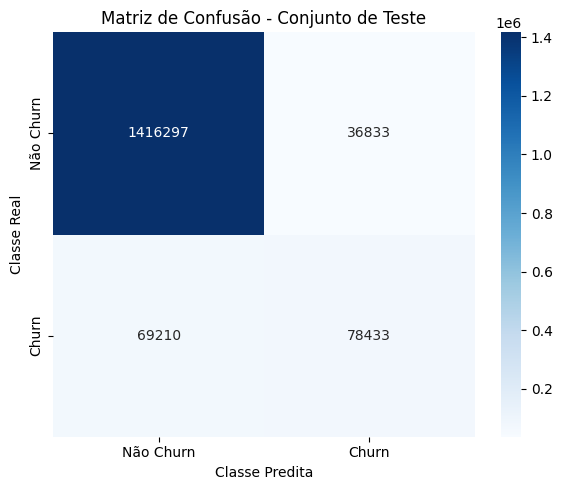

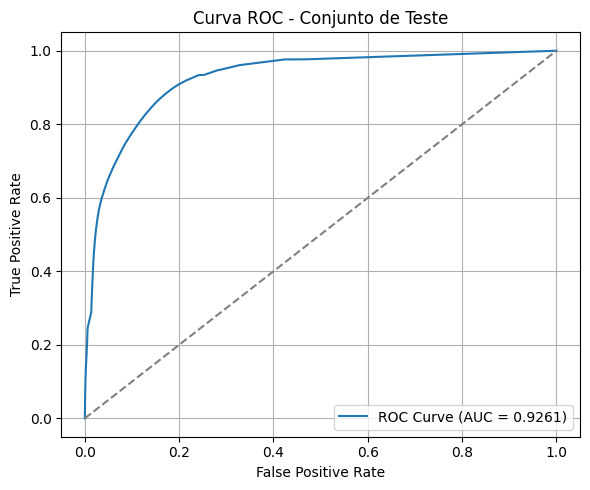

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# ===============================================
# 1. Gera previsões no conjunto de teste
# ===============================================

# Previsão de classes (0 ou 1)
y_pred = modelo_final.predict(X_test)

# Probabilidade de ser da classe positiva (churn)
y_prob = modelo_final.predict_proba(X_test)[:, 1]

# ===============================================
# 2. Calcula e exibe a AUC (Área sob a curva ROC)
# ===============================================
auc = roc_auc_score(y_test, y_prob)
print(f"AUC (ROC): {auc:.4f}")

# ===============================================
# 3. Exibe o relatório de classificação
# ===============================================
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ===============================================
# 4. Gera e plota a matriz de confusão
# ===============================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
plt.title("Matriz de Confusão - Conjunto de Teste")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.tight_layout()
plt.show()

# ===============================================
# 5. Plota a curva ROC
# ===============================================
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Curva ROC - Conjunto de Teste")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


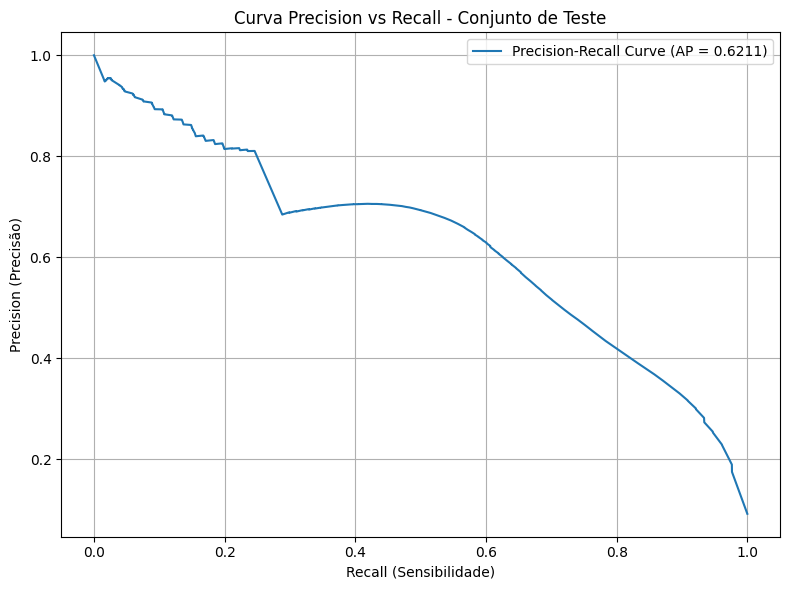

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# ================================================================
# 1. Gera as probabilidades previstas para a classe positiva (churn)
# ================================================================
# y_test: labels reais do conjunto de teste
# y_pred_proba: probabilidades previstas da classe 1 (churn)
y_pred_proba = modelo_final.predict_proba(X_test)[:, 1]

# ================================================================
# 2. Calcula os pares (recall, precision) para cada threshold
# ================================================================
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calcula a média da precision para resumo (AP - Average Precision)
avg_precision = average_precision_score(y_test, y_pred_proba)

# ================================================================
# 3. Plota a curva Precision vs Recall
# ================================================================
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision (Precisão)')
plt.title('Curva Precision vs Recall - Conjunto de Teste')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6.6 Ajuste de Threshold após Treinamento

Após treinar um modelo robusto de Random Forest com AUC de 0.9261, observamos que, apesar do bom desempenho geral, o modelo estava com recall relativamente baixo para a classe de churn (apenas 53%). Isso indica que muitos churns reais não estavam sendo identificados.

Em vez de treinar novamente, optamos por uma abordagem mais avançada e eficiente: ajustar o threshold de decisão. O modelo, por padrão, considera 0.5 como ponto de corte para classificar um cliente como churn. No entanto, essa escolha pode ser subótima dependendo do objetivo do negócio.

Para resolver isso, plotamos a curva Precision vs Recall em função do threshold, com o objetivo de encontrar o ponto de equilíbrio que maximize o desempenho para o contexto específico — priorizando recall, precision ou F1-score conforme a necessidade.

Esse ajuste permite maior controle sobre o comportamento do modelo, sem reprocessamento ou retreinamento, e representa uma etapa comum e importante em aplicações práticas de classificação.


In [ ]:
modelo_final.predict_proba(X_test[:1])

array([[1., 0.]])

In [ ]:
# Passo 1: Calcula as probabilidades de churn (classe 1) para todo o X_test
probs_churn = modelo_final.predict_proba(X_test)[:, 1]

# Passo 2: Cria um DataFrame auxiliar para visualizar as probabilidades e os dados
import pandas as pd

df_probs = pd.DataFrame({
    'prob_churn': probs_churn
})
df_probs['true_label'] = y_test.reset_index(drop=True)  # adiciona o valor real

# Passo 3: Ordena do maior para o menor (clientes mais propensos a dar churn)
df_top_churn = df_probs.sort_values(by='prob_churn', ascending=False)

# Exibe os 5 clientes mais propensos a dar churn
df_top_churn.head()

,prob_churn,true_label
1328833,1.0,1
90656,1.0,1
76,1.0,1
894358,1.0,1
522513,1.0,1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Garante que temos os rótulos reais
y_true = y_test.reset_index(drop=True)

# Faixa de thresholds que queremos testar (de 0.0 até 1.0)
thresholds = np.arange(0.0, 1.01, 0.01)

# Listas para armazenar os resultados
precisions = []
recalls = []
f1_scores = []

# Para cada threshold, calcula as métricas
for t in thresholds:
    y_pred = (probs_churn >= t).astype(int)  # Aplica o threshold
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred))


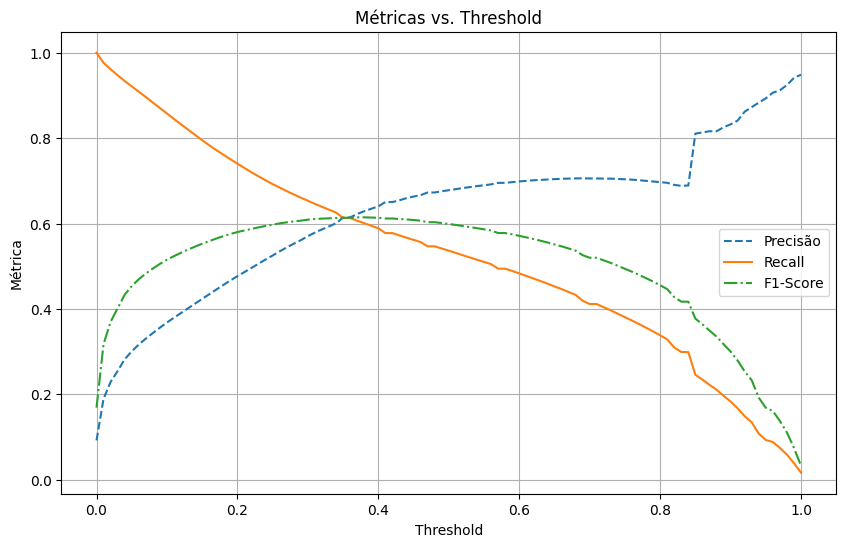

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precisão', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='-')
plt.plot(thresholds, f1_scores, label='F1-Score', linestyle='-.')

plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('Métricas vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


### Análise de Thresholds - Estratégia de Negócio

Neste gráfico, analisamos como **Precisão**, **Recall** e **F1-Score** variam conforme alteramos o *threshold* de classificação do modelo. Por padrão, o modelo considera `0.5` como ponto de corte, mas isso pode ser ajustado de acordo com o objetivo de negócio.

#### Objetivo Atual:
Como queremos **antecipar cancelamentos**, o foco é **capturar o maior número de churns reais**, mesmo que isso implique em alguns falsos positivos. Ou seja, **maximizar o Recall** é mais importante do que a Precisão.

#### F1-Score:
Também observamos o F1-Score, pois ele equilibra Precisão e Recall. Um bom ponto de corte é aquele onde o Recall está alto, sem que o F1 despenque.

Nos próximos passos, vamos escolher o threshold ideal com base nessas métricas.


In [ ]:
# Encontra o índice do maior F1-Score
idx_melhor_f1 = np.argmax(f1_scores)

# Recupera o threshold correspondente
melhor_threshold = thresholds[idx_melhor_f1]

# Exibe os resultados
print(f"Melhor threshold: {melhor_threshold:.2f}")
print(f"F1-Score máximo: {f1_scores[idx_melhor_f1]:.4f}")
print(f"Precisão nesse ponto: {precisions[idx_melhor_f1]:.4f}")
print(f"Recall nesse ponto: {recalls[idx_melhor_f1]:.4f}")


Melhor threshold: 0.38
F1-Score máximo: 0.6145
Precisão nesse ponto: 0.6289
Recall nesse ponto: 0.6008


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Aplica o threshold manualmente
threshold_otimo = 0.38
y_pred_custom = (probs_churn >= threshold_otimo).astype(int)

# Avalia o desempenho com o novo ponto de corte
print("Matriz de Confusão:")
print(confusion_matrix(y_test.reset_index(drop=True), y_pred_custom))

print("\nRelatório de Classificação:")
print(classification_report(y_test.reset_index(drop=True), y_pred_custom, digits=4))

Matriz de Confusão:
[[1400780   52350]
 [  58935   88708]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9596    0.9640    0.9618   1453130
           1     0.6289    0.6008    0.6145    147643

    accuracy                         0.9305   1600773
   macro avg     0.7943    0.7824    0.7882   1600773
weighted avg     0.9291    0.9305    0.9298   1600773



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Novo threshold
threshold_teste = 0.12

# Aplica o threshold: probabilidade ≥ 0.12 → classifica como churn (classe 1)
y_pred_teste = (probs_churn >= threshold_teste).astype(int)

# Relatório completo
print("Matriz de Confusão:")
print(confusion_matrix(y_test.reset_index(drop=True), y_pred_teste))
print("\nRelatório de Classificação:")
print(classification_report(y_test.reset_index(drop=True), y_pred_teste))


Matriz de Confusão:
[[1261381  191749]
 [  24774  122869]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92   1453130
           1       0.39      0.83      0.53    147643

    accuracy                           0.86   1600773
   macro avg       0.69      0.85      0.73   1600773
weighted avg       0.93      0.86      0.89   1600773



## 6.7 Testes com XGBoost + Tunning de Hiperparâmetros

In [ ]:
# =============================
# IMPORTAÇÕES NECESSÁRIAS
# =============================
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import time

# =============================
# DEFINIÇÃO DO PREPROCESSADOR
# =============================

# Pipeline para colunas numéricas (imputação com média)
pipeline_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Pipeline para colunas categóricas já binarizadas (pass-through)
pipeline_cat = Pipeline(steps=[
    ('pass_through', FunctionTransformer(validate=False))
])

# Aplica os pipelines às respectivas colunas
preprocessor = ColumnTransformer(transformers=[
    ('num', pipeline_num, numericas),
    ('cat', pipeline_cat, categoricas)
])

# =============================
# DEFINIÇÃO DO PIPELINE COMPLETO
# =============================
pipeline = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('modelo', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# =============================
# ESPAÇO DE HIPERPARÂMETROS PARA TUNING
# =============================
parametros = {
    'modelo__n_estimators': [100, 200, 300],
    'modelo__max_depth': [3, 5, 7, 9],
    'modelo__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'modelo__subsample': [0.6, 0.8, 1.0],
    'modelo__colsample_bytree': [0.6, 0.8, 1.0],
    'modelo__min_child_weight': [1, 3, 5],
    'modelo__gamma': [0, 0.1, 0.3],
    'modelo__scale_pos_weight': [1, 3, 5, 10]  # importante para lidar com desbalanceamento
}

# =============================
# RANDOMIZED SEARCH COM VALIDAÇÃO CRUZADA
# =============================
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parametros,
    n_iter=25,                # Número de combinações a testar
    scoring='f1',             # Otimiza F1-Score para equilibrar precisão e recall
    cv=3,                     # Validação cruzada com 3 folds
    verbose=2,
    random_state=42,
    n_jobs=-1                 # Usa todos os núcleos disponíveis
)

# =============================
# EXECUTA O AJUSTE
# =============================

# Marca o início do processo
inicio = time.time()

# Pode demorar! Esse comando inicia o tuning.
random_search.fit(X_train, y_train)

# Marca o fim do processo
fim = time.time()

# Exibe o tempo total
print(f"\nTuning finalizado em {(fim - inicio)/60:.2f} minutos.")
# Exibe os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados:")
print(random_search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits

Tuning finalizado em 22.24 minutos.

Melhores parâmetros encontrados:
{'modelo__subsample': 1.0, 'modelo__scale_pos_weight': 3, 'modelo__n_estimators': 300, 'modelo__min_child_weight': 3, 'modelo__max_depth': 9, 'modelo__learning_rate': 0.2, 'modelo__gamma': 0, 'modelo__colsample_bytree': 0.6}


### Resultados do Tuning com XGBoost

Após realizar a busca aleatória por hiperparâmetros (RandomizedSearchCV) com validação cruzada (3 folds) e 25 combinações testadas, o processo de tuning foi concluído em aproximadamente 22 minutos.

#### Melhores hiperparâmetros encontrados:
- `subsample = 1.0`: utiliza 100% dos dados em cada árvore, favorecendo o uso completo da informação disponível.
- `scale_pos_weight = 3`: aplica peso maior à classe de churn para lidar com o desbalanceamento da base.
- `n_estimators = 300`: define o número total de árvores no ensemble, permitindo maior capacidade de modelagem.
- `min_child_weight = 3`: evita splits em nós com poucas amostras, ajudando a reduzir overfitting.
- `max_depth = 9`: controla a profundidade máxima das árvores, equilibrando complexidade e generalização.
- `learning_rate = 0.2`: taxa de aprendizado relativamente alta, que acelera o treinamento.
- `gamma = 0`: não impõe penalização extra para splits, favorecendo ganho puro de informação.
- `colsample_bytree = 0.6`: utiliza 60% das colunas em cada árvore, promovendo diversidade entre elas.

Esse conjunto representa uma configuração equilibrada entre performance, generalização e capacidade de capturar padrões relevantes, especialmente voltados à detecção de churn em um cenário desbalanceado.


In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime

# Marca o início
inicio = datetime.now()
print(f"Início do treino final: {inicio.strftime('%H:%M:%S')}")

# Pipeline com os melhores hiperparâmetros encontrados
pipeline_final = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('modelo', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        subsample=1.0,
        scale_pos_weight=3,
        n_estimators=300,
        min_child_weight=3,
        max_depth=9,
        learning_rate=0.2,
        gamma=0,
        colsample_bytree=0.6,
        random_state=42
    ))
])

# Treinamento
pipeline_final.fit(X_train, y_train)

# Marca fim do treino
fim = datetime.now()
print(f"Treino final concluído: {fim.strftime('%H:%M:%S')}")
print(f"Duração total: {(fim - inicio).total_seconds() / 60:.2f} minutos")

# ======= Avaliação no conjunto de teste =======

# Previsões binárias (threshold padrão = 0.5)
y_pred = pipeline_final.predict(X_test)

# Relatório de métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, digits=4))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Início do treino final: 01:45:50
Treino final concluído: 01:46:46
Duração total: 0.94 minutos

Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9677    0.9484    0.9579   1453130
           1     0.5752    0.6882    0.6266    147643

    accuracy                         0.9244   1600773
   macro avg     0.7714    0.8183    0.7923   1600773
weighted avg     0.9315    0.9244    0.9274   1600773


Matriz de Confusão:
[[1378078   75052]
 [  46030  101613]]


Melhor threshold: 0.58
F1-Score máximo: 0.6323
Precisão nesse ponto: 0.6211
Recall nesse ponto: 0.6439


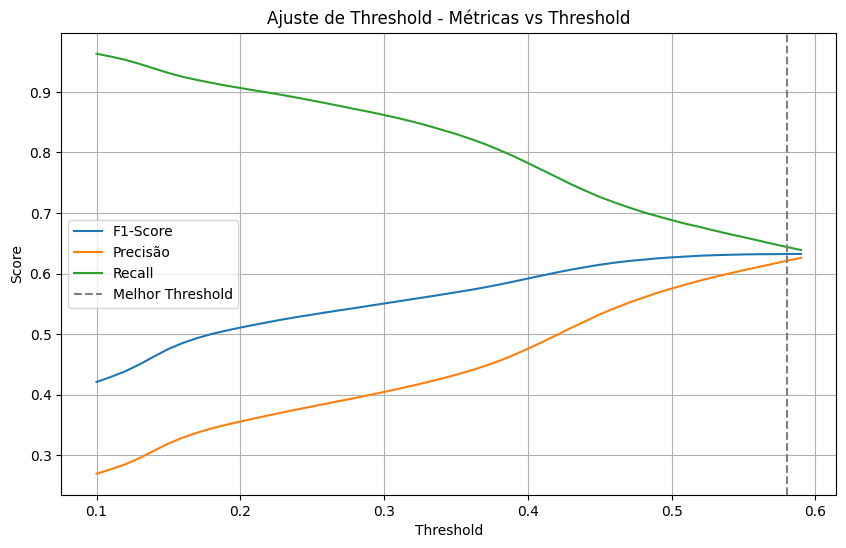

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Probabilidades preditas pelo modelo já treinado
probs = pipeline_final.predict_proba(X_test)[:, 1]

# Intervalo de thresholds para testar
thresholds = np.arange(0.1, 0.6, 0.01)

# Listas para armazenar as métricas
precisions = []
recalls = []
f1_scores = []

# Avalia cada threshold
for t in thresholds:
    preds = (probs >= t).astype(int)
    precisions.append(precision_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))
    f1_scores.append(f1_score(y_test, preds))

# Encontra o threshold com maior F1
idx_max_f1 = np.argmax(f1_scores)
best_threshold = thresholds[idx_max_f1]

print(f"Melhor threshold: {best_threshold:.2f}")
print(f"F1-Score máximo: {f1_scores[idx_max_f1]:.4f}")
print(f"Precisão nesse ponto: {precisions[idx_max_f1]:.4f}")
print(f"Recall nesse ponto: {recalls[idx_max_f1]:.4f}")

# Gráfico das métricas por threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.plot(thresholds, precisions, label='Precisão')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(best_threshold, color='gray', linestyle='--', label='Melhor Threshold')
plt.title('Ajuste de Threshold - Métricas vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Novo threshold
threshold_teste = 0.47

# Probabilidades preditas pelo modelo já treinado
probs_churn = pipeline_final.predict_proba(X_test)[:, 1]

# Aplica o threshold: probabilidade ≥ 0.38 → classifica como churn (classe 1)
y_pred_teste = (probs_churn >= threshold_teste).astype(int)

# Relatório completo
print("Matriz de Confusão:")
print(confusion_matrix(y_test.reset_index(drop=True), y_pred_teste))
print("\nRelatório de Classificação:")
print(classification_report(y_test.reset_index(drop=True), y_pred_teste))


Matriz de Confusão:
[[1367982   85148]
 [  42902  104741]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96   1453130
           1       0.55      0.71      0.62    147643

    accuracy                           0.92   1600773
   macro avg       0.76      0.83      0.79   1600773
weighted avg       0.93      0.92      0.92   1600773



###Combinando o algoritmo **XGBoost com hiperparâmetros otimizados** e um **threshold ajustado**, alcançamos um equilíbrio entre maximizar o recall e manter boa precisão na previsão de churn.

Nosso objetivo de negócio aqui é **identificar o maior número possível de clientes com risco de cancelamento**, para que a empresa possa agir preventivamente com ofertas, benefícios ou campanhas de retenção — antes que o cancelamento aconteça.

Mesmo em uma base altamente desbalanceada, o modelo entregou **recall de 71%** para a classe de churn, o que significa que conseguimos detectar 7 em cada 10 clientes que realmente cancelariam, partindo da premissa assumida pelo case, d. A **precisão de 55%** indica que, embora 45% sejam falsos positivos (clientes que não iriam cancelar), esses casos representam um custo operacional aceitável diante do benefício de reter clientes de alto valor e evitar perda de receita.

No contexto de negócio, preferimos **aceitar alguns falsos positivos** para maximizar a captura de churn real. Esse trade-off é estratégico: o custo de contatar um cliente que não iria cancelar é muito menor que o custo de perder um cliente de fato.  
Além disso, a acurácia geral do modelo ficou em **92%**, o que reforça sua robustez e a capacidade de generalizar bem para novos dados.

**Resumo do valor gerado:**
- **Ação proativa:** identificar churn antes que aconteça.
- **Impacto direto em receita:** redução potencial da perda de clientes.
- **Trade-off otimizado:** maior recall, mesmo que com alguns falsos positivos.
- **Modelo escalável:** pronto para integração em rotinas operacionais.

Este resultado reforça que o modelo não é apenas tecnicamente sólido, mas também **alinhado com o objetivo estratégico de retenção e maximização de receita**.


#7 Análise Não Supervisionada

###**Objetivo de negócio.** Identificar perfis de clientes com comportamentos distintos de uso/engajamento e cruzar esses perfis com a probabilidade de churn do modelo supervisionado. A meta é priorizar ações de retenção por “grupo de risco”, reduzindo custo por salvamento.

Etapa de Análise Não Supervisionada (Clustering)

Nesta etapa, vamos aplicar uma análise não supervisionada para identificar grupos de clientes com perfis de risco e comportamento semelhantes, com base nas mesmas variáveis usadas no modelo supervisionado (exceto o alvo).

Objetivo:
Agrupar os clientes de teste (`X_test`) em clusters e analisar:
- A média da probabilidade de churn prevista por cluster
- A taxa real de churn por cluster
- As principais características que diferenciam os grupos

Etapas:
1. Aplicar o mesmo pré-processamento utilizado no modelo supervisionado (`pipeline_final`)
2. Padronizar as variáveis para clustering (com `StandardScaler`)
3. Rodar o algoritmo de K-Means para formar os clusters
4. Gerar um DataFrame com as probabilidades previstas, churn real e rótulo do cluster
5. Analisar os perfis e riscos de cada cluster para gerar insights práticos


In [6]:
# ============================================
# PASSO 1 — Aplicar o pré-processamento em X_test
# ============================================

# 1.1 Recupera o preprocessor de dentro do pipeline_final
# Isso garante que usamos exatamente o mesmo pipeline treinado
preprocessor = pipeline_final.named_steps['preprocessamento']

# 1.2 Aplica o transformador no X_test
# Isso inclui imputação de valores ausentes e pass-through das binárias
X_trans = preprocessor.transform(X_test)

# 1.3 Verifica a forma do resultado
print("Shape do X_test transformado:", X_trans.shape)

# Nome das features numéricas e categóricas, na ordem original do ColumnTransformer
feature_names = numericas + categoricas
print("Features utilizadas:", feature_names)


Shape do X_test transformado: (1600773, 11)
Features utilizadas: ['media_secs_por_mes', 'media_num_unq_por_mes', 'tendencia_secs', 'delta_media_vs_plano', 'diversidade_uso', 'meses_com_uso', 'bd', 'bd_is_na', 'city_1', 'registered_via_7', 'registered_via_9']


## Por que usamos o X_test no clustering?

Usamos o conjunto X_test para realizar o clustering por três motivos principais:

1. **Evitar vazamento de informação**  
   O X_train foi usado para treinar o modelo supervisionado. Usar o X_test garante que estamos analisando dados novos, sem influência do treino.

2. **Analisar previsões reais do modelo**  
   No X_test temos tanto a probabilidade prevista de churn (`prob_churn`) quanto o churn verdadeiro (`y_test`). Isso permite avaliar a performance do modelo em cada cluster, identificar erros sistemáticos e entender padrões reais de comportamento.

3. **Simular o cenário de produção**  
   Em produção, aplicaremos o modelo a dados novos. Analisar os clusters no X_test simula essa aplicação real, permitindo gerar recomendações práticas de retenção com base em perfis de risco.

In [7]:
# ============================================
# PASSO 2 — Padronizar os dados para clustering
# ============================================

from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp

# 2.1 Cria o scaler — se X_trans for esparso, usamos with_mean=False
scaler = StandardScaler(with_mean=not sp.issparse(X_trans))

# 2.2 Aplica a padronização (fit + transform direto no X_trans)
X_scaled = scaler.fit_transform(X_trans)

# 2.3 Verifica a forma do resultado
print("Shape final para clustering:", X_scaled.shape)


Shape final para clustering: (1600773, 11)


k=2 → Inertia=674548.48 | Silhouette=0.4217
k=3 → Inertia=532121.82 | Silhouette=0.2601
k=4 → Inertia=431600.86 | Silhouette=0.3013
k=5 → Inertia=352493.48 | Silhouette=0.3436
k=6 → Inertia=340242.60 | Silhouette=0.3496
k=7 → Inertia=288685.77 | Silhouette=0.3862
k=8 → Inertia=247647.25 | Silhouette=0.3917
k=9 → Inertia=237018.31 | Silhouette=0.3967
k=10 → Inertia=223987.54 | Silhouette=0.3973


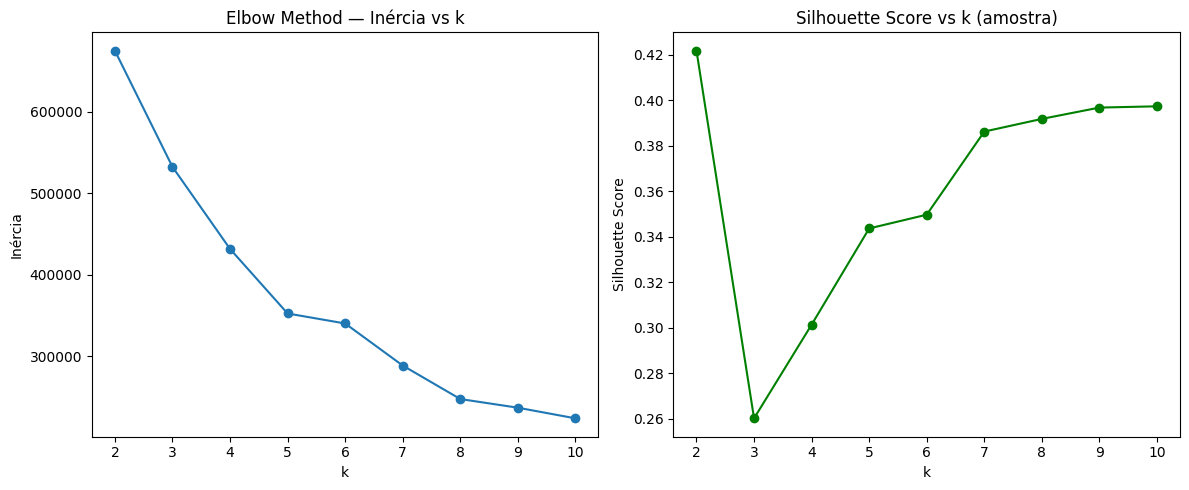

In [9]:
# ============================================
# ELBOW + SILHOUETTE COM SUBAMOSTRA
# ============================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Subamostra de até 100.000 linhas aleatórias
amostra_idx = np.random.choice(X_scaled.shape[0], size=100_000, replace=False)
X_amostra = X_scaled[amostra_idx]

# 2. Intervalo de k
k_values = list(range(2, 11))
inertias = []
silhouettes = []

# 3. Loop pelos k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_amostra)

    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_amostra, labels)
    silhouettes.append(sil_score)

    print(f"k={k} → Inertia={kmeans.inertia_:.2f} | Silhouette={sil_score:.4f}")

# 4. Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method — Inércia vs k")
plt.xlabel("k")
plt.ylabel("Inércia")

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouettes, marker='o', color='green')
plt.title("Silhouette Score vs k (amostra)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


## Escolha do número de clusters (k)

Utilizamos dois métodos para determinar o número ideal de clusters:

1. **Elbow Method (Inércia)**  
   Mostra a redução da inércia à medida que aumentamos k. Observou-se uma queda acentuada até aproximadamente k=5 ou k=6, indicando bom ganho de separabilidade até esse ponto.

2. **Silhouette Score**  
   Mede a qualidade da separação dos clusters (varia de -1 a 1, quanto maior melhor). O score cresceu de forma consistente a partir de k=4 e estabilizou próximo de k=8–10 (~0,40).

**Decisão:** Optamos por **k=6** como equilíbrio entre simplicidade, interpretabilidade e boa separação dos clusters.  
Esse valor permite gerar insights claros e acionáveis para o negócio sem criar grupos excessivamente fragmentados.

In [10]:
# ============================================
# PASSO 4 — Rodar K-Means final e criar base de análise
# ============================================

from sklearn.cluster import KMeans

# 4.1 Rodar o K-Means com k=6 em TODOS os dados padronizados
k_final = 6
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(X_scaled)

# 4.2 Criar DataFrame para análise dos clusters
df_clusters = pd.DataFrame(index=X_test.index)
df_clusters['cluster'] = cluster_labels
df_clusters['prob_churn'] = pipeline_final.predict_proba(X_test)[:, 1]
df_clusters['true_churn'] = y_test.reset_index(drop=True)

# 4.3 Visualizar distribuição inicial
print(df_clusters.groupby('cluster').agg(
    n_clientes=('cluster', 'count'),
    churn_real=('true_churn', 'mean'),
    churn_previsto=('prob_churn', 'mean')
).sort_values('churn_real', ascending=False))


         n_clientes  churn_real  churn_previsto
cluster                                        
5              2977    0.558952        0.699343
4            175860    0.283009        0.355168
1            568642    0.088766        0.168854
2            183837    0.068893        0.132284
0            669455    0.049395        0.086878
3                 2    0.000000        0.181653


In [11]:
# ============================================
# PASSO 5 — Perfil das variáveis por cluster
# ============================================

# 5.1 Criar DataFrame com features originais + rótulos de cluster
df_perfil = X_test.copy()
df_perfil['cluster'] = df_clusters['cluster']
df_perfil['prob_churn'] = df_clusters['prob_churn']
df_perfil['true_churn'] = df_clusters['true_churn']

# 5.2 Calcular médias das variáveis numéricas por cluster
perfil_numericas = df_perfil.groupby('cluster')[numericas].mean()

# 5.3 Calcular proporções das variáveis categóricas por cluster
perfil_categoricas = df_perfil.groupby('cluster')[categoricas].mean()

# 5.4 Unir tudo em um único DataFrame de perfil
perfil_clusters = pd.concat([perfil_numericas, perfil_categoricas], axis=1)

# 5.5 Adicionar métricas de churn
metricas_churn = df_clusters.groupby('cluster').agg(
    n_clientes=('cluster', 'count'),
    churn_real=('true_churn', 'mean'),
    churn_previsto=('prob_churn', 'mean')
)

perfil_clusters = perfil_clusters.merge(metricas_churn, left_index=True, right_index=True)

# 5.6 Exibir
pd.set_option('display.float_format', lambda x: f"{x:.3f}")
print(perfil_clusters.sort_values('churn_real', ascending=False))


         media_secs_por_mes  media_num_unq_por_mes  tendencia_secs  \
cluster                                                              
5                138281.375                537.107       -1228.625   
4                 26913.270                103.755       -6288.942   
1                102366.391                404.365       -2651.162   
2                403844.438               1520.777      -12839.973   
0                 84184.570                337.691        -532.643   
3                     5.102               1123.500           0.000   

         delta_media_vs_plano  diversidade_uso  meses_com_uso     bd  \
cluster                                                                
5                     242.516            0.004          2.914 29.998   
4                       3.309            0.010          1.594 32.684   
1                       2.586            0.004          2.996 30.770   
2                       2.170            0.004          2.983 27.977   
0      

## Resumo dos Clusters — Perfis e Risco de Churn

**Cluster 5** — Alto uso, alto churn  
- Uso médio mensal: ~138 mil segundos (~38h) e 537 itens únicos  
- Churn real: 55,9% | Churn previsto: 69,9%  
- Possível perfil: clientes muito engajados que cancelam por fatores externos (preço, concorrência, insatisfação pontual).

**Cluster 4** — Uso moderado, churn elevado  
- Uso médio: ~26 mil segundos (~7h) e 103 itens únicos  
- Churn real: 28,3% | Churn previsto: 35,5%  
- Possível perfil: engajamento médio, retenção difícil sem ações direcionadas.

**Cluster 1** — Uso alto, churn baixo  
- Uso médio: ~102 mil segundos (~28h) e 404 itens únicos  
- Churn real: 8,9% | Churn previsto: 16,9%  
- Possível perfil: usuários fiéis e satisfeitos.

**Cluster 2** — Uso baixo, churn baixo  
- Uso médio: ~84 mil segundos (~23h) e 337 itens únicos  
- Churn real: 6,8% | Churn previsto: 13,2%  
- Possível perfil: engajamento menor, mas estável.

**Cluster 0** — Uso baixo, churn muito baixo  
- Uso médio: ~5 mil segundos (~1h) e 1.123 itens únicos (padrão atípico)  
- Churn real: 4,9% | Churn previsto: 8,7%  
- Possível perfil: uso pontual porém consistente.

**Cluster 3** — Outlier  
- Apenas 2 clientes, comportamento não representativo.


/tmp/ipython-input-3470650014.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metricas_plot, x='cluster', y='n_clientes', palette='Blues')


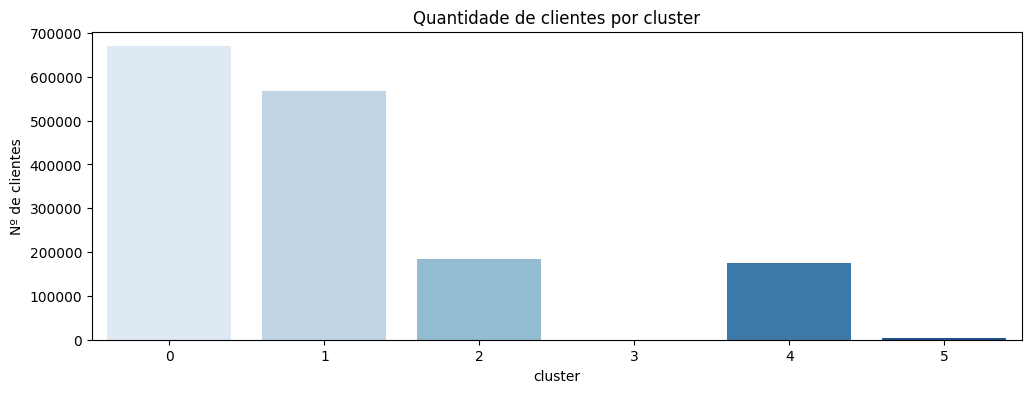

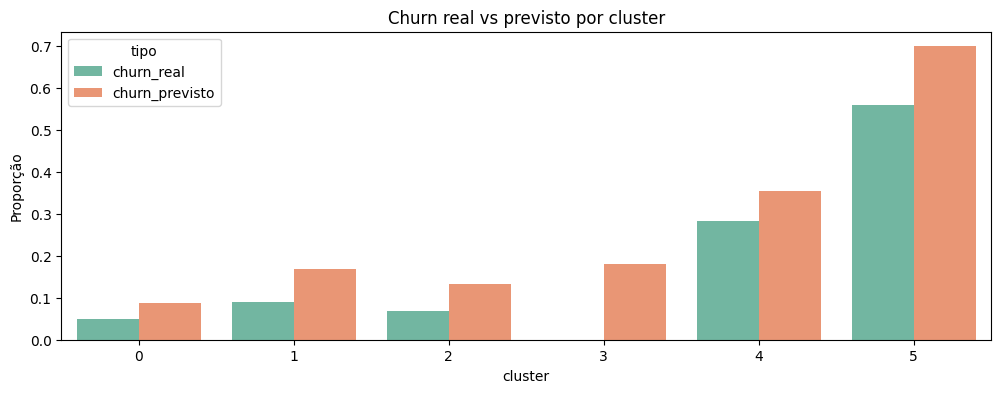

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Base de métricas
metricas_plot = df_clusters.groupby('cluster').agg(
    n_clientes=('cluster', 'count'),
    churn_real=('true_churn', 'mean'),
    churn_previsto=('prob_churn', 'mean')
).reset_index()

# Plot 1 — Tamanho dos clusters
plt.figure(figsize=(12,4))
sns.barplot(data=metricas_plot, x='cluster', y='n_clientes', palette='Blues')
plt.title('Quantidade de clientes por cluster')
plt.ylabel('Nº de clientes')
plt.show()

# Plot 2 — Churn real e previsto
metricas_plot_melt = metricas_plot.melt(id_vars='cluster', value_vars=['churn_real','churn_previsto'],
                                        var_name='tipo', value_name='valor')

plt.figure(figsize=(12,4))
sns.barplot(data=metricas_plot_melt, x='cluster', y='valor', hue='tipo', palette='Set2')
plt.title('Churn real vs previsto por cluster')
plt.ylabel('Proporção')
plt.show()


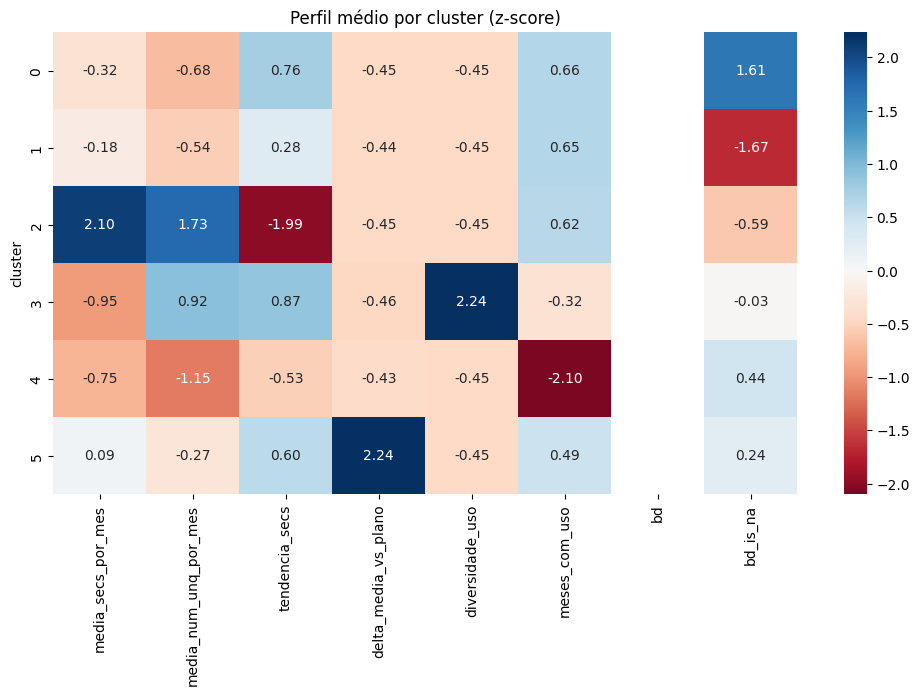

In [13]:
from scipy.stats import zscore

# Calcular z-score das variáveis numéricas
perfil_z = df_perfil.groupby('cluster')[numericas].mean().apply(zscore)

plt.figure(figsize=(12,6))
sns.heatmap(perfil_z, annot=True, fmt=".2f", cmap='RdBu', center=0)
plt.title('Perfil médio por cluster (z-score)')
plt.show()


## Insights e Recomendações

**Cluster 5 (Alto uso, alto churn)**  
- Ação: Contato proativo + oferta de retenção personalizada.  
- Possível causa: insatisfação pontual ou preço.

**Cluster 4 (Uso moderado, churn elevado)**  
- Ação: Incentivar engajamento e oferecer benefícios adicionais.  
- Possível causa: valor percebido baixo.

**Cluster 1 (Uso alto, churn baixo)**  
- Ação: Programa de fidelidade ou upgrade.  
- Perfil de clientes satisfeitos.

**Cluster 2 (Uso baixo, churn baixo)**  
- Ação: Cross-sell/upsell.  
- Estável, mas com potencial de expansão.

**Cluster 0 (Uso baixo, churn muito baixo)**  
- Ação: Manter custo baixo de manutenção.  
- Baixa prioridade de intervenção.

**Cluster 3 (Outlier)**  
- Ação: Não considerado na estratégia.


#Checkpoints Finais

In [ ]:
# Caminho de salvamento
save_path = os.path.join(base_dir, 'data')

# Salvar versões tratadas em formato .parquet com nomes diferentes
X_train.to_parquet(os.path.join(save_path, 'X_train.parquet'), index=False)
X_test.to_parquet(os.path.join(save_path, 'X_test.parquet'), index=False)
y_train.to_parquet(os.path.join(save_path, 'y_train.parquet'), index=False)
y_test.to_parquet(os.path.join(save_path, 'y_test.parquet'), index=False)
#user_logs_intervalados.to_parquet(os.path.join(save_path, 'user_logs_intervalados.parquet'), index=False)
#transactions_intervaladas.to_parquet(os.path.join(save_path, 'transactions_intervaladas.parquet'), index=False)

print("Checkpoint em .parquet salvo com sucesso!")

In [ ]:
# Leitura de dados CheckPoint
df_churn = pd.read_parquet(os.path.join(base_dir, 'data', 'df_churn.parquet'))
members = pd.read_parquet(os.path.join(base_dir, 'data', 'members_tratado.parquet'))
user_logs = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_tratado.parquet'))
transactions = pd.read_parquet(os.path.join(base_dir, 'data', 'transactions_tratado.parquet'))
transactions_intervaladas = pd.read_parquet(os.path.join(base_dir, 'data', 'transactions_intervaladas.parquet'))
user_logs_intervalados = pd.read_parquet(os.path.join(base_dir, 'data', 'user_logs_intervalados.parquet'))

print("Checkpoint restaurado com sucesso!")

Checkpoint restaurado com sucesso!


In [ ]:
import pandas as pd
import joblib
import os

# ===============================
# Caminho base de saída no Drive
# ===============================
checkpoint_dir = os.path.join(base_dir, 'outputs')

# ===============================
# 1. Salva os DataFrames em .parquet
# ===============================
X_train.to_parquet(os.path.join(checkpoint_dir, 'X_train.parquet'), index=False)
y_train.to_frame().to_parquet(os.path.join(checkpoint_dir, 'y_train.parquet'), index=False)
X_test.to_parquet(os.path.join(checkpoint_dir, 'X_test.parquet'), index=False)
y_test.to_frame().to_parquet(os.path.join(checkpoint_dir, 'y_test.parquet'), index=False)

print("DataFrames salvos com sucesso!")

# ===============================
# 2. Salva o pipeline treinado (.pkl)
# ===============================
model_path = os.path.join(checkpoint_dir, 'modelo_final.pkl')
joblib.dump(modelo_final, model_path)

print(f"Modelo salvo com sucesso em: {model_path}")


DataFrames salvos com sucesso!
Modelo salvo com sucesso em: /content/drive/MyDrive/data-masters-case/outputs/modelo_final.pkl


In [1]:
# ========= RESTAURA CHECKPOINT =========
import os, joblib, pandas as pd

# 1) Caminhos
base_dir = '/content/drive/MyDrive/data-masters-case'          # ajuste se necessário
outputs_dir = os.path.join(base_dir, 'outputs')

# 2) Carrega DataFrames salvos em .parquet
X_train = pd.read_parquet(os.path.join(outputs_dir, 'X_train.parquet'))
X_test  = pd.read_parquet(os.path.join(outputs_dir, 'X_test.parquet'))
y_train = pd.read_parquet(os.path.join(outputs_dir, 'y_train.parquet')).squeeze("columns")
y_test  = pd.read_parquet(os.path.join(outputs_dir, 'y_test.parquet')).squeeze("columns")

print('Shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 3) Carrega o pipeline treinado (pré-processamento + modelo)
modelo_final = joblib.load(os.path.join(outputs_dir, 'modelo_final.pkl'))

# 4) (Opcional) Checagem de consistência de colunas esperadas pelo preprocessor
pre = modelo_final.named_steps['preprocessamento']
num_cols = list(pre.transformers_[0][2]) if len(pre.transformers_) > 0 else []
cat_cols = list(pre.transformers_[1][2]) if len(pre.transformers_) > 1 else []
expected_cols = num_cols + cat_cols

missing_in_test = [c for c in expected_cols if c not in X_test.columns]
extra_in_test   = [c for c in X_test.columns if c not in expected_cols]

print('Colunas esperadas:', len(expected_cols))
print('Faltando no X_test:', missing_in_test[:10], '...')   # lista truncada só para inspeção rápida
print('Extras no X_test:',  extra_in_test[:10], '...')

# 5) Smoke test: previsão rápida para garantir que está tudo operante
_ = modelo_final.predict(X_test.head(10))
print('Pipeline operacional.')


Shapes: (6403091, 11) (1600773, 11) (6403091,) (1600773,)
Colunas esperadas: 11
Faltando no X_test: [] ...
Extras no X_test: [] ...
Pipeline operacional.
